# Automatic Ticket Classification 
                            ### by Anish & Ishant


## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
#nlp = en_core_web_sm.load()
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

#from pprint import pprint

import swifter # for making code execution faster
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Remove warnings
import warnings

warnings.filterwarnings('ignore')
import pandas as pd
# row/column display limit
#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',15)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:

# Opening JSON file 
f = open("complaints.json")# Write the path to your data file and load it 
  
# returns JSON object as  a dictionary 
data = json.load(f)

# Create a dataframe out of dictionary 
df=pd.json_normalize(data)

f.close()

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.head()

_index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00            CA  ...  Closed with explanation   
1  2019-05-01T12:00:00-05:00            GA  ...  Closed with explanation   
2  2019-04-02T12:00:00-05:00            TX  ...  Closed with explanation   
3  2017-09-13T12:00:00-05:00            MI  ...  Closed with explanation   
4  2019-04-05T12:00:00-05:00            NY  ...  Closed with explanation   

        _source.company _source.submitted_via _source.date_sent_to_company  \
0  JPMORGAN CHASE & CO.                   Web    2019-04-13T12:00:00-05:00   
1  JPMORGAN CHASE & CO.                   Web    2019-05-01T12:00:00-05:00   
2  JPMORGAN CHASE & CO.                   Web    2019-04-02T12:00:00-05:00   
3  JPMORGAN CHASE & CO.                   Web    2017-09-14T12:00:00-05:00   
4  JPMORGAN CHASE & CO.              Referral    2019-04-05T12:00:00-05:00   

  _source.company_public_response                         _source.sub_product  \
0                            None                            Credit card debt   
1                            None                            Credit card debt   
2                            None  General-purpose credit card or charge card   
3                            None                  Conventional home mortgage   
4                            None  General-purpose credit card or charge card   

  _source.timely  \
0            Yes   
1            Yes   
2            Yes   
3            Yes   
4            Yes   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                              _source.complaint_what_happened  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.   
2                                                                                                    

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
df.describe()

_score
count  78313.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub("^source.", "", col) for col in df.columns]

#printing updated column names now
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [8]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [9]:
# checking for null values now

df.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened      57241
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

### we have 57241 blank values for complaint_what_happened      
let us drop them

In [10]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

#New shape of df
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_texts(text):
    #Make the text lowercase
    text=text.lower()
    
    #Remove text in square brackets
    text=re.sub(r"[\[].*?[\]]",'',text)
   
    
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text



In [12]:
#Cleaning df['complaint_what_happened']
df['complaint_what_happened']= df['complaint_what_happened'].swifter.apply(lambda x: clean_texts(x))

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [13]:
#Write your function to Lemmatize the texts




def lemma_texts(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for swifter.word in tqdm(document):
      #if word not in stopwords:
        lemma_list.append(swifter.word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [14]:
# Add a column for lemmatized complaints to the dataframe
df["lemmatized_complaint"] =  df['complaint_what_happened'].swifter.apply(lambda x: lemma_texts(x))

# View the dataframe
df.head()

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]


100%|█████████████████████████████████████| 101/101 [00:00<00:00, 119263.71it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 196963.10it/s]

100%|████████████████████████████████████████| 37/37 [00:00<00:00, 81894.06it/s]

100%|█████████████████████████████████████| 294/294 [00:00<00:00, 336368.08it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 271554.30it/s]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 24877.25it/s]

100%|█████████████████████████████████████| 450/450 [00:00<00:00, 564593.72it/s]

100%|█████████████████████████████████████| 257/257 [00:00<00:00, 586791.58it/s]

100%|█████████████████████████████████████| 679/679 [00:00<00:00, 517900.06it/s]

100%|████████████████████████████████████████| 25/25 [00:00<00:00, 77214.73it/s]

100%|████████████████████████████████████████| 10/10 [00:00<00:00, 76260.07it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 289858.08it/s]

100%|██████████

100%|█████████████████████████████████████| 257/257 [00:00<00:00, 418615.97it/s]

100%|█████████████████████████████████████| 314/314 [00:00<00:00, 321300.67it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 188843.07it/s]

100%|█████████████████████████████████████| 211/211 [00:00<00:00, 368749.23it/s]

100%|█████████████████████████████████████| 368/368 [00:00<00:00, 489379.79it/s]

100%|███████████████████████████████████| 1867/1867 [00:00<00:00, 851818.29it/s]

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 342641.90it/s]

100%|█████████████████████████████████████| 526/526 [00:00<00:00, 596110.21it/s]

100%|█████████████████████████████████████| 584/584 [00:00<00:00, 370011.11it/s]

100%|█████████████████████████████████████| 533/533 [00:00<00:00, 348110.25it/s]

100%|███████████████████████████████████████| 66/66 [00:00<00:00, 158275.62it/s]

100%|█████████████████████████████████████| 279/279 [00:00<00:00, 528550.50it/s]

100%|███████████

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 285049.79it/s]

100%|█████████████████████████████████████| 307/307 [00:00<00:00, 490533.84it/s]

100%|█████████████████████████████████████| 708/708 [00:00<00:00, 330981.64it/s]

100%|█████████████████████████████████████| 134/134 [00:00<00:00, 183073.86it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 231907.69it/s]

100%|█████████████████████████████████████| 371/371 [00:00<00:00, 400228.08it/s]

100%|███████████████████████████████████| 1327/1327 [00:00<00:00, 405969.47it/s]

100%|█████████████████████████████████████| 456/456 [00:00<00:00, 387088.17it/s]

100%|██████████████████████████████████████| 217/217 [00:00<00:00, 54991.48it/s]

100%|█████████████████████████████████████| 207/207 [00:00<00:00, 213847.52it/s]

100%|███████████████████████████████████████| 90/90 [00:00<00:00, 120950.77it/s]

100%|█████████████████████████████████████| 233/233 [00:00<00:00, 347783.93it/s]

100%|███████████

100%|█████████████████████████████████████| 330/330 [00:00<00:00, 532353.97it/s]

100%|█████████████████████████████████████| 141/141 [00:00<00:00, 179592.12it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 117180.11it/s]

100%|███████████████████████████████████████| 76/76 [00:00<00:00, 133319.58it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 216640.60it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 306700.43it/s]

100%|█████████████████████████████████████| 218/218 [00:00<00:00, 370035.72it/s]

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 168206.24it/s]

100%|█████████████████████████████████████| 315/315 [00:00<00:00, 336184.67it/s]

100%|███████████████████████████████████| 1816/1816 [00:00<00:00, 850190.43it/s]

100%|█████████████████████████████████████| 628/628 [00:00<00:00, 496517.04it/s]

100%|█████████████████████████████████████| 252/252 [00:00<00:00, 227450.96it/s]

100%|███████████

100%|███████████████████████████████████| 1099/1099 [00:00<00:00, 671357.43it/s]

100%|█████████████████████████████████████| 251/251 [00:00<00:00, 427434.15it/s]

100%|█████████████████████████████████████| 138/138 [00:00<00:00, 162542.53it/s]

100%|█████████████████████████████████████| 139/139 [00:00<00:00, 233577.03it/s]

100%|█████████████████████████████████████| 796/796 [00:00<00:00, 716451.93it/s]

100%|█████████████████████████████████████| 288/288 [00:00<00:00, 282035.85it/s]

100%|█████████████████████████████████████| 257/257 [00:00<00:00, 318069.08it/s]

100%|█████████████████████████████████████| 290/290 [00:00<00:00, 391234.53it/s]

100%|█████████████████████████████████████| 372/372 [00:00<00:00, 292955.52it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 148705.29it/s]

100%|█████████████████████████████████████| 230/230 [00:00<00:00, 533567.43it/s]

100%|█████████████████████████████████████| 768/768 [00:00<00:00, 524544.13it/s]

100%|███████████

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 136163.59it/s]

100%|█████████████████████████████████████| 398/398 [00:00<00:00, 534699.87it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 378962.05it/s]

100%|█████████████████████████████████████| 275/275 [00:00<00:00, 552146.29it/s]

100%|█████████████████████████████████████| 477/477 [00:00<00:00, 411240.08it/s]

100%|█████████████████████████████████████| 177/177 [00:00<00:00, 281849.59it/s]

100%|█████████████████████████████████████| 363/363 [00:00<00:00, 519458.33it/s]

100%|█████████████████████████████████████| 168/168 [00:00<00:00, 240246.53it/s]

100%|██████████████████████████████████| 2109/2109 [00:00<00:00, 1001901.36it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 236584.43it/s]

100%|█████████████████████████████████████| 428/428 [00:00<00:00, 360546.72it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 298243.62it/s]

100%|███████████

100%|█████████████████████████████████████| 341/341 [00:00<00:00, 233549.59it/s]

100%|█████████████████████████████████████| 149/149 [00:00<00:00, 234679.42it/s]

100%|████████████████████████████████████████| 13/13 [00:00<00:00, 35801.68it/s]

100%|█████████████████████████████████████| 146/146 [00:00<00:00, 212480.36it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 187566.40it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 115971.54it/s]

100%|█████████████████████████████████████| 381/381 [00:00<00:00, 464004.01it/s]

100%|█████████████████████████████████████| 689/689 [00:00<00:00, 376531.00it/s]

100%|█████████████████████████████████████| 278/278 [00:00<00:00, 219258.46it/s]

100%|█████████████████████████████████████| 621/621 [00:00<00:00, 597125.81it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 222304.92it/s]

100%|█████████████████████████████████████| 148/148 [00:00<00:00, 294197.63it/s]

100%|███████████

100%|█████████████████████████████████████| 297/297 [00:00<00:00, 282601.70it/s]

100%|█████████████████████████████████████| 519/519 [00:00<00:00, 480115.52it/s]

100%|████████████████████████████████████████| 38/38 [00:00<00:00, 98142.58it/s]

100%|█████████████████████████████████████| 166/166 [00:00<00:00, 162108.14it/s]

100%|███████████████████████████████████████| 58/58 [00:00<00:00, 120133.15it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 324124.82it/s]

100%|███████████████████████████████████| 1151/1151 [00:00<00:00, 712777.78it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 118653.41it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 452604.23it/s]

100%|████████████████████████████████████████| 37/37 [00:00<00:00, 96331.00it/s]

100%|█████████████████████████████████████| 146/146 [00:00<00:00, 420871.74it/s]

100%|█████████████████████████████████████| 284/284 [00:00<00:00, 356321.37it/s]

100%|███████████

100%|█████████████████████████████████████| 266/266 [00:00<00:00, 480277.60it/s]

100%|███████████████████████████████████████| 30/30 [00:00<00:00, 128266.18it/s]

100%|█████████████████████████████████████| 514/514 [00:00<00:00, 592924.16it/s]

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 286724.96it/s]

100%|█████████████████████████████████████| 560/560 [00:00<00:00, 354805.17it/s]

100%|█████████████████████████████████████| 245/245 [00:00<00:00, 422361.07it/s]

100%|█████████████████████████████████████| 629/629 [00:00<00:00, 298778.85it/s]

100%|███████████████████████████████████████| 96/96 [00:00<00:00, 144995.75it/s]

100%|█████████████████████████████████████| 218/218 [00:00<00:00, 276659.08it/s]

100%|█████████████████████████████████████| 242/242 [00:00<00:00, 310689.19it/s]

100%|███████████████████████████████████████| 74/74 [00:00<00:00, 175752.26it/s]

100%|████████████████████████████████████████| 35/35 [00:00<00:00, 53420.90it/s]

100%|███████████

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 335782.04it/s]

100%|█████████████████████████████████████| 321/321 [00:00<00:00, 382057.77it/s]

100%|█████████████████████████████████████| 836/836 [00:00<00:00, 595421.66it/s]

100%|█████████████████████████████████████| 233/233 [00:00<00:00, 285501.85it/s]

100%|█████████████████████████████████████| 418/418 [00:00<00:00, 494700.64it/s]

100%|█████████████████████████████████████| 427/427 [00:00<00:00, 500549.97it/s]

100%|█████████████████████████████████████| 116/116 [00:00<00:00, 233913.11it/s]

100%|█████████████████████████████████████| 306/306 [00:00<00:00, 277924.86it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 283246.83it/s]

100%|█████████████████████████████████████| 831/831 [00:00<00:00, 623852.98it/s]

100%|█████████████████████████████████████| 231/231 [00:00<00:00, 236891.01it/s]

100%|████████████████████████████████████████| 48/48 [00:00<00:00, 78337.20it/s]

100%|███████████

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 185574.14it/s]

100%|█████████████████████████████████████| 274/274 [00:00<00:00, 415187.61it/s]

100%|█████████████████████████████████████| 443/443 [00:00<00:00, 379354.16it/s]

100%|█████████████████████████████████████| 305/305 [00:00<00:00, 261822.09it/s]

100%|█████████████████████████████████████| 230/230 [00:00<00:00, 352205.16it/s]

100%|████████████████████████████████████████| 23/23 [00:00<00:00, 38914.48it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 137015.29it/s]

100%|███████████████████████████████████████| 74/74 [00:00<00:00, 200115.08it/s]

100%|█████████████████████████████████████| 253/253 [00:00<00:00, 456805.39it/s]

100%|█████████████████████████████████████| 194/194 [00:00<00:00, 278758.13it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 154331.63it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 406191.56it/s]

100%|███████████

100%|█████████████████████████████████████| 388/388 [00:00<00:00, 382285.64it/s]

100%|█████████████████████████████████████| 123/123 [00:00<00:00, 252520.51it/s]

100%|████████████████████████████████████████| 28/28 [00:00<00:00, 78241.51it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 267986.73it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 193145.36it/s]

100%|█████████████████████████████████████| 245/245 [00:00<00:00, 342192.63it/s]

100%|█████████████████████████████████████| 416/416 [00:00<00:00, 207866.39it/s]

100%|█████████████████████████████████████| 138/138 [00:00<00:00, 178481.02it/s]

100%|█████████████████████████████████████| 150/150 [00:00<00:00, 248379.63it/s]

100%|█████████████████████████████████████| 288/288 [00:00<00:00, 439737.73it/s]

100%|█████████████████████████████████████| 595/595 [00:00<00:00, 291952.61it/s]

100%|█████████████████████████████████████| 103/103 [00:00<00:00, 203491.90it/s]

100%|███████████

100%|█████████████████████████████████████| 742/742 [00:00<00:00, 679662.28it/s]

100%|█████████████████████████████████████| 125/125 [00:00<00:00, 249067.93it/s]

100%|█████████████████████████████████████| 154/154 [00:00<00:00, 343758.82it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 523198.00it/s]

100%|█████████████████████████████████████| 338/338 [00:00<00:00, 266130.05it/s]

100%|█████████████████████████████████████| 167/167 [00:00<00:00, 250697.48it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 249135.35it/s]

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 283230.06it/s]

100%|███████████████████████████████████| 1233/1233 [00:00<00:00, 871369.31it/s]

100%|█████████████████████████████████████| 414/414 [00:00<00:00, 500127.26it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 241277.69it/s]

100%|█████████████████████████████████████| 690/690 [00:00<00:00, 558269.63it/s]

100%|███████████

100%|█████████████████████████████████████| 206/206 [00:00<00:00, 300844.92it/s]

100%|█████████████████████████████████████| 747/747 [00:00<00:00, 660582.98it/s]

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 364666.84it/s]

100%|███████████████████████████████████████| 85/85 [00:00<00:00, 200515.10it/s]

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 380629.77it/s]

100%|█████████████████████████████████████| 228/228 [00:00<00:00, 357362.22it/s]

100%|█████████████████████████████████████| 254/254 [00:00<00:00, 423936.81it/s]

100%|█████████████████████████████████████| 292/292 [00:00<00:00, 279684.12it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 197361.81it/s]

100%|█████████████████████████████████████| 958/958 [00:00<00:00, 467552.16it/s]

100%|█████████████████████████████████████| 330/330 [00:00<00:00, 478934.37it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 139159.85it/s]

100%|███████████

100%|█████████████████████████████████████| 157/157 [00:00<00:00, 277382.36it/s]

100%|█████████████████████████████████████| 304/304 [00:00<00:00, 510640.13it/s]

100%|█████████████████████████████████████| 264/264 [00:00<00:00, 373329.82it/s]

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 223148.13it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 378946.66it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 178392.75it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 248667.28it/s]

100%|█████████████████████████████████████| 661/661 [00:00<00:00, 468395.83it/s]

100%|█████████████████████████████████████| 204/204 [00:00<00:00, 524288.00it/s]

100%|█████████████████████████████████████| 118/118 [00:00<00:00, 216503.88it/s]

100%|█████████████████████████████████████| 510/510 [00:00<00:00, 615921.41it/s]

100%|███████████████████████████████████████| 90/90 [00:00<00:00, 332002.96it/s]

100%|███████████

100%|█████████████████████████████████████| 237/237 [00:00<00:00, 565443.71it/s]

100%|█████████████████████████████████████| 868/868 [00:00<00:00, 606573.79it/s]

100%|█████████████████████████████████████| 336/336 [00:00<00:00, 435367.98it/s]

100%|████████████████████████████████████████| 50/50 [00:00<00:00, 84733.41it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 46382.51it/s]

100%|█████████████████████████████████████| 297/297 [00:00<00:00, 453314.52it/s]

100%|█████████████████████████████████████| 222/222 [00:00<00:00, 350710.16it/s]

100%|████████████████████████████████████████| 27/27 [00:00<00:00, 60527.10it/s]

100%|████████████████████████████████████████| 67/67 [00:00<00:00, 77372.90it/s]

100%|███████████████████████████████████████| 61/61 [00:00<00:00, 172291.28it/s]

100%|█████████████████████████████████████| 216/216 [00:00<00:00, 299197.38it/s]

100%|█████████████████████████████████████| 356/356 [00:00<00:00, 400529.03it/s]

100%|███████████

100%|███████████████████████████████████████| 43/43 [00:00<00:00, 218083.52it/s]

100%|█████████████████████████████████████| 297/297 [00:00<00:00, 506797.51it/s]

100%|█████████████████████████████████████| 508/508 [00:00<00:00, 509616.46it/s]

100%|█████████████████████████████████████| 126/126 [00:00<00:00, 214307.50it/s]

100%|█████████████████████████████████████| 497/497 [00:00<00:00, 407381.10it/s]

100%|███████████████████████████████████| 1182/1182 [00:00<00:00, 777795.31it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 483017.52it/s]

100%|█████████████████████████████████████| 269/269 [00:00<00:00, 412077.35it/s]

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 177989.58it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 379751.26it/s]

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 214362.89it/s]

100%|█████████████████████████████████████| 306/306 [00:00<00:00, 402590.03it/s]

100%|███████████

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 331323.02it/s]

100%|█████████████████████████████████████| 214/214 [00:00<00:00, 394888.28it/s]

100%|███████████████████████████████████████| 97/97 [00:00<00:00, 202512.44it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 170917.03it/s]

100%|█████████████████████████████████████| 234/234 [00:00<00:00, 295089.34it/s]

100%|█████████████████████████████████████| 360/360 [00:00<00:00, 386275.12it/s]

100%|█████████████████████████████████████| 300/300 [00:00<00:00, 289862.06it/s]

100%|█████████████████████████████████████| 260/260 [00:00<00:00, 246947.25it/s]

100%|███████████████████████████████████████| 53/53 [00:00<00:00, 121011.49it/s]

100%|█████████████████████████████████████| 707/707 [00:00<00:00, 508727.56it/s]

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 163192.25it/s]

100%|████████████████████████████████████████| 43/43 [00:00<00:00, 64481.61it/s]

100%|███████████

100%|█████████████████████████████████████| 159/159 [00:00<00:00, 195398.28it/s]

100%|█████████████████████████████████████| 323/323 [00:00<00:00, 496795.08it/s]

100%|█████████████████████████████████████| 443/443 [00:00<00:00, 481491.75it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 158228.23it/s]

100%|█████████████████████████████████████| 462/462 [00:00<00:00, 693794.65it/s]

100%|█████████████████████████████████████| 469/469 [00:00<00:00, 538349.36it/s]

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 417766.73it/s]

100%|█████████████████████████████████████| 230/230 [00:00<00:00, 404312.62it/s]

100%|████████████████████████████████████████| 58/58 [00:00<00:00, 77746.77it/s]

100%|█████████████████████████████████████| 105/105 [00:00<00:00, 462607.06it/s]

100%|█████████████████████████████████████| 256/256 [00:00<00:00, 281305.17it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 176554.62it/s]

100%|███████████

100%|█████████████████████████████████████| 249/249 [00:00<00:00, 228880.49it/s]

100%|█████████████████████████████████████| 231/231 [00:00<00:00, 352065.49it/s]

100%|█████████████████████████████████████| 284/284 [00:00<00:00, 449502.77it/s]

100%|█████████████████████████████████████| 470/470 [00:00<00:00, 444692.73it/s]

100%|█████████████████████████████████████| 397/397 [00:00<00:00, 300295.53it/s]

100%|█████████████████████████████████████| 412/412 [00:00<00:00, 544268.74it/s]

100%|█████████████████████████████████████| 387/387 [00:00<00:00, 415352.01it/s]

100%|█████████████████████████████████████| 214/214 [00:00<00:00, 347764.84it/s]

100%|█████████████████████████████████████| 248/248 [00:00<00:00, 272300.36it/s]

100%|█████████████████████████████████████| 213/213 [00:00<00:00, 342424.97it/s]

100%|█████████████████████████████████████| 111/111 [00:00<00:00, 154212.57it/s]

100%|█████████████████████████████████████| 800/800 [00:00<00:00, 637553.33it/s]

100%|███████████

100%|█████████████████████████████████████| 114/114 [00:00<00:00, 194766.05it/s]

100%|█████████████████████████████████████| 223/223 [00:00<00:00, 372344.66it/s]

100%|█████████████████████████████████████| 411/411 [00:00<00:00, 254331.51it/s]

100%|█████████████████████████████████████| 145/145 [00:00<00:00, 315934.59it/s]

100%|███████████████████████████████████████| 89/89 [00:00<00:00, 383651.65it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 183217.60it/s]

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 137593.35it/s]

100%|█████████████████████████████████████| 301/301 [00:00<00:00, 522768.32it/s]

100%|███████████████████████████████████| 1516/1516 [00:00<00:00, 881420.14it/s]

100%|█████████████████████████████████████| 361/361 [00:00<00:00, 478251.34it/s]

100%|█████████████████████████████████████| 147/147 [00:00<00:00, 307512.56it/s]

100%|████████████████████████████████████████| 19/19 [00:00<00:00, 46794.94it/s]

100%|███████████

100%|███████████████████████████████████████| 61/61 [00:00<00:00, 118231.30it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 111919.17it/s]

100%|█████████████████████████████████████| 461/461 [00:00<00:00, 253983.21it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 191793.51it/s]

100%|█████████████████████████████████████| 238/238 [00:00<00:00, 218961.25it/s]

100%|█████████████████████████████████████| 395/395 [00:00<00:00, 308347.31it/s]

100%|███████████████████████████████████████| 45/45 [00:00<00:00, 115157.83it/s]

100%|█████████████████████████████████████| 173/173 [00:00<00:00, 374414.13it/s]

100%|█████████████████████████████████████| 239/239 [00:00<00:00, 343418.52it/s]

100%|█████████████████████████████████████| 260/260 [00:00<00:00, 421375.21it/s]

100%|█████████████████████████████████████| 212/212 [00:00<00:00, 272842.11it/s]

100%|█████████████████████████████████████| 560/560 [00:00<00:00, 559907.09it/s]

100%|███████████

100%|█████████████████████████████████████| 245/245 [00:00<00:00, 512520.94it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 110801.65it/s]

100%|███████████████████████████████████████| 90/90 [00:00<00:00, 218453.33it/s]

100%|█████████████████████████████████████| 157/157 [00:00<00:00, 233347.18it/s]

100%|█████████████████████████████████████| 132/132 [00:00<00:00, 295279.00it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 229057.86it/s]

100%|█████████████████████████████████████| 702/702 [00:00<00:00, 663452.32it/s]

100%|█████████████████████████████████████| 327/327 [00:00<00:00, 507037.86it/s]

100%|█████████████████████████████████████| 293/293 [00:00<00:00, 376626.13it/s]

100%|█████████████████████████████████████| 385/385 [00:00<00:00, 278415.01it/s]

100%|███████████████████████████████████████| 52/52 [00:00<00:00, 109489.86it/s]

100%|█████████████████████████████████████| 146/146 [00:00<00:00, 384170.88it/s]

100%|███████████

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 322274.21it/s]

100%|█████████████████████████████████████| 256/256 [00:00<00:00, 333356.67it/s]

100%|███████████████████████████████████████| 59/59 [00:00<00:00, 105124.87it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 171724.17it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 491830.26it/s]

100%|████████████████████████████████████████| 29/29 [00:00<00:00, 92921.94it/s]

100%|█████████████████████████████████████| 437/437 [00:00<00:00, 397680.81it/s]

100%|█████████████████████████████████████| 179/179 [00:00<00:00, 289206.63it/s]

100%|█████████████████████████████████████| 150/150 [00:00<00:00, 266474.21it/s]

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 425810.13it/s]

100%|█████████████████████████████████████| 217/217 [00:00<00:00, 289400.31it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 254893.43it/s]

100%|███████████

100%|████████████████████████████████████████| 16/16 [00:00<00:00, 35715.20it/s]

100%|███████████████████████████████████████| 45/45 [00:00<00:00, 116869.15it/s]

100%|█████████████████████████████████████| 687/687 [00:00<00:00, 637920.49it/s]

100%|█████████████████████████████████████| 179/179 [00:00<00:00, 132202.93it/s]

100%|███████████████████████████████████| 5377/5377 [00:00<00:00, 774982.74it/s]

100%|█████████████████████████████████████| 159/159 [00:00<00:00, 244642.09it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 209274.62it/s]

100%|█████████████████████████████████████| 446/446 [00:00<00:00, 444231.68it/s]

100%|████████████████████████████████████████| 32/32 [00:00<00:00, 59918.63it/s]

100%|█████████████████████████████████████| 157/157 [00:00<00:00, 326316.02it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 157958.56it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 148358.40it/s]

100%|███████████

100%|███████████████████████████████████| 2863/2863 [00:00<00:00, 865712.09it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 417503.46it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 329652.66it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 287000.27it/s]

100%|█████████████████████████████████████| 105/105 [00:00<00:00, 152335.50it/s]

100%|█████████████████████████████████████| 399/399 [00:00<00:00, 232111.97it/s]

100%|█████████████████████████████████████| 384/384 [00:00<00:00, 369237.22it/s]

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 360283.81it/s]

100%|█████████████████████████████████████| 335/335 [00:00<00:00, 247593.28it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 176191.70it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 124995.81it/s]

100%|███████████████████████████████████| 1008/1008 [00:00<00:00, 721600.69it/s]

100%|███████████

100%|█████████████████████████████████████| 410/410 [00:00<00:00, 570937.80it/s]

100%|█████████████████████████████████████| 376/376 [00:00<00:00, 462344.86it/s]

100%|███████████████████████████████████| 1112/1112 [00:00<00:00, 726376.90it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 219862.71it/s]

100%|████████████████████████████████████████| 19/19 [00:00<00:00, 49131.80it/s]

100%|█████████████████████████████████████| 369/369 [00:00<00:00, 521813.28it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 220897.27it/s]

100%|███████████████████████████████████████| 59/59 [00:00<00:00, 189627.54it/s]

100%|█████████████████████████████████████| 137/137 [00:00<00:00, 268639.39it/s]

100%|█████████████████████████████████████| 292/292 [00:00<00:00, 515028.08it/s]

100%|█████████████████████████████████████| 438/438 [00:00<00:00, 373395.36it/s]

100%|█████████████████████████████████████| 425/425 [00:00<00:00, 560735.83it/s]

100%|███████████

100%|█████████████████████████████████████| 289/289 [00:00<00:00, 423830.02it/s]

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 190251.93it/s]

100%|█████████████████████████████████████| 142/142 [00:00<00:00, 276248.22it/s]

100%|█████████████████████████████████████| 376/376 [00:00<00:00, 367955.74it/s]

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 238687.46it/s]

100%|███████████████████████████████████████| 61/61 [00:00<00:00, 150945.45it/s]

100%|█████████████████████████████████████| 340/340 [00:00<00:00, 405361.96it/s]

100%|█████████████████████████████████████| 175/175 [00:00<00:00, 215061.00it/s]

100%|█████████████████████████████████████| 129/129 [00:00<00:00, 135198.70it/s]

100%|████████████████████████████████████████| 10/10 [00:00<00:00, 29599.89it/s]

100%|█████████████████████████████████████| 417/417 [00:00<00:00, 516698.60it/s]

100%|█████████████████████████████████████| 444/444 [00:00<00:00, 332786.09it/s]

100%|███████████

100%|████████████████████████████████████████| 35/35 [00:00<00:00, 61192.43it/s]

100%|███████████████████████████████████████| 82/82 [00:00<00:00, 222898.85it/s]

100%|████████████████████████████████████████| 13/13 [00:00<00:00, 36109.90it/s]

100%|█████████████████████████████████████| 153/153 [00:00<00:00, 181535.65it/s]

100%|███████████████████████████████████████| 85/85 [00:00<00:00, 223661.13it/s]

100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 20549.12it/s]

100%|█████████████████████████████████████| 404/404 [00:00<00:00, 422673.69it/s]

100%|█████████████████████████████████████| 227/227 [00:00<00:00, 316946.41it/s]

100%|█████████████████████████████████████| 254/254 [00:00<00:00, 384326.56it/s]

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 137917.15it/s]

100%|█████████████████████████████████████| 346/346 [00:00<00:00, 450552.37it/s]

100%|███████████████████████████████████████| 51/51 [00:00<00:00, 130036.17it/s]

100%|███████████

100%|█████████████████████████████████████| 132/132 [00:00<00:00, 141128.76it/s]

100%|███████████████████████████████████| 1033/1033 [00:00<00:00, 937411.52it/s]

100%|█████████████████████████████████████| 282/282 [00:00<00:00, 466033.78it/s]

100%|█████████████████████████████████████| 106/106 [00:00<00:00, 458819.63it/s]

100%|█████████████████████████████████████| 303/303 [00:00<00:00, 325865.16it/s]

100%|█████████████████████████████████████| 125/125 [00:00<00:00, 276523.21it/s]

100%|█████████████████████████████████████| 168/168 [00:00<00:00, 374213.00it/s]

100%|█████████████████████████████████████| 378/378 [00:00<00:00, 512923.62it/s]

100%|████████████████████████████████████████| 24/24 [00:00<00:00, 65536.00it/s]

100%|█████████████████████████████████████| 194/194 [00:00<00:00, 457646.22it/s]

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 198722.06it/s]

100%|█████████████████████████████████████| 205/205 [00:00<00:00, 294160.90it/s]

100%|███████████

100%|█████████████████████████████████████| 179/179 [00:00<00:00, 253899.36it/s]

100%|███████████████████████████████████| 1203/1203 [00:00<00:00, 522875.41it/s]

100%|████████████████████████████████████████| 31/31 [00:00<00:00, 44789.33it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 111871.78it/s]

100%|█████████████████████████████████████| 539/539 [00:00<00:00, 420757.46it/s]

100%|█████████████████████████████████████| 298/298 [00:00<00:00, 258244.34it/s]

100%|█████████████████████████████████████| 311/311 [00:00<00:00, 351030.29it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 130724.33it/s]

100%|█████████████████████████████████████| 209/209 [00:00<00:00, 172459.09it/s]

100%|█████████████████████████████████████| 261/261 [00:00<00:00, 246003.00it/s]

100%|█████████████████████████████████████| 178/178 [00:00<00:00, 214659.61it/s]

100%|███████████████████████████████████████| 53/53 [00:00<00:00, 143325.67it/s]

100%|███████████

100%|█████████████████████████████████████| 289/289 [00:00<00:00, 497600.11it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 364518.90it/s]

100%|█████████████████████████████████████| 157/157 [00:00<00:00, 428993.96it/s]

100%|█████████████████████████████████████| 239/239 [00:00<00:00, 206603.19it/s]

100%|█████████████████████████████████████| 239/239 [00:00<00:00, 285839.37it/s]

100%|█████████████████████████████████████| 209/209 [00:00<00:00, 271060.46it/s]

100%|█████████████████████████████████████| 132/132 [00:00<00:00, 203397.55it/s]

100%|█████████████████████████████████████| 380/380 [00:00<00:00, 483566.60it/s]

100%|█████████████████████████████████████| 318/318 [00:00<00:00, 374029.35it/s]

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 138664.47it/s]

100%|█████████████████████████████████████| 773/773 [00:00<00:00, 597860.41it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 277768.48it/s]

100%|███████████

100%|█████████████████████████████████████| 149/149 [00:00<00:00, 272785.38it/s]

100%|█████████████████████████████████████| 307/307 [00:00<00:00, 290207.65it/s]

100%|█████████████████████████████████████| 420/420 [00:00<00:00, 309108.21it/s]

100%|█████████████████████████████████████| 519/519 [00:00<00:00, 586434.21it/s]

100%|█████████████████████████████████████| 467/467 [00:00<00:00, 414372.75it/s]

100%|█████████████████████████████████████| 456/456 [00:00<00:00, 382214.75it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 228553.93it/s]

100%|█████████████████████████████████████| 330/330 [00:00<00:00, 227576.51it/s]

100%|█████████████████████████████████████| 139/139 [00:00<00:00, 186324.15it/s]

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 184482.72it/s]

100%|█████████████████████████████████████| 219/219 [00:00<00:00, 296690.11it/s]

100%|█████████████████████████████████████| 624/624 [00:00<00:00, 580964.64it/s]

100%|███████████

100%|█████████████████████████████████████| 178/178 [00:00<00:00, 194322.26it/s]

100%|█████████████████████████████████████| 139/139 [00:00<00:00, 159947.40it/s]

100%|█████████████████████████████████████| 220/220 [00:00<00:00, 433214.50it/s]

100%|█████████████████████████████████████| 189/189 [00:00<00:00, 258132.03it/s]

100%|█████████████████████████████████████| 341/341 [00:00<00:00, 238296.85it/s]

100%|█████████████████████████████████████| 128/128 [00:00<00:00, 250056.32it/s]

100%|███████████████████████████████████████| 89/89 [00:00<00:00, 196573.49it/s]

100%|█████████████████████████████████████| 323/323 [00:00<00:00, 427773.98it/s]

100%|█████████████████████████████████████| 409/409 [00:00<00:00, 504253.48it/s]

100%|███████████████████████████████████████| 87/87 [00:00<00:00, 171638.97it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 142248.68it/s]

100%|█████████████████████████████████████| 402/402 [00:00<00:00, 483264.61it/s]

100%|███████████

100%|█████████████████████████████████████| 697/697 [00:00<00:00, 646633.46it/s]

100%|█████████████████████████████████████| 323/323 [00:00<00:00, 445498.25it/s]

100%|█████████████████████████████████████| 496/496 [00:00<00:00, 332222.10it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 302646.01it/s]

100%|████████████████████████████████████████| 41/41 [00:00<00:00, 89940.62it/s]

100%|████████████████████████████████████████| 11/11 [00:00<00:00, 73819.75it/s]

100%|█████████████████████████████████████| 333/333 [00:00<00:00, 531065.87it/s]

100%|█████████████████████████████████████| 297/297 [00:00<00:00, 369427.13it/s]

100%|███████████████████████████████████████| 71/71 [00:00<00:00, 137359.59it/s]

100%|█████████████████████████████████████| 341/341 [00:00<00:00, 486979.12it/s]

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 247764.79it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 218755.61it/s]

100%|███████████

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 235447.77it/s]

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 241265.27it/s]

100%|████████████████████████████████████████| 53/53 [00:00<00:00, 53851.29it/s]

100%|███████████████████████████████████| 1425/1425 [00:00<00:00, 778747.00it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 253132.17it/s]

100%|█████████████████████████████████████| 656/656 [00:00<00:00, 294557.69it/s]

100%|████████████████████████████████████████| 27/27 [00:00<00:00, 65384.65it/s]

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 428919.78it/s]

100%|█████████████████████████████████████| 413/413 [00:00<00:00, 518171.57it/s]

100%|█████████████████████████████████████| 453/453 [00:00<00:00, 573331.23it/s]

100%|█████████████████████████████████████| 137/137 [00:00<00:00, 251915.67it/s]

100%|█████████████████████████████████████| 170/170 [00:00<00:00, 211959.48it/s]

100%|███████████

100%|█████████████████████████████████████| 344/344 [00:00<00:00, 105109.68it/s]

100%|█████████████████████████████████████| 406/406 [00:00<00:00, 360857.69it/s]

100%|█████████████████████████████████████| 189/189 [00:00<00:00, 226881.36it/s]

100%|█████████████████████████████████████| 272/272 [00:00<00:00, 460949.77it/s]

100%|█████████████████████████████████████| 165/165 [00:00<00:00, 207576.53it/s]

100%|█████████████████████████████████████| 211/211 [00:00<00:00, 361371.23it/s]

100%|█████████████████████████████████████| 208/208 [00:00<00:00, 370609.70it/s]

100%|█████████████████████████████████████| 887/887 [00:00<00:00, 573331.43it/s]

100%|█████████████████████████████████████| 354/354 [00:00<00:00, 327188.99it/s]

100%|█████████████████████████████████████| 109/109 [00:00<00:00, 228589.57it/s]

100%|███████████████████████████████████| 1349/1349 [00:00<00:00, 769497.63it/s]

100%|███████████████████████████████████████| 85/85 [00:00<00:00, 190141.78it/s]

100%|███████████

100%|█████████████████████████████████████| 185/185 [00:00<00:00, 549148.08it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 372372.36it/s]

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 228758.09it/s]

100%|████████████████████████████████████████| 16/16 [00:00<00:00, 36294.68it/s]

100%|███████████████████████████████████████| 49/49 [00:00<00:00, 128934.06it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 537327.54it/s]

100%|█████████████████████████████████████| 300/300 [00:00<00:00, 328278.42it/s]

100%|████████████████████████████████████████| 64/64 [00:00<00:00, 91584.94it/s]

100%|███████████████████████████████████| 1254/1254 [00:00<00:00, 984217.29it/s]

100%|███████████████████████████████████| 1097/1097 [00:00<00:00, 531556.32it/s]

100%|█████████████████████████████████████| 123/123 [00:00<00:00, 218786.85it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 256412.92it/s]

100%|███████████

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 455822.70it/s]

100%|███████████████████████████████████████| 89/89 [00:00<00:00, 207385.03it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 130672.53it/s]

100%|█████████████████████████████████████| 185/185 [00:00<00:00, 346404.57it/s]

100%|█████████████████████████████████████| 321/321 [00:00<00:00, 462511.71it/s]

100%|█████████████████████████████████████| 267/267 [00:00<00:00, 251714.81it/s]

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 173587.34it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 156309.47it/s]

100%|█████████████████████████████████████| 736/736 [00:00<00:00, 691533.99it/s]

100%|███████████████████████████████████████| 76/76 [00:00<00:00, 163052.23it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 362734.14it/s]

100%|███████████████████████████████████████| 69/69 [00:00<00:00, 180203.60it/s]

100%|███████████

100%|█████████████████████████████████████| 148/148 [00:00<00:00, 224911.95it/s]

100%|█████████████████████████████████████| 390/390 [00:00<00:00, 503936.71it/s]

100%|█████████████████████████████████████| 206/206 [00:00<00:00, 223957.13it/s]

100%|███████████████████████████████████| 1210/1210 [00:00<00:00, 894292.13it/s]

100%|███████████████████████████████████████| 62/62 [00:00<00:00, 112525.68it/s]

100%|█████████████████████████████████████| 802/802 [00:00<00:00, 753715.40it/s]

100%|█████████████████████████████████████| 216/216 [00:00<00:00, 361231.92it/s]

100%|███████████████████████████████████████| 30/30 [00:00<00:00, 113257.53it/s]

100%|█████████████████████████████████████| 278/278 [00:00<00:00, 384570.09it/s]

100%|█████████████████████████████████████| 422/422 [00:00<00:00, 419430.40it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 139532.46it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 389097.53it/s]

100%|███████████

100%|█████████████████████████████████████| 299/299 [00:00<00:00, 399139.69it/s]

100%|█████████████████████████████████████| 478/478 [00:00<00:00, 378993.82it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 141633.13it/s]

100%|█████████████████████████████████████| 492/492 [00:00<00:00, 510286.24it/s]

100%|█████████████████████████████████████| 770/770 [00:00<00:00, 476695.81it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 276017.24it/s]

100%|█████████████████████████████████████| 248/248 [00:00<00:00, 217339.61it/s]

100%|████████████████████████████████████████| 29/29 [00:00<00:00, 14653.03it/s]

100%|█████████████████████████████████████| 300/300 [00:00<00:00, 180503.69it/s]

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 182658.86it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 477569.27it/s]

100%|█████████████████████████████████████| 387/387 [00:00<00:00, 297724.81it/s]

100%|███████████

100%|█████████████████████████████████████| 440/440 [00:00<00:00, 745654.04it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 227219.52it/s]

100%|█████████████████████████████████████| 232/232 [00:00<00:00, 632279.75it/s]

100%|█████████████████████████████████████| 251/251 [00:00<00:00, 369134.05it/s]

100%|█████████████████████████████████████| 502/502 [00:00<00:00, 385842.15it/s]

100%|█████████████████████████████████████| 308/308 [00:00<00:00, 219365.87it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 253534.80it/s]

100%|██████████████████████████████████████| 142/142 [00:00<00:00, 89603.00it/s]

100%|█████████████████████████████████████| 165/165 [00:00<00:00, 393887.40it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 431929.46it/s]

100%|█████████████████████████████████████| 317/317 [00:00<00:00, 458164.84it/s]

100%|████████████████████████████████████████| 62/62 [00:00<00:00, 62965.34it/s]

100%|███████████

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 206078.52it/s]

100%|█████████████████████████████████████| 324/324 [00:00<00:00, 521671.59it/s]

100%|█████████████████████████████████████| 218/218 [00:00<00:00, 196890.24it/s]

100%|█████████████████████████████████████| 311/311 [00:00<00:00, 237427.84it/s]

100%|█████████████████████████████████████| 223/223 [00:00<00:00, 388587.37it/s]

100%|███████████████████████████████████████| 54/54 [00:00<00:00, 227859.57it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 410089.47it/s]

100%|█████████████████████████████████████| 182/182 [00:00<00:00, 299946.30it/s]

100%|█████████████████████████████████████| 282/282 [00:00<00:00, 312577.62it/s]

100%|███████████████████████████████████████| 61/61 [00:00<00:00, 119389.89it/s]

100%|█████████████████████████████████████| 222/222 [00:00<00:00, 400833.18it/s]

100%|█████████████████████████████████████| 228/228 [00:00<00:00, 456033.05it/s]

100%|███████████

100%|████████████████████████████████████████| 80/80 [00:00<00:00, 89597.95it/s]

100%|█████████████████████████████████████| 295/295 [00:00<00:00, 395436.14it/s]

100%|█████████████████████████████████████| 289/289 [00:00<00:00, 480060.93it/s]

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 54241.77it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 209948.48it/s]

100%|████████████████████████████████████████| 19/19 [00:00<00:00, 38779.45it/s]

100%|████████████████████████████████████████| 17/17 [00:00<00:00, 55188.21it/s]

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 204766.67it/s]

100%|█████████████████████████████████████| 167/167 [00:00<00:00, 231018.72it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 304656.39it/s]

100%|███████████████████████████████████████| 53/53 [00:00<00:00, 100360.32it/s]

100%|█████████████████████████████████████| 673/673 [00:00<00:00, 632623.62it/s]

100%|███████████

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 163771.63it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 149462.95it/s]

100%|███████████████████████████████████████| 89/89 [00:00<00:00, 148132.17it/s]

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 189102.98it/s]

100%|█████████████████████████████████████| 715/715 [00:00<00:00, 527237.58it/s]

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 225621.52it/s]

100%|███████████████████████████████████████| 99/99 [00:00<00:00, 145390.79it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 223757.10it/s]

100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 13319.95it/s]

100%|█████████████████████████████████████| 944/944 [00:00<00:00, 865447.65it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 167498.69it/s]

100%|█████████████████████████████████████| 278/278 [00:00<00:00, 359659.63it/s]

100%|███████████

100%|█████████████████████████████████████| 281/281 [00:00<00:00, 438303.99it/s]

100%|█████████████████████████████████████| 206/206 [00:00<00:00, 403939.52it/s]

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 126843.87it/s]

100%|███████████████████████████████████| 1261/1261 [00:00<00:00, 810950.22it/s]

100%|█████████████████████████████████████| 250/250 [00:00<00:00, 344812.89it/s]

100%|███████████████████████████████████████| 69/69 [00:00<00:00, 118366.86it/s]

100%|█████████████████████████████████████| 444/444 [00:00<00:00, 542145.84it/s]

100%|█████████████████████████████████████| 500/500 [00:00<00:00, 522980.55it/s]

100%|█████████████████████████████████████| 164/164 [00:00<00:00, 249679.08it/s]

100%|█████████████████████████████████████| 206/206 [00:00<00:00, 258458.46it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 132032.86it/s]

100%|█████████████████████████████████████| 294/294 [00:00<00:00, 494833.62it/s]

100%|███████████

100%|█████████████████████████████████████| 108/108 [00:00<00:00, 140460.41it/s]

100%|█████████████████████████████████████| 265/265 [00:00<00:00, 371611.69it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 240470.05it/s]

100%|████████████████████████████████████████| 77/77 [00:00<00:00, 55311.08it/s]

100%|█████████████████████████████████████| 193/193 [00:00<00:00, 364147.85it/s]

100%|█████████████████████████████████████| 220/220 [00:00<00:00, 281754.77it/s]

100%|█████████████████████████████████████| 844/844 [00:00<00:00, 620072.27it/s]

100%|█████████████████████████████████████| 274/274 [00:00<00:00, 309184.64it/s]

100%|█████████████████████████████████████| 121/121 [00:00<00:00, 249023.94it/s]

100%|█████████████████████████████████████| 673/673 [00:00<00:00, 372445.78it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 290514.56it/s]

100%|█████████████████████████████████████| 291/291 [00:00<00:00, 275828.81it/s]

100%|███████████

100%|█████████████████████████████████████| 225/225 [00:00<00:00, 352133.73it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 379687.42it/s]

100%|█████████████████████████████████████| 871/871 [00:00<00:00, 570818.56it/s]

100%|█████████████████████████████████████| 375/375 [00:00<00:00, 521506.63it/s]

100%|████████████████████████████████████████| 56/56 [00:00<00:00, 67630.59it/s]

100%|█████████████████████████████████████| 469/469 [00:00<00:00, 403348.08it/s]

100%|█████████████████████████████████████| 145/145 [00:00<00:00, 233106.20it/s]

100%|█████████████████████████████████████| 279/279 [00:00<00:00, 296180.92it/s]

100%|█████████████████████████████████████| 267/267 [00:00<00:00, 286194.52it/s]

100%|█████████████████████████████████████| 276/276 [00:00<00:00, 313635.30it/s]

100%|███████████████████████████████████████| 51/51 [00:00<00:00, 152574.54it/s]

100%|█████████████████████████████████████| 154/154 [00:00<00:00, 195201.82it/s]

100%|███████████

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 351751.61it/s]

100%|█████████████████████████████████████| 128/128 [00:00<00:00, 450395.06it/s]

100%|█████████████████████████████████████| 114/114 [00:00<00:00, 173746.60it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 133797.50it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 122150.40it/s]

100%|█████████████████████████████████████| 354/354 [00:00<00:00, 580447.07it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 153557.15it/s]

100%|█████████████████████████████████████| 256/256 [00:00<00:00, 431915.46it/s]

100%|███████████████████████████████████████| 99/99 [00:00<00:00, 186455.36it/s]

100%|█████████████████████████████████████| 184/184 [00:00<00:00, 322908.76it/s]

100%|█████████████████████████████████████| 660/660 [00:00<00:00, 613936.71it/s]

100%|█████████████████████████████████████| 344/344 [00:00<00:00, 490595.23it/s]

100%|███████████

100%|█████████████████████████████████████| 247/247 [00:00<00:00, 357485.54it/s]

100%|█████████████████████████████████████| 415/415 [00:00<00:00, 387066.08it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 110593.61it/s]

100%|█████████████████████████████████████| 390/390 [00:00<00:00, 561351.60it/s]

100%|████████████████████████████████████████| 19/19 [00:00<00:00, 50278.72it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 186256.33it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 216711.39it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 53109.26it/s]

100%|█████████████████████████████████████| 313/313 [00:00<00:00, 406444.94it/s]

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 96228.42it/s]

100%|█████████████████████████████████████| 168/168 [00:00<00:00, 253377.59it/s]

100%|█████████████████████████████████████| 295/295 [00:00<00:00, 431272.11it/s]

100%|███████████

100%|█████████████████████████████████████| 185/185 [00:00<00:00, 337514.68it/s]

100%|█████████████████████████████████████| 134/134 [00:00<00:00, 291815.54it/s]

100%|█████████████████████████████████████| 248/248 [00:00<00:00, 459243.88it/s]

100%|█████████████████████████████████████| 282/282 [00:00<00:00, 463840.68it/s]

100%|█████████████████████████████████████| 346/346 [00:00<00:00, 511897.42it/s]

100%|███████████████████████████████████| 1752/1752 [00:00<00:00, 623275.71it/s]

100%|█████████████████████████████████████| 540/540 [00:00<00:00, 327869.74it/s]

100%|█████████████████████████████████████| 265/265 [00:00<00:00, 257527.93it/s]

100%|█████████████████████████████████████| 278/278 [00:00<00:00, 222394.91it/s]

100%|█████████████████████████████████████| 147/147 [00:00<00:00, 253833.96it/s]

100%|█████████████████████████████████████| 329/329 [00:00<00:00, 475344.82it/s]

100%|███████████████████████████████████| 1681/1681 [00:00<00:00, 865213.53it/s]

100%|███████████

100%|███████████████████████████████████████| 74/74 [00:00<00:00, 148293.60it/s]

100%|█████████████████████████████████████| 121/121 [00:00<00:00, 291672.86it/s]

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 194238.76it/s]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10640.04it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 296827.67it/s]

100%|███████████████████████████████████████| 53/53 [00:00<00:00, 114409.73it/s]

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 293578.52it/s]

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 209461.82it/s]

100%|████████████████████████████████████████| 66/66 [00:00<00:00, 70907.80it/s]

100%|█████████████████████████████████████| 388/388 [00:00<00:00, 283270.66it/s]

100%|█████████████████████████████████████| 123/123 [00:00<00:00, 223914.67it/s]

100%|████████████████████████████████████████| 74/74 [00:00<00:00, 86843.45it/s]

100%|███████████

100%|█████████████████████████████████████| 405/405 [00:00<00:00, 591879.14it/s]

100%|█████████████████████████████████████| 467/467 [00:00<00:00, 514915.87it/s]

100%|█████████████████████████████████████| 417/417 [00:00<00:00, 461849.69it/s]

100%|████████████████████████████████████████| 20/20 [00:00<00:00, 53738.68it/s]

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 503966.76it/s]

100%|█████████████████████████████████████| 373/373 [00:00<00:00, 510765.72it/s]

100%|████████████████████████████████████████| 45/45 [00:00<00:00, 46869.55it/s]

100%|█████████████████████████████████████| 206/206 [00:00<00:00, 436377.08it/s]

100%|█████████████████████████████████████| 762/762 [00:00<00:00, 620955.83it/s]

100%|█████████████████████████████████████| 150/150 [00:00<00:00, 239218.86it/s]

100%|█████████████████████████████████████| 559/559 [00:00<00:00, 500451.64it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 212933.97it/s]

100%|███████████

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 392296.55it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 282286.30it/s]

100%|█████████████████████████████████████| 304/304 [00:00<00:00, 259160.25it/s]

100%|█████████████████████████████████████| 114/114 [00:00<00:00, 262720.14it/s]

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 200684.40it/s]

100%|█████████████████████████████████████| 216/216 [00:00<00:00, 328845.61it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 133744.14it/s]

100%|█████████████████████████████████████| 480/480 [00:00<00:00, 354510.64it/s]

100%|█████████████████████████████████████| 238/238 [00:00<00:00, 293774.09it/s]

100%|█████████████████████████████████████| 208/208 [00:00<00:00, 266630.57it/s]

100%|█████████████████████████████████████| 746/746 [00:00<00:00, 342973.89it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 117393.55it/s]

100%|███████████

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 145719.88it/s]

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 179041.23it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 235912.46it/s]

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 221769.57it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 313322.14it/s]

100%|█████████████████████████████████████| 600/600 [00:00<00:00, 427699.25it/s]

100%|█████████████████████████████████████| 296/296 [00:00<00:00, 177106.13it/s]

100%|█████████████████████████████████████| 556/556 [00:00<00:00, 334965.96it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 258552.99it/s]

100%|█████████████████████████████████████| 103/103 [00:00<00:00, 252491.71it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 436095.48it/s]

100%|███████████████████████████████████████| 38/38 [00:00<00:00, 173431.50it/s]

100%|███████████

100%|█████████████████████████████████████| 261/261 [00:00<00:00, 425627.27it/s]

100%|█████████████████████████████████████| 584/584 [00:00<00:00, 663095.16it/s]

100%|█████████████████████████████████████| 230/230 [00:00<00:00, 404482.15it/s]

100%|█████████████████████████████████████| 257/257 [00:00<00:00, 394414.98it/s]

100%|█████████████████████████████████████| 199/199 [00:00<00:00, 269595.12it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 359920.77it/s]

100%|██████████████████████████████████████████| 7/7 [00:00<00:00, 37211.82it/s]

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 118617.19it/s]

100%|█████████████████████████████████████| 288/288 [00:00<00:00, 302822.65it/s]

100%|█████████████████████████████████████| 332/332 [00:00<00:00, 411497.91it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 389436.53it/s]

100%|█████████████████████████████████████| 396/396 [00:00<00:00, 425337.87it/s]

100%|███████████

100%|████████████████████████████████████████| 16/16 [00:00<00:00, 25191.02it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 192563.06it/s]

100%|█████████████████████████████████████| 171/171 [00:00<00:00, 280495.11it/s]

100%|█████████████████████████████████████| 703/703 [00:00<00:00, 672734.59it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 287363.11it/s]

100%|█████████████████████████████████████| 527/527 [00:00<00:00, 598051.46it/s]

100%|█████████████████████████████████████| 167/167 [00:00<00:00, 209026.79it/s]

100%|█████████████████████████████████████| 725/725 [00:00<00:00, 556426.42it/s]

100%|█████████████████████████████████████| 564/564 [00:00<00:00, 288345.62it/s]

100%|█████████████████████████████████████| 229/229 [00:00<00:00, 383584.51it/s]

100%|█████████████████████████████████████| 171/171 [00:00<00:00, 327052.43it/s]

100%|█████████████████████████████████████| 123/123 [00:00<00:00, 149622.79it/s]

100%|███████████

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 224494.42it/s]

100%|█████████████████████████████████████| 295/295 [00:00<00:00, 460141.20it/s]

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 356155.90it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 318616.78it/s]

100%|█████████████████████████████████████| 110/110 [00:00<00:00, 225941.94it/s]

100%|█████████████████████████████████████| 463/463 [00:00<00:00, 691089.95it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 252781.71it/s]

100%|█████████████████████████████████████| 208/208 [00:00<00:00, 354352.25it/s]

100%|███████████████████████████████████████| 40/40 [00:00<00:00, 121574.03it/s]

100%|█████████████████████████████████████| 456/456 [00:00<00:00, 464788.00it/s]

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 332708.12it/s]

100%|█████████████████████████████████████| 304/304 [00:00<00:00, 398832.79it/s]

100%|███████████

100%|█████████████████████████████████████| 410/410 [00:00<00:00, 564009.39it/s]

100%|█████████████████████████████████████| 150/150 [00:00<00:00, 321978.30it/s]

100%|█████████████████████████████████████| 475/475 [00:00<00:00, 312320.80it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 398415.10it/s]

100%|█████████████████████████████████████| 568/568 [00:00<00:00, 590424.95it/s]

100%|███████████████████████████████████| 2355/2355 [00:00<00:00, 837722.49it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 252931.27it/s]

100%|█████████████████████████████████████| 185/185 [00:00<00:00, 232737.32it/s]

100%|█████████████████████████████████████| 339/339 [00:00<00:00, 341795.45it/s]

100%|█████████████████████████████████████| 298/298 [00:00<00:00, 456335.37it/s]

100%|█████████████████████████████████████| 290/290 [00:00<00:00, 438798.04it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 354056.41it/s]

100%|███████████

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 417249.65it/s]

100%|█████████████████████████████████████| 191/191 [00:00<00:00, 223649.38it/s]

100%|█████████████████████████████████████| 153/153 [00:00<00:00, 200040.06it/s]

100%|█████████████████████████████████████| 668/668 [00:00<00:00, 362691.92it/s]

100%|█████████████████████████████████████| 474/474 [00:00<00:00, 514119.50it/s]

100%|█████████████████████████████████████| 610/610 [00:00<00:00, 417037.56it/s]

100%|█████████████████████████████████████| 328/328 [00:00<00:00, 345661.23it/s]

100%|█████████████████████████████████████| 272/272 [00:00<00:00, 375774.27it/s]

100%|█████████████████████████████████████| 443/443 [00:00<00:00, 562882.97it/s]

100%|█████████████████████████████████████| 316/316 [00:00<00:00, 304130.35it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 234600.38it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 197499.49it/s]

100%|███████████

100%|█████████████████████████████████████| 511/511 [00:00<00:00, 632611.97it/s]

100%|█████████████████████████████████████| 845/845 [00:00<00:00, 482267.91it/s]

100%|████████████████████████████████████████| 33/33 [00:00<00:00, 46745.03it/s]

100%|█████████████████████████████████████| 775/775 [00:00<00:00, 708497.30it/s]

100%|███████████████████████████████████████| 57/57 [00:00<00:00, 190650.18it/s]

100%|███████████████████████████████████████| 55/55 [00:00<00:00, 158438.68it/s]

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 282626.94it/s]

100%|█████████████████████████████████████| 846/846 [00:00<00:00, 485613.96it/s]

100%|█████████████████████████████████████| 437/437 [00:00<00:00, 478566.80it/s]

100%|█████████████████████████████████████| 389/389 [00:00<00:00, 466967.45it/s]

100%|█████████████████████████████████████| 266/266 [00:00<00:00, 402483.72it/s]

100%|█████████████████████████████████████| 220/220 [00:00<00:00, 359465.09it/s]

100%|███████████

100%|█████████████████████████████████████| 228/228 [00:00<00:00, 312006.95it/s]

100%|█████████████████████████████████████| 233/233 [00:00<00:00, 413223.18it/s]

100%|█████████████████████████████████████| 251/251 [00:00<00:00, 257401.05it/s]

100%|█████████████████████████████████████| 424/424 [00:00<00:00, 426164.60it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 273659.37it/s]

100%|█████████████████████████████████████| 301/301 [00:00<00:00, 485384.66it/s]

100%|█████████████████████████████████████| 445/445 [00:00<00:00, 526061.24it/s]

100%|█████████████████████████████████████| 595/595 [00:00<00:00, 397453.56it/s]

100%|█████████████████████████████████████| 627/627 [00:00<00:00, 262562.76it/s]

100%|█████████████████████████████████████| 446/446 [00:00<00:00, 506130.84it/s]

100%|█████████████████████████████████████| 252/252 [00:00<00:00, 381162.86it/s]

100%|█████████████████████████████████████| 154/154 [00:00<00:00, 286821.85it/s]

100%|███████████

100%|█████████████████████████████████████| 133/133 [00:00<00:00, 247599.84it/s]

100%|█████████████████████████████████████| 356/356 [00:00<00:00, 343257.98it/s]

100%|█████████████████████████████████████| 743/743 [00:00<00:00, 603129.06it/s]

100%|█████████████████████████████████████| 253/253 [00:00<00:00, 385035.89it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 238165.77it/s]

100%|███████████████████████████████████████| 74/74 [00:00<00:00, 177055.62it/s]

100%|█████████████████████████████████████| 330/330 [00:00<00:00, 616809.41it/s]

100%|█████████████████████████████████████| 159/159 [00:00<00:00, 421818.05it/s]

100%|█████████████████████████████████████| 213/213 [00:00<00:00, 511969.49it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 289761.93it/s]

100%|████████████████████████████████████████| 18/18 [00:00<00:00, 90851.35it/s]

100%|█████████████████████████████████████| 330/330 [00:00<00:00, 533174.24it/s]

100%|███████████

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 212719.25it/s]

100%|████████████████████████████████████████| 89/89 [00:00<00:00, 95569.14it/s]

100%|█████████████████████████████████████| 480/480 [00:00<00:00, 541200.52it/s]

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 117328.48it/s]

100%|█████████████████████████████████████| 386/386 [00:00<00:00, 502015.92it/s]

100%|█████████████████████████████████████| 565/565 [00:00<00:00, 442784.33it/s]

100%|████████████████████████████████████████| 26/26 [00:00<00:00, 60183.17it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 510225.12it/s]

100%|█████████████████████████████████████| 256/256 [00:00<00:00, 409668.76it/s]

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 237355.65it/s]

100%|█████████████████████████████████████| 345/345 [00:00<00:00, 353971.35it/s]

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 404270.27it/s]

100%|███████████

100%|█████████████████████████████████████| 269/269 [00:00<00:00, 369681.45it/s]

100%|█████████████████████████████████████| 275/275 [00:00<00:00, 472331.53it/s]

100%|█████████████████████████████████████| 420/420 [00:00<00:00, 558708.43it/s]

100%|█████████████████████████████████████| 491/491 [00:00<00:00, 488125.92it/s]

100%|█████████████████████████████████████| 494/494 [00:00<00:00, 369469.72it/s]

100%|████████████████████████████████████████| 94/94 [00:00<00:00, 98100.17it/s]

100%|█████████████████████████████████████| 368/368 [00:00<00:00, 431870.14it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 406188.36it/s]

100%|█████████████████████████████████████| 735/735 [00:00<00:00, 320825.63it/s]

100%|█████████████████████████████████████| 576/576 [00:00<00:00, 579079.36it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 297023.51it/s]

100%|█████████████████████████████████████| 294/294 [00:00<00:00, 310454.53it/s]

100%|███████████

100%|█████████████████████████████████████| 358/358 [00:00<00:00, 539160.08it/s]

100%|████████████████████████████████████████| 29/29 [00:00<00:00, 80981.90it/s]

100%|███████████████████████████████████████| 62/62 [00:00<00:00, 180713.58it/s]

100%|█████████████████████████████████████| 509/509 [00:00<00:00, 393022.96it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 364041.32it/s]

100%|█████████████████████████████████████| 256/256 [00:00<00:00, 364722.09it/s]

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 278229.12it/s]

100%|█████████████████████████████████████| 137/137 [00:00<00:00, 284747.10it/s]

100%|█████████████████████████████████████| 149/149 [00:00<00:00, 307101.37it/s]

100%|█████████████████████████████████████| 214/214 [00:00<00:00, 191913.85it/s]

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 301468.88it/s]

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 241274.81it/s]

100%|███████████

100%|███████████████████████████████████████| 55/55 [00:00<00:00, 302341.70it/s]

100%|█████████████████████████████████████| 382/382 [00:00<00:00, 475719.75it/s]

100%|█████████████████████████████████████| 344/344 [00:00<00:00, 338615.48it/s]

100%|███████████████████████████████████████| 41/41 [00:00<00:00, 112103.30it/s]

100%|█████████████████████████████████████| 246/246 [00:00<00:00, 297777.43it/s]

100%|█████████████████████████████████████| 331/331 [00:00<00:00, 387580.86it/s]

100%|███████████████████████████████████████| 46/46 [00:00<00:00, 121421.01it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 371519.51it/s]

100%|█████████████████████████████████████| 414/414 [00:00<00:00, 453024.23it/s]

100%|█████████████████████████████████████| 870/870 [00:00<00:00, 535443.06it/s]

100%|█████████████████████████████████████| 347/347 [00:00<00:00, 515011.85it/s]

100%|█████████████████████████████████████| 427/427 [00:00<00:00, 417086.12it/s]

100%|███████████

100%|███████████████████████████████████████| 75/75 [00:00<00:00, 270716.70it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 392747.55it/s]

100%|███████████████████████████████████████| 50/50 [00:00<00:00, 177124.32it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 161720.68it/s]

100%|█████████████████████████████████████| 319/319 [00:00<00:00, 458213.35it/s]

100%|█████████████████████████████████████| 617/617 [00:00<00:00, 612807.38it/s]

100%|█████████████████████████████████████| 732/732 [00:00<00:00, 357585.67it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 260651.72it/s]

100%|█████████████████████████████████████| 444/444 [00:00<00:00, 277288.71it/s]

100%|█████████████████████████████████████| 134/134 [00:00<00:00, 282714.66it/s]

100%|█████████████████████████████████████| 545/545 [00:00<00:00, 582097.19it/s]

100%|████████████████████████████████████████| 29/29 [00:00<00:00, 67574.90it/s]

100%|███████████

100%|█████████████████████████████████████| 554/554 [00:00<00:00, 486831.01it/s]

100%|█████████████████████████████████████| 201/201 [00:00<00:00, 530557.02it/s]

100%|█████████████████████████████████████| 415/415 [00:00<00:00, 536901.96it/s]

100%|███████████████████████████████████████| 82/82 [00:00<00:00, 321432.64it/s]

100%|███████████████████████████████████████| 39/39 [00:00<00:00, 181350.17it/s]

100%|████████████████████████████████████████| 27/27 [00:00<00:00, 60397.98it/s]

100%|█████████████████████████████████████| 165/165 [00:00<00:00, 397507.27it/s]

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 272471.55it/s]

100%|█████████████████████████████████████| 488/488 [00:00<00:00, 614660.77it/s]

100%|███████████████████████████████████| 1510/1510 [00:00<00:00, 805775.96it/s]

100%|█████████████████████████████████████| 142/142 [00:00<00:00, 284020.59it/s]

100%|█████████████████████████████████████| 321/321 [00:00<00:00, 451499.53it/s]

100%|███████████

100%|█████████████████████████████████████| 334/334 [00:00<00:00, 372777.42it/s]

100%|█████████████████████████████████████| 169/169 [00:00<00:00, 236043.08it/s]

100%|█████████████████████████████████████| 243/243 [00:00<00:00, 262144.00it/s]

100%|█████████████████████████████████████| 105/105 [00:00<00:00, 155564.08it/s]

100%|█████████████████████████████████████| 274/274 [00:00<00:00, 301716.80it/s]

100%|███████████████████████████████████| 1776/1776 [00:00<00:00, 902481.69it/s]

100%|█████████████████████████████████████| 191/191 [00:00<00:00, 323681.64it/s]

100%|███████████████████████████████████████| 96/96 [00:00<00:00, 149352.07it/s]

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 41537.55it/s]

100%|████████████████████████████████████████| 84/84 [00:00<00:00, 72523.99it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 121978.10it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 500150.97it/s]

100%|███████████

100%|█████████████████████████████████████| 366/366 [00:00<00:00, 228609.87it/s]

100%|███████████████████████████████████████| 31/31 [00:00<00:00, 106141.57it/s]

100%|█████████████████████████████████████| 643/643 [00:00<00:00, 290024.46it/s]

100%|█████████████████████████████████████| 110/110 [00:00<00:00, 365299.64it/s]

100%|█████████████████████████████████████| 864/864 [00:00<00:00, 586577.96it/s]

100%|████████████████████████████████████████| 43/43 [00:00<00:00, 82391.54it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 244877.03it/s]

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 301618.67it/s]

100%|████████████████████████████████████████| 34/34 [00:00<00:00, 87596.03it/s]

100%|█████████████████████████████████████| 943/943 [00:00<00:00, 595397.96it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 112347.43it/s]

100%|█████████████████████████████████████| 608/608 [00:00<00:00, 629352.62it/s]

100%|███████████

100%|█████████████████████████████████████| 224/224 [00:00<00:00, 270133.44it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 237503.06it/s]

100%|████████████████████████████████████████| 68/68 [00:00<00:00, 81722.83it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 256311.28it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 229560.37it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 307550.00it/s]

100%|█████████████████████████████████████| 218/218 [00:00<00:00, 350463.12it/s]

100%|█████████████████████████████████████| 370/370 [00:00<00:00, 267153.12it/s]

100%|█████████████████████████████████████| 391/391 [00:00<00:00, 507731.54it/s]

100%|███████████████████████████████████| 1371/1371 [00:00<00:00, 845770.08it/s]

100%|█████████████████████████████████████| 103/103 [00:00<00:00, 240140.81it/s]

100%|█████████████████████████████████████| 231/231 [00:00<00:00, 363695.28it/s]

100%|███████████

100%|█████████████████████████████████████| 526/526 [00:00<00:00, 610798.42it/s]

100%|█████████████████████████████████████| 535/535 [00:00<00:00, 288722.68it/s]

100%|█████████████████████████████████████| 747/747 [00:00<00:00, 480101.91it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 270383.56it/s]

100%|█████████████████████████████████████| 304/304 [00:00<00:00, 472072.72it/s]

100%|█████████████████████████████████████| 438/438 [00:00<00:00, 341914.23it/s]

100%|█████████████████████████████████████| 474/474 [00:00<00:00, 266751.66it/s]

100%|█████████████████████████████████████| 347/347 [00:00<00:00, 396573.16it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 423192.11it/s]

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 258005.64it/s]

100%|█████████████████████████████████████| 137/137 [00:00<00:00, 201197.36it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 308521.04it/s]

100%|███████████

100%|█████████████████████████████████████| 405/405 [00:00<00:00, 352791.93it/s]

100%|█████████████████████████████████████| 301/301 [00:00<00:00, 249997.13it/s]

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 165308.74it/s]

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 192885.04it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 178443.43it/s]

100%|███████████████████████████████████████| 61/61 [00:00<00:00, 122242.02it/s]

100%|█████████████████████████████████████| 213/213 [00:00<00:00, 364796.55it/s]

100%|█████████████████████████████████████| 142/142 [00:00<00:00, 167300.89it/s]

100%|█████████████████████████████████████| 578/578 [00:00<00:00, 468827.64it/s]

100%|█████████████████████████████████████| 140/140 [00:00<00:00, 305040.29it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 430027.51it/s]

100%|█████████████████████████████████████| 173/173 [00:00<00:00, 194586.91it/s]

100%|███████████

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 207460.20it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 171912.08it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 378044.48it/s]

100%|█████████████████████████████████████| 268/268 [00:00<00:00, 296824.26it/s]

100%|█████████████████████████████████████| 532/532 [00:00<00:00, 378647.50it/s]

100%|█████████████████████████████████████| 303/303 [00:00<00:00, 277968.97it/s]

100%|█████████████████████████████████████| 104/104 [00:00<00:00, 149642.41it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 269358.97it/s]

100%|█████████████████████████████████████| 208/208 [00:00<00:00, 356816.05it/s]

100%|███████████████████████████████████████| 99/99 [00:00<00:00, 213928.95it/s]

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 153637.51it/s]

100%|█████████████████████████████████████| 169/169 [00:00<00:00, 501654.19it/s]

100%|███████████

100%|█████████████████████████████████████| 882/882 [00:00<00:00, 640917.56it/s]

100%|█████████████████████████████████████| 477/477 [00:00<00:00, 545888.95it/s]

100%|████████████████████████████████████████| 14/14 [00:00<00:00, 39330.38it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 283800.27it/s]

100%|███████████████████████████████████████| 99/99 [00:00<00:00, 207618.05it/s]

100%|█████████████████████████████████████| 145/145 [00:00<00:00, 190530.73it/s]

100%|█████████████████████████████████████| 562/562 [00:00<00:00, 856540.28it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 242877.29it/s]

100%|█████████████████████████████████████| 748/748 [00:00<00:00, 767075.65it/s]

100%|███████████████████████████████████████| 54/54 [00:00<00:00, 158830.59it/s]

100%|█████████████████████████████████████| 946/946 [00:00<00:00, 966344.76it/s]

100%|███████████████████████████████████████| 99/99 [00:00<00:00, 409099.60it/s]

100%|███████████

100%|███████████████████████████████████████| 71/71 [00:00<00:00, 190406.38it/s]

100%|█████████████████████████████████████| 639/639 [00:00<00:00, 745731.85it/s]

100%|███████████████████████████████████████| 64/64 [00:00<00:00, 105062.80it/s]

100%|█████████████████████████████████████| 149/149 [00:00<00:00, 239444.94it/s]

100%|█████████████████████████████████████| 483/483 [00:00<00:00, 427394.27it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 205008.38it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 155530.41it/s]

100%|███████████████████████████████████| 1291/1291 [00:00<00:00, 797356.28it/s]

100%|█████████████████████████████████████| 134/134 [00:00<00:00, 295808.81it/s]

100%|█████████████████████████████████████| 163/163 [00:00<00:00, 248066.60it/s]

100%|███████████████████████████████████| 1782/1782 [00:00<00:00, 917648.83it/s]

100%|█████████████████████████████████████| 218/218 [00:00<00:00, 280564.06it/s]

100%|███████████

100%|█████████████████████████████████████| 108/108 [00:00<00:00, 138273.76it/s]

100%|█████████████████████████████████████| 369/369 [00:00<00:00, 535535.70it/s]

100%|███████████████████████████████████████| 64/64 [00:00<00:00, 153831.21it/s]

100%|███████████████████████████████████████| 82/82 [00:00<00:00, 153610.06it/s]

100%|███████████████████████████████████████| 54/54 [00:00<00:00, 129202.75it/s]

100%|█████████████████████████████████████| 213/213 [00:00<00:00, 389954.93it/s]

100%|█████████████████████████████████████| 473/473 [00:00<00:00, 510657.86it/s]

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 411456.44it/s]

100%|█████████████████████████████████████| 114/114 [00:00<00:00, 170463.69it/s]

100%|█████████████████████████████████████| 352/352 [00:00<00:00, 322286.62it/s]

100%|█████████████████████████████████████| 721/721 [00:00<00:00, 638533.19it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 193741.81it/s]

100%|███████████

100%|█████████████████████████████████████| 413/413 [00:00<00:00, 454896.94it/s]

100%|█████████████████████████████████████| 248/248 [00:00<00:00, 391194.96it/s]

100%|█████████████████████████████████████| 422/422 [00:00<00:00, 532169.66it/s]

100%|█████████████████████████████████████| 125/125 [00:00<00:00, 260969.64it/s]

100%|█████████████████████████████████████| 136/136 [00:00<00:00, 163258.54it/s]

100%|███████████████████████████████████████| 62/62 [00:00<00:00, 158661.90it/s]

100%|█████████████████████████████████████| 312/312 [00:00<00:00, 215873.12it/s]

100%|█████████████████████████████████████| 497/497 [00:00<00:00, 625808.79it/s]

100%|█████████████████████████████████████| 360/360 [00:00<00:00, 276496.88it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 163298.24it/s]

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 124275.67it/s]

100%|███████████████████████████████████████| 41/41 [00:00<00:00, 111739.09it/s]

100%|███████████

100%|█████████████████████████████████████| 153/153 [00:00<00:00, 324105.31it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 175389.06it/s]

100%|███████████████████████████████████████| 74/74 [00:00<00:00, 245164.69it/s]

100%|█████████████████████████████████████| 458/458 [00:00<00:00, 609644.95it/s]

100%|█████████████████████████████████████| 216/216 [00:00<00:00, 386341.01it/s]

100%|█████████████████████████████████████| 514/514 [00:00<00:00, 532051.40it/s]

100%|█████████████████████████████████████| 396/396 [00:00<00:00, 474826.87it/s]

100%|████████████████████████████████████████| 36/36 [00:00<00:00, 93495.32it/s]

100%|█████████████████████████████████████| 380/380 [00:00<00:00, 573115.97it/s]

100%|███████████████████████████████████████| 87/87 [00:00<00:00, 138116.75it/s]

100%|█████████████████████████████████████| 111/111 [00:00<00:00, 274833.38it/s]

100%|█████████████████████████████████████| 315/315 [00:00<00:00, 481138.30it/s]

100%|███████████

100%|█████████████████████████████████████| 210/210 [00:00<00:00, 475082.98it/s]

100%|█████████████████████████████████████| 361/361 [00:00<00:00, 467616.97it/s]

100%|█████████████████████████████████████| 246/246 [00:00<00:00, 437759.35it/s]

100%|█████████████████████████████████████| 129/129 [00:00<00:00, 193030.76it/s]

100%|█████████████████████████████████████| 193/193 [00:00<00:00, 361384.23it/s]

100%|█████████████████████████████████████| 138/138 [00:00<00:00, 293516.20it/s]

100%|███████████████████████████████████| 1318/1318 [00:00<00:00, 568850.86it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 305086.90it/s]

100%|█████████████████████████████████████| 246/246 [00:00<00:00, 244039.45it/s]

100%|█████████████████████████████████████| 294/294 [00:00<00:00, 248965.35it/s]

100%|█████████████████████████████████████| 241/241 [00:00<00:00, 460933.54it/s]

100%|█████████████████████████████████████| 436/436 [00:00<00:00, 605334.84it/s]

100%|███████████

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 174411.03it/s]

100%|█████████████████████████████████████| 125/125 [00:00<00:00, 298399.54it/s]

100%|█████████████████████████████████████| 157/157 [00:00<00:00, 223373.72it/s]

100%|█████████████████████████████████████| 185/185 [00:00<00:00, 347024.26it/s]

100%|█████████████████████████████████████| 173/173 [00:00<00:00, 300835.24it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 249757.91it/s]

100%|█████████████████████████████████████| 266/266 [00:00<00:00, 340667.13it/s]

100%|█████████████████████████████████████| 295/295 [00:00<00:00, 403693.21it/s]

100%|████████████████████████████████████████| 32/32 [00:00<00:00, 33867.71it/s]

100%|█████████████████████████████████████| 615/615 [00:00<00:00, 580183.75it/s]

100%|█████████████████████████████████████| 136/136 [00:00<00:00, 256486.22it/s]

100%|█████████████████████████████████████| 437/437 [00:00<00:00, 402837.55it/s]

100%|███████████

100%|█████████████████████████████████████| 163/163 [00:00<00:00, 251905.51it/s]

100%|█████████████████████████████████████| 695/695 [00:00<00:00, 463366.92it/s]

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 243444.32it/s]

100%|█████████████████████████████████████| 149/149 [00:00<00:00, 202708.82it/s]

100%|█████████████████████████████████████| 242/242 [00:00<00:00, 341873.21it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 118866.91it/s]

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 172427.71it/s]

100%|█████████████████████████████████████| 142/142 [00:00<00:00, 230135.69it/s]

100%|█████████████████████████████████████| 318/318 [00:00<00:00, 441798.17it/s]

100%|█████████████████████████████████████| 359/359 [00:00<00:00, 297933.35it/s]

100%|█████████████████████████████████████| 567/567 [00:00<00:00, 412661.87it/s]

100%|█████████████████████████████████████| 598/598 [00:00<00:00, 533431.26it/s]

100%|███████████

100%|█████████████████████████████████████| 234/234 [00:00<00:00, 461649.64it/s]

100%|████████████████████████████████████████| 27/27 [00:00<00:00, 69263.74it/s]

100%|█████████████████████████████████████| 508/508 [00:00<00:00, 375190.43it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 165409.17it/s]

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 332367.71it/s]

100%|█████████████████████████████████████| 214/214 [00:00<00:00, 332930.66it/s]

100%|█████████████████████████████████████| 963/963 [00:00<00:00, 462723.65it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 210254.31it/s]

100%|███████████████████████████████████████| 59/59 [00:00<00:00, 128485.95it/s]

100%|█████████████████████████████████████| 807/807 [00:00<00:00, 568301.43it/s]

100%|█████████████████████████████████████| 162/162 [00:00<00:00, 315010.31it/s]

100%|█████████████████████████████████████| 159/159 [00:00<00:00, 241628.38it/s]

100%|███████████

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 139709.98it/s]

100%|█████████████████████████████████████| 658/658 [00:00<00:00, 678262.97it/s]

100%|█████████████████████████████████████| 274/274 [00:00<00:00, 366700.48it/s]

100%|█████████████████████████████████████| 347/347 [00:00<00:00, 369960.22it/s]

100%|█████████████████████████████████████| 198/198 [00:00<00:00, 307810.30it/s]

100%|█████████████████████████████████████| 567/567 [00:00<00:00, 387072.00it/s]

100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 16655.08it/s]

100%|███████████████████████████████████████| 39/39 [00:00<00:00, 217813.39it/s]

100%|█████████████████████████████████████| 136/136 [00:00<00:00, 176821.25it/s]

100%|█████████████████████████████████████| 389/389 [00:00<00:00, 354923.70it/s]

100%|████████████████████████████████████████| 17/17 [00:00<00:00, 31704.39it/s]

100%|███████████████████████████████████████| 42/42 [00:00<00:00, 162061.42it/s]

100%|███████████

100%|█████████████████████████████████████| 168/168 [00:00<00:00, 307704.40it/s]

100%|█████████████████████████████████████| 374/374 [00:00<00:00, 423964.78it/s]

100%|█████████████████████████████████████| 319/319 [00:00<00:00, 473119.86it/s]

100%|█████████████████████████████████████| 305/305 [00:00<00:00, 505637.44it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 207043.67it/s]

100%|█████████████████████████████████████| 244/244 [00:00<00:00, 103207.96it/s]

100%|█████████████████████████████████████| 365/365 [00:00<00:00, 459598.01it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 145776.51it/s]

100%|███████████████████████████████████████| 59/59 [00:00<00:00, 136795.98it/s]

100%|█████████████████████████████████████| 179/179 [00:00<00:00, 319209.36it/s]

100%|█████████████████████████████████████| 526/526 [00:00<00:00, 467218.11it/s]

100%|███████████████████████████████████| 1232/1232 [00:00<00:00, 605718.27it/s]

100%|███████████

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 216490.87it/s]

100%|█████████████████████████████████████| 115/115 [00:00<00:00, 285411.22it/s]

100%|█████████████████████████████████████| 577/577 [00:00<00:00, 603670.09it/s]

100%|█████████████████████████████████████| 179/179 [00:00<00:00, 319073.70it/s]

100%|████████████████████████████████████████| 22/22 [00:00<00:00, 21232.10it/s]

100%|█████████████████████████████████████| 581/581 [00:00<00:00, 518708.09it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 200329.15it/s]

100%|█████████████████████████████████████| 146/146 [00:00<00:00, 296402.90it/s]

100%|█████████████████████████████████████| 321/321 [00:00<00:00, 470101.81it/s]

100%|█████████████████████████████████████| 356/356 [00:00<00:00, 345242.13it/s]

100%|█████████████████████████████████████| 210/210 [00:00<00:00, 216946.76it/s]

100%|████████████████████████████████████████| 47/47 [00:00<00:00, 77580.59it/s]

100%|███████████

100%|███████████████████████████████████████| 81/81 [00:00<00:00, 232061.90it/s]

100%|█████████████████████████████████████| 528/528 [00:00<00:00, 369529.87it/s]

100%|███████████████████████████████████████| 30/30 [00:00<00:00, 121456.68it/s]

100%|█████████████████████████████████████| 256/256 [00:00<00:00, 478494.57it/s]

100%|█████████████████████████████████████| 336/336 [00:00<00:00, 458453.53it/s]

100%|█████████████████████████████████████| 235/235 [00:00<00:00, 377648.06it/s]

100%|███████████████████████████████████████| 76/76 [00:00<00:00, 150859.96it/s]

100%|█████████████████████████████████████| 350/350 [00:00<00:00, 389391.62it/s]

100%|█████████████████████████████████████| 211/211 [00:00<00:00, 380808.15it/s]

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 14475.60it/s]

100%|█████████████████████████████████████| 540/540 [00:00<00:00, 484890.64it/s]

100%|█████████████████████████████████████| 123/123 [00:00<00:00, 237522.74it/s]

100%|███████████

100%|███████████████████████████████████████| 83/83 [00:00<00:00, 211242.25it/s]

100%|███████████████████████████████████████| 50/50 [00:00<00:00, 174182.06it/s]

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 279461.03it/s]

100%|█████████████████████████████████████| 419/419 [00:00<00:00, 553516.02it/s]

100%|█████████████████████████████████████| 286/286 [00:00<00:00, 421790.06it/s]

100%|█████████████████████████████████████| 245/245 [00:00<00:00, 354102.16it/s]

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 230381.80it/s]

100%|███████████████████████████████████████| 39/39 [00:00<00:00, 161001.83it/s]

100%|███████████████████████████████████| 1489/1489 [00:00<00:00, 968717.02it/s]

100%|█████████████████████████████████████| 125/125 [00:00<00:00, 239510.28it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 300662.08it/s]

100%|█████████████████████████████████████| 174/174 [00:00<00:00, 287100.27it/s]

100%|███████████

100%|█████████████████████████████████████| 394/394 [00:00<00:00, 353714.85it/s]

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 279335.96it/s]

100%|█████████████████████████████████████| 351/351 [00:00<00:00, 432745.65it/s]

100%|█████████████████████████████████████| 109/109 [00:00<00:00, 275907.75it/s]

100%|█████████████████████████████████████| 766/766 [00:00<00:00, 608376.61it/s]

100%|█████████████████████████████████████| 227/227 [00:00<00:00, 411810.99it/s]

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 90338.86it/s]

100%|███████████████████████████████████████| 91/91 [00:00<00:00, 207210.46it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 271573.64it/s]

100%|█████████████████████████████████████| 139/139 [00:00<00:00, 258425.65it/s]

100%|███████████████████████████████████████| 76/76 [00:00<00:00, 201623.72it/s]

100%|███████████████████████████████████████| 45/45 [00:00<00:00, 107915.20it/s]

100%|███████████

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 131072.00it/s]

100%|███████████████████████████████████████| 62/62 [00:00<00:00, 191916.49it/s]

100%|█████████████████████████████████████| 190/190 [00:00<00:00, 626507.67it/s]

100%|█████████████████████████████████████| 249/249 [00:00<00:00, 307714.11it/s]

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 183652.72it/s]

100%|█████████████████████████████████████| 295/295 [00:00<00:00, 353318.01it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 180369.39it/s]

100%|████████████████████████████████████████| 32/32 [00:00<00:00, 87381.33it/s]

100%|█████████████████████████████████████| 384/384 [00:00<00:00, 566518.73it/s]

100%|█████████████████████████████████████| 282/282 [00:00<00:00, 231511.79it/s]

100%|█████████████████████████████████████| 676/676 [00:00<00:00, 489444.07it/s]

100%|█████████████████████████████████████| 138/138 [00:00<00:00, 263937.05it/s]

100%|███████████

100%|█████████████████████████████████████| 424/424 [00:00<00:00, 503506.48it/s]

100%|█████████████████████████████████████| 167/167 [00:00<00:00, 269403.37it/s]

100%|█████████████████████████████████████| 521/521 [00:00<00:00, 428057.27it/s]

100%|█████████████████████████████████████| 238/238 [00:00<00:00, 260910.70it/s]

100%|█████████████████████████████████████| 241/241 [00:00<00:00, 200005.39it/s]

100%|███████████████████████████████████████| 51/51 [00:00<00:00, 130036.17it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 400190.47it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 166301.70it/s]

100%|█████████████████████████████████████| 299/299 [00:00<00:00, 426418.53it/s]

100%|█████████████████████████████████████| 314/314 [00:00<00:00, 372457.99it/s]

100%|███████████████████████████████████| 1074/1074 [00:00<00:00, 738230.50it/s]

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 448329.70it/s]

100%|███████████

100%|███████████████████████████████████████| 52/52 [00:00<00:00, 131944.23it/s]

100%|███████████████████████████████████████| 49/49 [00:00<00:00, 177632.58it/s]

100%|█████████████████████████████████████| 153/153 [00:00<00:00, 245590.70it/s]

100%|█████████████████████████████████████| 284/284 [00:00<00:00, 498194.20it/s]

100%|█████████████████████████████████████| 757/757 [00:00<00:00, 538333.02it/s]

100%|█████████████████████████████████████| 434/434 [00:00<00:00, 511040.97it/s]

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 250816.79it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 335460.98it/s]

100%|████████████████████████████████████████| 48/48 [00:00<00:00, 84626.56it/s]

100%|█████████████████████████████████████| 268/268 [00:00<00:00, 471903.22it/s]

100%|███████████████████████████████████████| 69/69 [00:00<00:00, 176575.34it/s]

100%|█████████████████████████████████████| 134/134 [00:00<00:00, 381818.43it/s]

100%|███████████

100%|█████████████████████████████████████| 403/403 [00:00<00:00, 432524.18it/s]

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 341173.69it/s]

100%|████████████████████████████████████████| 28/28 [00:00<00:00, 64456.92it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 407919.79it/s]

100%|████████████████████████████████████████| 23/23 [00:00<00:00, 69703.03it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 333355.12it/s]

100%|█████████████████████████████████████| 184/184 [00:00<00:00, 178687.64it/s]

100%|█████████████████████████████████████| 132/132 [00:00<00:00, 112621.67it/s]

100%|███████████████████████████████████████| 59/59 [00:00<00:00, 166642.38it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 208820.26it/s]

100%|███████████████████████████████████| 1564/1564 [00:00<00:00, 936993.49it/s]

100%|█████████████████████████████████████| 114/114 [00:00<00:00, 263880.05it/s]

100%|███████████

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 172544.67it/s]

100%|█████████████████████████████████████| 444/444 [00:00<00:00, 402218.35it/s]

100%|█████████████████████████████████████| 768/768 [00:00<00:00, 368182.13it/s]

100%|█████████████████████████████████████| 330/330 [00:00<00:00, 422632.16it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 409452.15it/s]

100%|███████████████████████████████████████| 46/46 [00:00<00:00, 165328.18it/s]

100%|█████████████████████████████████████| 334/334 [00:00<00:00, 501754.13it/s]

100%|███████████████████████████████████| 4720/4720 [00:00<00:00, 918872.82it/s]

100%|█████████████████████████████████████| 361/361 [00:00<00:00, 432488.93it/s]

100%|█████████████████████████████████████| 774/774 [00:00<00:00, 769287.04it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 415429.96it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 226217.99it/s]

100%|███████████

100%|█████████████████████████████████████| 136/136 [00:00<00:00, 311878.26it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 429620.11it/s]

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 348617.48it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 289856.11it/s]

100%|█████████████████████████████████████| 447/447 [00:00<00:00, 532931.75it/s]

100%|█████████████████████████████████████| 644/644 [00:00<00:00, 613893.59it/s]

100%|█████████████████████████████████████| 575/575 [00:00<00:00, 449278.09it/s]

100%|████████████████████████████████████████| 62/62 [00:00<00:00, 73542.66it/s]

100%|█████████████████████████████████████| 623/623 [00:00<00:00, 630562.59it/s]

100%|█████████████████████████████████████| 500/500 [00:00<00:00, 465103.57it/s]

100%|███████████████████████████████████████| 89/89 [00:00<00:00, 159458.80it/s]

100%|███████████████████████████████████████| 66/66 [00:00<00:00, 103601.82it/s]

100%|███████████

100%|█████████████████████████████████████| 296/296 [00:00<00:00, 447231.26it/s]

100%|████████████████████████████████████████| 29/29 [00:00<00:00, 60424.65it/s]

100%|█████████████████████████████████████| 552/552 [00:00<00:00, 536933.17it/s]

100%|███████████████████████████████████| 1435/1435 [00:00<00:00, 443702.63it/s]

100%|█████████████████████████████████████| 166/166 [00:00<00:00, 331865.81it/s]

100%|███████████████████████████████████████| 83/83 [00:00<00:00, 179262.22it/s]

100%|█████████████████████████████████████| 235/235 [00:00<00:00, 297064.93it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 471937.34it/s]

100%|█████████████████████████████████████| 355/355 [00:00<00:00, 319523.16it/s]

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 90107.81it/s]

100%|███████████████████████████████████████| 59/59 [00:00<00:00, 131210.99it/s]

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 303417.74it/s]

100%|███████████

100%|█████████████████████████████████████| 191/191 [00:00<00:00, 399557.14it/s]

100%|███████████████████████████████████████| 69/69 [00:00<00:00, 151680.81it/s]

100%|███████████████████████████████████████| 69/69 [00:00<00:00, 359065.73it/s]

100%|█████████████████████████████████████| 298/298 [00:00<00:00, 315631.97it/s]

100%|███████████████████████████████████| 1055/1055 [00:00<00:00, 801774.00it/s]

100%|█████████████████████████████████████| 227/227 [00:00<00:00, 412703.51it/s]

100%|█████████████████████████████████████| 189/189 [00:00<00:00, 481021.51it/s]

100%|████████████████████████████████████████| 45/45 [00:00<00:00, 90698.55it/s]

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 192853.68it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 140572.93it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 308000.29it/s]

100%|█████████████████████████████████████| 362/362 [00:00<00:00, 337934.13it/s]

100%|███████████

100%|███████████████████████████████████████| 61/61 [00:00<00:00, 163484.05it/s]

100%|█████████████████████████████████████| 475/475 [00:00<00:00, 611133.25it/s]

100%|███████████████████████████████████| 1849/1849 [00:00<00:00, 640931.25it/s]

100%|█████████████████████████████████████| 238/238 [00:00<00:00, 380138.75it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 184561.28it/s]

100%|█████████████████████████████████████| 832/832 [00:00<00:00, 647432.45it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 225446.94it/s]

100%|█████████████████████████████████████| 630/630 [00:00<00:00, 462931.24it/s]

100%|███████████████████████████████████████| 43/43 [00:00<00:00, 176992.22it/s]

100%|███████████████████████████████████████| 81/81 [00:00<00:00, 140620.29it/s]

100%|███████████████████████████████████████| 51/51 [00:00<00:00, 105115.24it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 89669.78it/s]

100%|███████████

100%|█████████████████████████████████████| 220/220 [00:00<00:00, 383359.73it/s]

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 469737.80it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 195400.94it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 136647.01it/s]

100%|█████████████████████████████████████| 939/939 [00:00<00:00, 563602.10it/s]

100%|███████████████████████████████████████| 99/99 [00:00<00:00, 194398.92it/s]

100%|█████████████████████████████████████| 421/421 [00:00<00:00, 469378.52it/s]

100%|███████████████████████████████████| 1249/1249 [00:00<00:00, 479996.86it/s]

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 253795.46it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 380954.04it/s]

100%|█████████████████████████████████████| 126/126 [00:00<00:00, 127283.79it/s]

100%|█████████████████████████████████████| 311/311 [00:00<00:00, 297001.03it/s]

100%|███████████

100%|███████████████████████████████████████| 96/96 [00:00<00:00, 132801.18it/s]

100%|█████████████████████████████████████| 154/154 [00:00<00:00, 160080.00it/s]

100%|█████████████████████████████████████| 304/304 [00:00<00:00, 321418.81it/s]

100%|█████████████████████████████████████| 362/362 [00:00<00:00, 412816.22it/s]

100%|█████████████████████████████████████| 191/191 [00:00<00:00, 285499.67it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 308656.88it/s]

100%|█████████████████████████████████████| 416/416 [00:00<00:00, 474913.03it/s]

100%|█████████████████████████████████████| 327/327 [00:00<00:00, 360551.37it/s]

100%|█████████████████████████████████████| 309/309 [00:00<00:00, 417135.48it/s]

100%|█████████████████████████████████████| 545/545 [00:00<00:00, 549362.10it/s]

100%|███████████████████████████████████| 1199/1199 [00:00<00:00, 610460.12it/s]

100%|█████████████████████████████████████| 332/332 [00:00<00:00, 404916.82it/s]

100%|███████████

100%|█████████████████████████████████████| 530/530 [00:00<00:00, 533728.96it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 333874.95it/s]

100%|████████████████████████████████████████| 23/23 [00:00<00:00, 71458.51it/s]

100%|█████████████████████████████████████| 254/254 [00:00<00:00, 382532.57it/s]

100%|█████████████████████████████████████| 309/309 [00:00<00:00, 273946.30it/s]

100%|█████████████████████████████████████| 279/279 [00:00<00:00, 369618.07it/s]

100%|█████████████████████████████████████| 608/608 [00:00<00:00, 274031.47it/s]

100%|█████████████████████████████████████| 222/222 [00:00<00:00, 202729.26it/s]

100%|█████████████████████████████████████| 430/430 [00:00<00:00, 354541.13it/s]

100%|█████████████████████████████████████| 175/175 [00:00<00:00, 248309.61it/s]

100%|█████████████████████████████████████| 349/349 [00:00<00:00, 459884.42it/s]

100%|█████████████████████████████████████| 424/424 [00:00<00:00, 357177.12it/s]

100%|███████████

100%|█████████████████████████████████████| 397/397 [00:00<00:00, 601567.45it/s]

100%|█████████████████████████████████████| 116/116 [00:00<00:00, 370555.42it/s]

100%|█████████████████████████████████████| 737/737 [00:00<00:00, 537974.60it/s]

100%|█████████████████████████████████████| 321/321 [00:00<00:00, 452714.05it/s]

100%|█████████████████████████████████████| 764/764 [00:00<00:00, 533097.36it/s]

100%|███████████████████████████████████████| 88/88 [00:00<00:00, 184089.15it/s]

100%|████████████████████████████████████████| 60/60 [00:00<00:00, 69769.40it/s]

100%|███████████████████████████████████████| 54/54 [00:00<00:00, 142448.06it/s]

100%|█████████████████████████████████████| 222/222 [00:00<00:00, 214893.95it/s]

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 188167.04it/s]

100%|█████████████████████████████████████| 297/297 [00:00<00:00, 442054.04it/s]

100%|█████████████████████████████████████| 105/105 [00:00<00:00, 115773.38it/s]

100%|███████████

100%|█████████████████████████████████████| 201/201 [00:00<00:00, 203194.77it/s]

100%|█████████████████████████████████████| 283/283 [00:00<00:00, 349319.61it/s]

100%|█████████████████████████████████████| 263/263 [00:00<00:00, 422806.42it/s]

100%|█████████████████████████████████████| 431/431 [00:00<00:00, 577923.60it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 310114.90it/s]

100%|█████████████████████████████████████| 370/370 [00:00<00:00, 381394.07it/s]

100%|█████████████████████████████████████| 328/328 [00:00<00:00, 529127.58it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 269573.18it/s]

100%|█████████████████████████████████████| 147/147 [00:00<00:00, 324335.97it/s]

100%|████████████████████████████████████████| 28/28 [00:00<00:00, 55214.16it/s]

100%|█████████████████████████████████████| 748/748 [00:00<00:00, 454160.31it/s]

100%|█████████████████████████████████████| 187/187 [00:00<00:00, 274530.92it/s]

100%|███████████

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 244468.00it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 151370.50it/s]

100%|█████████████████████████████████████| 199/199 [00:00<00:00, 387136.59it/s]

100%|███████████████████████████████████████| 83/83 [00:00<00:00, 152286.63it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 149303.67it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 66655.61it/s]

100%|█████████████████████████████████████| 266/266 [00:00<00:00, 515327.88it/s]

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 43351.98it/s]

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 209603.71it/s]

100%|█████████████████████████████████████| 225/225 [00:00<00:00, 407653.74it/s]

100%|█████████████████████████████████████| 697/697 [00:00<00:00, 484975.10it/s]

100%|███████████████████████████████████████| 55/55 [00:00<00:00, 124965.72it/s]

100%|███████████

100%|█████████████████████████████████████| 529/529 [00:00<00:00, 256004.02it/s]

100%|█████████████████████████████████████| 678/678 [00:00<00:00, 276144.70it/s]

100%|█████████████████████████████████████| 109/109 [00:00<00:00, 247793.57it/s]

100%|█████████████████████████████████████| 104/104 [00:00<00:00, 210932.12it/s]

100%|█████████████████████████████████████| 146/146 [00:00<00:00, 306031.18it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 238514.57it/s]

100%|███████████████████████████████████████| 91/91 [00:00<00:00, 236335.40it/s]

100%|█████████████████████████████████████| 271/271 [00:00<00:00, 474595.57it/s]

100%|█████████████████████████████████████| 269/269 [00:00<00:00, 409385.99it/s]

100%|████████████████████████████████████████| 78/78 [00:00<00:00, 94635.73it/s]

100%|█████████████████████████████████████| 242/242 [00:00<00:00, 297660.28it/s]

100%|█████████████████████████████████████| 629/629 [00:00<00:00, 566627.41it/s]

100%|███████████

100%|█████████████████████████████████████| 192/192 [00:00<00:00, 329773.29it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 71575.15it/s]

100%|█████████████████████████████████████| 493/493 [00:00<00:00, 443732.16it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 380370.82it/s]

100%|█████████████████████████████████████| 264/264 [00:00<00:00, 577920.80it/s]

100%|█████████████████████████████████████| 832/832 [00:00<00:00, 696261.16it/s]

100%|█████████████████████████████████████| 432/432 [00:00<00:00, 442152.11it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 425601.62it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 360427.14it/s]

100%|█████████████████████████████████████| 406/406 [00:00<00:00, 424766.13it/s]

100%|█████████████████████████████████████| 242/242 [00:00<00:00, 290089.04it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 187308.65it/s]

100%|███████████

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 129804.38it/s]

100%|█████████████████████████████████████| 313/313 [00:00<00:00, 486048.56it/s]

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 175310.51it/s]

100%|███████████████████████████████████████| 89/89 [00:00<00:00, 181651.12it/s]

100%|█████████████████████████████████████| 116/116 [00:00<00:00, 219656.55it/s]

100%|█████████████████████████████████████| 197/197 [00:00<00:00, 240897.34it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 149376.50it/s]

100%|█████████████████████████████████████| 279/279 [00:00<00:00, 282659.62it/s]

100%|█████████████████████████████████████| 402/402 [00:00<00:00, 316759.39it/s]

100%|█████████████████████████████████████| 584/584 [00:00<00:00, 322638.77it/s]

100%|████████████████████████████████████████| 35/35 [00:00<00:00, 75748.52it/s]

100%|█████████████████████████████████████| 451/451 [00:00<00:00, 390832.87it/s]

100%|███████████

100%|█████████████████████████████████████| 813/813 [00:00<00:00, 425660.86it/s]

100%|█████████████████████████████████████| 311/311 [00:00<00:00, 222788.82it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 117728.68it/s]

100%|███████████████████████████████████████| 45/45 [00:00<00:00, 112481.33it/s]

100%|███████████████████████████████████████| 51/51 [00:00<00:00, 131798.83it/s]

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 289174.10it/s]

100%|█████████████████████████████████████| 398/398 [00:00<00:00, 304012.56it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 231934.10it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 269213.69it/s]

100%|█████████████████████████████████████| 235/235 [00:00<00:00, 341532.03it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 105965.92it/s]

100%|█████████████████████████████████████| 137/137 [00:00<00:00, 202402.13it/s]

100%|███████████

100%|███████████████████████████████████████| 90/90 [00:00<00:00, 154391.56it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 291532.34it/s]

100%|█████████████████████████████████████| 239/239 [00:00<00:00, 225267.11it/s]

100%|█████████████████████████████████████| 583/583 [00:00<00:00, 568801.87it/s]

100%|█████████████████████████████████████| 674/674 [00:00<00:00, 475279.24it/s]

100%|█████████████████████████████████████| 159/159 [00:00<00:00, 225530.72it/s]

100%|████████████████████████████████████████| 57/57 [00:00<00:00, 78308.33it/s]

100%|█████████████████████████████████████| 413/413 [00:00<00:00, 463415.61it/s]

100%|█████████████████████████████████████| 187/187 [00:00<00:00, 210616.23it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 179116.19it/s]

100%|█████████████████████████████████████| 217/217 [00:00<00:00, 401838.40it/s]

100%|█████████████████████████████████████| 621/621 [00:00<00:00, 597125.81it/s]

100%|███████████

100%|█████████████████████████████████████| 374/374 [00:00<00:00, 491591.88it/s]

100%|█████████████████████████████████████| 128/128 [00:00<00:00, 179016.64it/s]

100%|█████████████████████████████████████| 730/730 [00:00<00:00, 620685.57it/s]

100%|█████████████████████████████████████| 384/384 [00:00<00:00, 296068.52it/s]

100%|█████████████████████████████████████| 471/471 [00:00<00:00, 362280.80it/s]

100%|█████████████████████████████████████| 432/432 [00:00<00:00, 358161.56it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 263004.12it/s]

100%|████████████████████████████████████████| 62/62 [00:00<00:00, 56990.32it/s]

100%|█████████████████████████████████████| 109/109 [00:00<00:00, 279620.27it/s]

100%|█████████████████████████████████████| 357/357 [00:00<00:00, 496474.31it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 280177.83it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 217132.09it/s]

100%|███████████

100%|█████████████████████████████████████| 527/527 [00:00<00:00, 471702.56it/s]

100%|█████████████████████████████████████| 147/147 [00:00<00:00, 320959.23it/s]

100%|█████████████████████████████████████| 194/194 [00:00<00:00, 173200.29it/s]

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 401442.28it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 422494.29it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 404688.19it/s]

100%|███████████████████████████████████████| 38/38 [00:00<00:00, 104719.81it/s]

100%|█████████████████████████████████████| 744/744 [00:00<00:00, 300864.07it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 133631.47it/s]

100%|█████████████████████████████████████| 498/498 [00:00<00:00, 446603.25it/s]

100%|█████████████████████████████████████| 329/329 [00:00<00:00, 343863.95it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 35091.44it/s]

100%|███████████

100%|███████████████████████████████████████| 56/56 [00:00<00:00, 178481.02it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 166314.06it/s]

100%|███████████████████████████████████████| 87/87 [00:00<00:00, 235878.76it/s]

100%|█████████████████████████████████████| 130/130 [00:00<00:00, 173760.20it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 285060.35it/s]

100%|█████████████████████████████████████| 387/387 [00:00<00:00, 226071.82it/s]

100%|█████████████████████████████████████| 510/510 [00:00<00:00, 567248.75it/s]

100%|█████████████████████████████████████| 822/822 [00:00<00:00, 573186.68it/s]

100%|█████████████████████████████████████| 764/764 [00:00<00:00, 585073.63it/s]

100%|█████████████████████████████████████| 868/868 [00:00<00:00, 659180.86it/s]

100%|█████████████████████████████████████| 291/291 [00:00<00:00, 490571.73it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 228328.98it/s]

100%|███████████

100%|█████████████████████████████████████| 564/564 [00:00<00:00, 758930.85it/s]

100%|█████████████████████████████████████| 677/677 [00:00<00:00, 497119.01it/s]

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 285476.19it/s]

100%|█████████████████████████████████████| 115/115 [00:00<00:00, 263720.59it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 232463.40it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 503316.48it/s]

100%|███████████████████████████████████| 1036/1036 [00:00<00:00, 532903.97it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 197062.87it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 189158.67it/s]

100%|█████████████████████████████████████| 231/231 [00:00<00:00, 178925.99it/s]

100%|█████████████████████████████████████| 408/408 [00:00<00:00, 460144.13it/s]

100%|█████████████████████████████████████| 431/431 [00:00<00:00, 407333.26it/s]

100%|███████████

100%|█████████████████████████████████████| 763/763 [00:00<00:00, 474815.13it/s]

100%|█████████████████████████████████████| 250/250 [00:00<00:00, 467488.19it/s]

100%|████████████████████████████████████████| 15/15 [00:00<00:00, 49344.75it/s]

100%|███████████████████████████████████████| 44/44 [00:00<00:00, 223155.23it/s]

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 357452.71it/s]

100%|███████████████████████████████████████| 97/97 [00:00<00:00, 183347.22it/s]

100%|███████████████████████████████████| 1675/1675 [00:00<00:00, 683144.61it/s]

100%|█████████████████████████████████████| 108/108 [00:00<00:00, 226266.15it/s]

100%|█████████████████████████████████████| 260/260 [00:00<00:00, 474344.95it/s]

100%|███████████████████████████████████████| 71/71 [00:00<00:00, 178856.21it/s]

100%|█████████████████████████████████████| 136/136 [00:00<00:00, 236887.60it/s]

100%|█████████████████████████████████████| 274/274 [00:00<00:00, 311446.96it/s]

100%|███████████

100%|████████████████████████████████████████| 38/38 [00:00<00:00, 88842.56it/s]

100%|█████████████████████████████████████| 385/385 [00:00<00:00, 410474.59it/s]

100%|█████████████████████████████████████| 227/227 [00:00<00:00, 266100.34it/s]

100%|█████████████████████████████████████| 705/705 [00:00<00:00, 369299.90it/s]

100%|███████████████████████████████████| 1033/1033 [00:00<00:00, 594336.90it/s]

100%|█████████████████████████████████████| 151/151 [00:00<00:00, 307595.87it/s]

100%|█████████████████████████████████████| 497/497 [00:00<00:00, 531913.52it/s]

100%|█████████████████████████████████████| 199/199 [00:00<00:00, 297034.34it/s]

100%|███████████████████████████████████████| 41/41 [00:00<00:00, 179131.73it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 323135.90it/s]

100%|█████████████████████████████████████| 248/248 [00:00<00:00, 379769.04it/s]

100%|█████████████████████████████████████| 193/193 [00:00<00:00, 409045.31it/s]

100%|███████████

100%|█████████████████████████████████████| 801/801 [00:00<00:00, 613744.52it/s]

100%|█████████████████████████████████████| 197/197 [00:00<00:00, 259672.50it/s]

100%|███████████████████████████████████████| 81/81 [00:00<00:00, 302258.56it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 260470.42it/s]

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 298544.39it/s]

100%|█████████████████████████████████████| 383/383 [00:00<00:00, 528427.12it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 317011.35it/s]

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 303280.44it/s]

100%|█████████████████████████████████████| 534/534 [00:00<00:00, 523063.60it/s]

100%|█████████████████████████████████████| 213/213 [00:00<00:00, 237982.62it/s]

100%|█████████████████████████████████████| 342/342 [00:00<00:00, 419062.80it/s]

100%|█████████████████████████████████████| 134/134 [00:00<00:00, 351712.60it/s]

100%|███████████

100%|█████████████████████████████████████| 373/373 [00:00<00:00, 602416.40it/s]

100%|█████████████████████████████████████| 375/375 [00:00<00:00, 303115.05it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 152520.15it/s]

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 221272.75it/s]

100%|█████████████████████████████████████| 643/643 [00:00<00:00, 517348.45it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 514944.25it/s]

100%|███████████████████████████████████| 2760/2760 [00:00<00:00, 833365.42it/s]

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 243030.65it/s]

100%|███████████████████████████████████████| 56/56 [00:00<00:00, 122270.18it/s]

100%|███████████████████████████████████| 5962/5962 [00:00<00:00, 960677.70it/s]

100%|███████████████████████████████████████| 83/83 [00:00<00:00, 104826.03it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 235635.06it/s]

100%|███████████

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 311506.79it/s]

100%|█████████████████████████████████████| 210/210 [00:00<00:00, 266829.40it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 352666.13it/s]

100%|████████████████████████████████████████| 29/29 [00:00<00:00, 71592.00it/s]

100%|███████████████████████████████████████| 50/50 [00:00<00:00, 147065.36it/s]

100%|█████████████████████████████████████| 289/289 [00:00<00:00, 440622.99it/s]

100%|█████████████████████████████████████| 437/437 [00:00<00:00, 551749.20it/s]

100%|█████████████████████████████████████| 128/128 [00:00<00:00, 176080.98it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 409600.00it/s]

100%|█████████████████████████████████████| 257/257 [00:00<00:00, 455786.95it/s]

100%|█████████████████████████████████████| 637/637 [00:00<00:00, 503442.93it/s]

100%|█████████████████████████████████████| 171/171 [00:00<00:00, 246808.67it/s]

100%|███████████

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 290900.07it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 312168.02it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 156987.78it/s]

100%|█████████████████████████████████████| 251/251 [00:00<00:00, 445900.17it/s]

100%|█████████████████████████████████████| 368/368 [00:00<00:00, 461160.40it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 391013.71it/s]

100%|█████████████████████████████████████| 136/136 [00:00<00:00, 277039.99it/s]

100%|█████████████████████████████████████| 784/784 [00:00<00:00, 640376.70it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 170933.51it/s]

100%|█████████████████████████████████████| 253/253 [00:00<00:00, 332860.39it/s]

100%|█████████████████████████████████████| 848/848 [00:00<00:00, 636615.32it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 276571.45it/s]

100%|███████████

100%|█████████████████████████████████████| 227/227 [00:00<00:00, 364373.14it/s]

100%|█████████████████████████████████████| 241/241 [00:00<00:00, 440639.61it/s]

100%|███████████████████████████████████████| 83/83 [00:00<00:00, 132367.77it/s]

100%|█████████████████████████████████████| 550/550 [00:00<00:00, 496420.74it/s]

100%|█████████████████████████████████████| 277/277 [00:00<00:00, 225552.75it/s]

100%|█████████████████████████████████████| 252/252 [00:00<00:00, 375609.31it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 222577.25it/s]

100%|█████████████████████████████████████| 354/354 [00:00<00:00, 429998.15it/s]

100%|██████████████████████████████████████| 689/689 [00:00<00:00, 44531.56it/s]

100%|█████████████████████████████████████| 334/334 [00:00<00:00, 362644.97it/s]

100%|█████████████████████████████████████| 991/991 [00:00<00:00, 411011.10it/s]

100%|█████████████████████████████████████| 331/331 [00:00<00:00, 304789.16it/s]

100%|███████████

100%|█████████████████████████████████████| 412/412 [00:00<00:00, 456794.41it/s]

100%|█████████████████████████████████████| 125/125 [00:00<00:00, 227259.64it/s]

100%|███████████████████████████████████████| 66/66 [00:00<00:00, 157197.08it/s]

100%|█████████████████████████████████████| 219/219 [00:00<00:00, 330295.78it/s]

100%|█████████████████████████████████████| 250/250 [00:00<00:00, 299336.57it/s]

100%|█████████████████████████████████████| 157/157 [00:00<00:00, 291761.51it/s]

100%|█████████████████████████████████████| 263/263 [00:00<00:00, 387189.17it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 245422.10it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 269907.68it/s]

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 232422.24it/s]

100%|█████████████████████████████████████| 168/168 [00:00<00:00, 288551.63it/s]

100%|█████████████████████████████████████| 340/340 [00:00<00:00, 283567.98it/s]

100%|███████████

100%|█████████████████████████████████████| 132/132 [00:00<00:00, 463303.87it/s]

100%|█████████████████████████████████████| 430/430 [00:00<00:00, 358416.28it/s]

100%|█████████████████████████████████████| 282/282 [00:00<00:00, 281751.72it/s]

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 403677.15it/s]

100%|█████████████████████████████████████| 612/612 [00:00<00:00, 294404.64it/s]

100%|█████████████████████████████████████| 162/162 [00:00<00:00, 374987.44it/s]

100%|█████████████████████████████████████| 372/372 [00:00<00:00, 303438.56it/s]

100%|█████████████████████████████████████| 235/235 [00:00<00:00, 385928.52it/s]

100%|█████████████████████████████████████| 447/447 [00:00<00:00, 445227.71it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 170062.11it/s]

100%|█████████████████████████████████████| 116/116 [00:00<00:00, 418708.49it/s]

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 322232.42it/s]

100%|███████████

100%|███████████████████████████████████| 3632/3632 [00:00<00:00, 663604.81it/s]

100%|█████████████████████████████████████| 232/232 [00:00<00:00, 356308.51it/s]

100%|█████████████████████████████████████| 647/647 [00:00<00:00, 350066.39it/s]

100%|███████████████████████████████████████| 62/62 [00:00<00:00, 158083.19it/s]

100%|█████████████████████████████████████| 229/229 [00:00<00:00, 285521.88it/s]

100%|█████████████████████████████████████| 523/523 [00:00<00:00, 397395.11it/s]

100%|█████████████████████████████████████| 942/942 [00:00<00:00, 329912.69it/s]

100%|█████████████████████████████████████| 421/421 [00:00<00:00, 287168.97it/s]

100%|█████████████████████████████████████| 278/278 [00:00<00:00, 347960.76it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 194718.27it/s]

100%|████████████████████████████████████████| 26/26 [00:00<00:00, 29173.86it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 362968.62it/s]

100%|███████████

100%|█████████████████████████████████████| 142/142 [00:00<00:00, 330150.31it/s]

100%|█████████████████████████████████████| 212/212 [00:00<00:00, 254491.26it/s]

100%|█████████████████████████████████████| 417/417 [00:00<00:00, 450431.31it/s]

100%|████████████████████████████████████████| 15/15 [00:00<00:00, 29537.35it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 206761.46it/s]

100%|█████████████████████████████████████| 336/336 [00:00<00:00, 225377.60it/s]

100%|█████████████████████████████████████| 254/254 [00:00<00:00, 254747.30it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 381589.45it/s]

100%|███████████████████████████████████████| 57/57 [00:00<00:00, 100325.36it/s]

100%|█████████████████████████████████████| 181/181 [00:00<00:00, 104872.09it/s]

100%|███████████████████████████████████| 3249/3249 [00:00<00:00, 590488.50it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 159995.18it/s]

100%|███████████

100%|█████████████████████████████████████| 368/368 [00:00<00:00, 283993.35it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 273283.26it/s]

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 333416.13it/s]

100%|█████████████████████████████████████| 292/292 [00:00<00:00, 201669.15it/s]

100%|█████████████████████████████████████| 308/308 [00:00<00:00, 265266.04it/s]

100%|█████████████████████████████████████| 503/503 [00:00<00:00, 395377.61it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 128325.31it/s]

100%|█████████████████████████████████████| 269/269 [00:00<00:00, 371018.67it/s]

100%|█████████████████████████████████████| 380/380 [00:00<00:00, 451255.81it/s]

100%|█████████████████████████████████████| 134/134 [00:00<00:00, 365196.06it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 250406.21it/s]

100%|█████████████████████████████████████| 104/104 [00:00<00:00, 198456.60it/s]

100%|███████████

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 240942.63it/s]

100%|█████████████████████████████████████| 293/293 [00:00<00:00, 341844.53it/s]

100%|█████████████████████████████████████| 372/372 [00:00<00:00, 504129.59it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 346853.49it/s]

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 332152.13it/s]

100%|███████████████████████████████████| 1034/1034 [00:00<00:00, 401528.59it/s]

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 222706.41it/s]

100%|█████████████████████████████████████| 341/341 [00:00<00:00, 502020.94it/s]

100%|███████████████████████████████████████| 54/54 [00:00<00:00, 121054.20it/s]

100%|█████████████████████████████████████| 182/182 [00:00<00:00, 205647.45it/s]

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 170724.03it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 188652.87it/s]

100%|███████████

100%|█████████████████████████████████████| 426/426 [00:00<00:00, 332794.47it/s]

100%|████████████████████████████████████████| 35/35 [00:00<00:00, 90898.23it/s]

100%|█████████████████████████████████████| 473/473 [00:00<00:00, 515300.21it/s]

100%|███████████████████████████████████████| 88/88 [00:00<00:00, 160338.29it/s]

100%|█████████████████████████████████████| 310/310 [00:00<00:00, 316898.43it/s]

100%|█████████████████████████████████████| 106/106 [00:00<00:00, 162143.04it/s]

100%|███████████████████████████████████████| 84/84 [00:00<00:00, 235982.27it/s]

100%|█████████████████████████████████████| 170/170 [00:00<00:00, 480156.01it/s]

100%|█████████████████████████████████████| 297/297 [00:00<00:00, 276824.06it/s]

100%|█████████████████████████████████████| 309/309 [00:00<00:00, 378737.56it/s]

100%|█████████████████████████████████████| 215/215 [00:00<00:00, 177724.75it/s]

100%|█████████████████████████████████████| 118/118 [00:00<00:00, 108966.95it/s]

100%|███████████

100%|█████████████████████████████████████| 178/178 [00:00<00:00, 290500.43it/s]

100%|█████████████████████████████████████| 294/294 [00:00<00:00, 289602.01it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 263516.48it/s]

100%|███████████████████████████████████████| 35/35 [00:00<00:00, 105764.15it/s]

100%|█████████████████████████████████████| 192/192 [00:00<00:00, 276168.16it/s]

100%|████████████████████████████████████████| 39/39 [00:00<00:00, 90474.48it/s]

100%|█████████████████████████████████████| 423/423 [00:00<00:00, 613058.26it/s]

100%|█████████████████████████████████████| 123/123 [00:00<00:00, 210657.16it/s]

100%|█████████████████████████████████████| 432/432 [00:00<00:00, 367012.22it/s]

100%|█████████████████████████████████████| 227/227 [00:00<00:00, 296237.40it/s]

100%|█████████████████████████████████████| 429/429 [00:00<00:00, 344572.27it/s]

100%|███████████████████████████████████████| 90/90 [00:00<00:00, 103933.74it/s]

100%|███████████

100%|█████████████████████████████████████| 381/381 [00:00<00:00, 160283.83it/s]

100%|█████████████████████████████████████| 178/178 [00:00<00:00, 217854.13it/s]

100%|█████████████████████████████████████| 247/247 [00:00<00:00, 180329.52it/s]

100%|█████████████████████████████████████| 549/549 [00:00<00:00, 588467.39it/s]

100%|█████████████████████████████████████| 294/294 [00:00<00:00, 291863.99it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 166637.61it/s]

100%|████████████████████████████████████████| 28/28 [00:00<00:00, 76959.71it/s]

100%|█████████████████████████████████████| 246/246 [00:00<00:00, 333268.34it/s]

100%|█████████████████████████████████████| 628/628 [00:00<00:00, 391094.72it/s]

100%|█████████████████████████████████████| 229/229 [00:00<00:00, 532425.51it/s]

100%|█████████████████████████████████████| 620/620 [00:00<00:00, 400503.39it/s]

100%|█████████████████████████████████████| 334/334 [00:00<00:00, 248915.70it/s]

100%|███████████

100%|█████████████████████████████████████| 716/716 [00:00<00:00, 470487.49it/s]

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 242165.36it/s]

100%|████████████████████████████████████████| 16/16 [00:00<00:00, 51781.53it/s]

100%|█████████████████████████████████████| 316/316 [00:00<00:00, 407564.60it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 368100.79it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 176840.93it/s]

100%|███████████████████████████████████████| 84/84 [00:00<00:00, 201903.46it/s]

100%|███████████████████████████████████████| 40/40 [00:00<00:00, 106117.75it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 265569.00it/s]

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 278691.30it/s]

100%|█████████████████████████████████████| 496/496 [00:00<00:00, 599704.46it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 382895.76it/s]

100%|███████████

100%|█████████████████████████████████████| 417/417 [00:00<00:00, 435731.13it/s]

100%|█████████████████████████████████████| 497/497 [00:00<00:00, 468863.94it/s]

100%|█████████████████████████████████████| 323/323 [00:00<00:00, 455534.70it/s]

100%|█████████████████████████████████████| 513/513 [00:00<00:00, 478576.06it/s]

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 197652.58it/s]

100%|█████████████████████████████████████| 238/238 [00:00<00:00, 449052.79it/s]

100%|████████████████████████████████████████| 32/32 [00:00<00:00, 76173.51it/s]

100%|███████████████████████████████████| 1188/1188 [00:00<00:00, 676188.51it/s]

100%|███████████████████████████████████████| 81/81 [00:00<00:00, 168021.08it/s]

100%|█████████████████████████████████████| 228/228 [00:00<00:00, 397300.09it/s]

100%|█████████████████████████████████████| 303/303 [00:00<00:00, 234133.03it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 146839.69it/s]

100%|███████████

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 337723.18it/s]

100%|█████████████████████████████████████| 130/130 [00:00<00:00, 282079.42it/s]

100%|███████████████████████████████████████| 91/91 [00:00<00:00, 288933.89it/s]

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 440248.34it/s]

100%|█████████████████████████████████████| 237/237 [00:00<00:00, 576595.16it/s]

100%|█████████████████████████████████████| 367/367 [00:00<00:00, 614740.24it/s]

100%|███████████████████████████████████████| 56/56 [00:00<00:00, 169711.72it/s]

100%|█████████████████████████████████████| 344/344 [00:00<00:00, 389115.58it/s]

100%|█████████████████████████████████████| 278/278 [00:00<00:00, 420034.77it/s]

100%|█████████████████████████████████████| 347/347 [00:00<00:00, 440503.48it/s]

100%|█████████████████████████████████████| 712/712 [00:00<00:00, 606980.58it/s]

100%|█████████████████████████████████████| 278/278 [00:00<00:00, 560584.86it/s]

100%|███████████

100%|█████████████████████████████████████| 508/508 [00:00<00:00, 363912.29it/s]

100%|████████████████████████████████████████| 19/19 [00:00<00:00, 57580.76it/s]

100%|█████████████████████████████████████| 696/696 [00:00<00:00, 727988.92it/s]

100%|█████████████████████████████████████| 128/128 [00:00<00:00, 328160.70it/s]

100%|█████████████████████████████████████| 208/208 [00:00<00:00, 532285.07it/s]

100%|█████████████████████████████████████| 229/229 [00:00<00:00, 422567.36it/s]

100%|█████████████████████████████████████| 705/705 [00:00<00:00, 580711.77it/s]

100%|███████████████████████████████████████| 64/64 [00:00<00:00, 143165.58it/s]

100%|█████████████████████████████████████| 128/128 [00:00<00:00, 176080.98it/s]

100%|█████████████████████████████████████| 104/104 [00:00<00:00, 338670.51it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 248202.26it/s]

100%|█████████████████████████████████████| 132/132 [00:00<00:00, 214343.06it/s]

100%|███████████

100%|█████████████████████████████████████| 598/598 [00:00<00:00, 630041.14it/s]

100%|███████████████████████████████████████| 77/77 [00:00<00:00, 343941.86it/s]

100%|█████████████████████████████████████| 104/104 [00:00<00:00, 243555.34it/s]

100%|█████████████████████████████████████| 179/179 [00:00<00:00, 388401.66it/s]

100%|█████████████████████████████████████| 170/170 [00:00<00:00, 267353.46it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 222976.43it/s]

100%|█████████████████████████████████████| 277/277 [00:00<00:00, 728415.18it/s]

100%|████████████████████████████████████████| 37/37 [00:00<00:00, 61583.03it/s]

100%|█████████████████████████████████████| 217/217 [00:00<00:00, 472076.75it/s]

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 279000.27it/s]

100%|█████████████████████████████████████| 150/150 [00:00<00:00, 314415.59it/s]

100%|█████████████████████████████████████| 255/255 [00:00<00:00, 353102.52it/s]

100%|███████████

100%|█████████████████████████████████████| 335/335 [00:00<00:00, 447766.68it/s]

100%|█████████████████████████████████████| 125/125 [00:00<00:00, 255625.55it/s]

100%|█████████████████████████████████████| 516/516 [00:00<00:00, 725774.94it/s]

100%|█████████████████████████████████████| 233/233 [00:00<00:00, 310639.81it/s]

100%|█████████████████████████████████████| 214/214 [00:00<00:00, 283059.30it/s]

100%|█████████████████████████████████████| 335/335 [00:00<00:00, 345741.10it/s]

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 288093.61it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 415651.75it/s]

100%|███████████████████████████████████████| 53/53 [00:00<00:00, 122613.41it/s]

100%|█████████████████████████████████████| 146/146 [00:00<00:00, 297266.21it/s]

100%|█████████████████████████████████████| 254/254 [00:00<00:00, 478380.43it/s]

100%|█████████████████████████████████████| 316/316 [00:00<00:00, 499397.16it/s]

100%|███████████

100%|█████████████████████████████████████| 136/136 [00:00<00:00, 382835.80it/s]

100%|█████████████████████████████████████| 174/174 [00:00<00:00, 600171.79it/s]

100%|████████████████████████████████████████| 20/20 [00:00<00:00, 94254.02it/s]

100%|█████████████████████████████████████| 788/788 [00:00<00:00, 686562.43it/s]

100%|███████████████████████████████████████| 21/21 [00:00<00:00, 107677.73it/s]

100%|█████████████████████████████████████| 256/256 [00:00<00:00, 365218.31it/s]

100%|█████████████████████████████████████| 337/337 [00:00<00:00, 244546.79it/s]

100%|█████████████████████████████████████| 217/217 [00:00<00:00, 403262.72it/s]

100%|█████████████████████████████████████| 126/126 [00:00<00:00, 302855.19it/s]

100%|█████████████████████████████████████| 380/380 [00:00<00:00, 577685.94it/s]

100%|█████████████████████████████████████| 501/501 [00:00<00:00, 637544.39it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 206320.06it/s]

100%|███████████

100%|█████████████████████████████████████| 583/583 [00:00<00:00, 418210.92it/s]

100%|█████████████████████████████████████| 207/207 [00:00<00:00, 183168.97it/s]

100%|███████████████████████████████████████| 55/55 [00:00<00:00, 101668.89it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 168408.67it/s]

100%|███████████████████████████████████████| 24/24 [00:00<00:00, 102092.59it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 261211.10it/s]

100%|█████████████████████████████████████| 308/308 [00:00<00:00, 616927.24it/s]

100%|█████████████████████████████████████| 301/301 [00:00<00:00, 210906.37it/s]

100%|█████████████████████████████████████| 311/311 [00:00<00:00, 176584.34it/s]

100%|███████████████████████████████████████| 51/51 [00:00<00:00, 128474.18it/s]

100%|█████████████████████████████████████| 346/346 [00:00<00:00, 565340.55it/s]

100%|█████████████████████████████████████| 256/256 [00:00<00:00, 316457.95it/s]

100%|███████████

100%|█████████████████████████████████████| 428/428 [00:00<00:00, 398393.72it/s]

100%|█████████████████████████████████████| 266/266 [00:00<00:00, 184716.04it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 153270.42it/s]

100%|█████████████████████████████████████| 350/350 [00:00<00:00, 403742.13it/s]

100%|█████████████████████████████████████| 472/472 [00:00<00:00, 596658.07it/s]

100%|█████████████████████████████████████| 356/356 [00:00<00:00, 334867.06it/s]

100%|█████████████████████████████████████| 451/451 [00:00<00:00, 400599.56it/s]

100%|████████████████████████████████████████| 29/29 [00:00<00:00, 99374.85it/s]

100%|█████████████████████████████████████| 473/473 [00:00<00:00, 591151.90it/s]

100%|█████████████████████████████████████| 487/487 [00:00<00:00, 523616.01it/s]

100%|█████████████████████████████████████| 442/442 [00:00<00:00, 545741.06it/s]

100%|███████████████████████████████████| 1916/1916 [00:00<00:00, 871331.07it/s]

100%|███████████

100%|█████████████████████████████████████| 251/251 [00:00<00:00, 352568.76it/s]

100%|█████████████████████████████████████| 209/209 [00:00<00:00, 249675.17it/s]

100%|█████████████████████████████████████| 532/532 [00:00<00:00, 441156.53it/s]

100%|█████████████████████████████████████| 269/269 [00:00<00:00, 325242.94it/s]

100%|█████████████████████████████████████| 210/210 [00:00<00:00, 336056.41it/s]

100%|█████████████████████████████████████| 111/111 [00:00<00:00, 213074.48it/s]

100%|█████████████████████████████████████| 520/520 [00:00<00:00, 479243.70it/s]

100%|█████████████████████████████████████| 115/115 [00:00<00:00, 209442.01it/s]

100%|█████████████████████████████████████| 324/324 [00:00<00:00, 427478.61it/s]

100%|████████████████████████████████████████| 39/39 [00:00<00:00, 84188.29it/s]

100%|█████████████████████████████████████| 271/271 [00:00<00:00, 315212.53it/s]

100%|█████████████████████████████████████| 292/292 [00:00<00:00, 330652.48it/s]

100%|███████████

100%|█████████████████████████████████████| 103/103 [00:00<00:00, 180985.89it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 168668.58it/s]

100%|█████████████████████████████████████| 703/703 [00:00<00:00, 498916.36it/s]

100%|█████████████████████████████████████| 303/303 [00:00<00:00, 329412.68it/s]

100%|████████████████████████████████████████| 58/58 [00:00<00:00, 94327.12it/s]

100%|█████████████████████████████████████| 568/568 [00:00<00:00, 373645.65it/s]

100%|█████████████████████████████████████| 103/103 [00:00<00:00, 271706.49it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 153537.64it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 425608.59it/s]

100%|█████████████████████████████████████| 764/764 [00:00<00:00, 389409.19it/s]

100%|███████████████████████████████████████| 97/97 [00:00<00:00, 185098.95it/s]

100%|███████████████████████████████████████| 39/39 [00:00<00:00, 132774.23it/s]

100%|███████████

100%|███████████████████████████████████████| 52/52 [00:00<00:00, 115033.65it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 150163.90it/s]

100%|█████████████████████████████████████| 201/201 [00:00<00:00, 322762.29it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 321750.31it/s]

100%|█████████████████████████████████████| 837/837 [00:00<00:00, 695863.72it/s]

100%|█████████████████████████████████████| 602/602 [00:00<00:00, 418665.40it/s]

100%|█████████████████████████████████████| 153/153 [00:00<00:00, 290243.56it/s]

100%|█████████████████████████████████████| 144/144 [00:00<00:00, 200258.55it/s]

100%|█████████████████████████████████████| 163/163 [00:00<00:00, 306854.38it/s]

100%|█████████████████████████████████████| 418/418 [00:00<00:00, 504233.27it/s]

100%|█████████████████████████████████████| 305/305 [00:00<00:00, 354661.14it/s]

100%|█████████████████████████████████████| 514/514 [00:00<00:00, 292718.57it/s]

100%|███████████

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 176926.17it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 397769.68it/s]

100%|█████████████████████████████████████| 274/274 [00:00<00:00, 260894.28it/s]

100%|█████████████████████████████████████| 604/604 [00:00<00:00, 548108.96it/s]

100%|█████████████████████████████████████| 786/786 [00:00<00:00, 494706.32it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 112661.78it/s]

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 288764.48it/s]

100%|█████████████████████████████████████| 435/435 [00:00<00:00, 379555.28it/s]

100%|█████████████████████████████████████| 699/699 [00:00<00:00, 459532.68it/s]

100%|█████████████████████████████████████| 763/763 [00:00<00:00, 638009.16it/s]

100%|█████████████████████████████████████| 455/455 [00:00<00:00, 425698.93it/s]

100%|████████████████████████████████████████| 50/50 [00:00<00:00, 54414.95it/s]

100%|███████████

100%|██████████████████████████████████████| 101/101 [00:00<00:00, 72762.75it/s]

100%|█████████████████████████████████████| 191/191 [00:00<00:00, 521897.11it/s]

100%|█████████████████████████████████████| 355/355 [00:00<00:00, 479851.09it/s]

100%|█████████████████████████████████████| 207/207 [00:00<00:00, 113226.52it/s]

100%|█████████████████████████████████████| 231/231 [00:00<00:00, 280267.35it/s]

100%|████████████████████████████████████████| 20/20 [00:00<00:00, 39681.21it/s]

100%|███████████████████████████████████████| 44/44 [00:00<00:00, 167315.84it/s]

100%|█████████████████████████████████████| 178/178 [00:00<00:00, 340285.37it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 232374.33it/s]

100%|███████████████████████████████████████| 96/96 [00:00<00:00, 323156.65it/s]

100%|████████████████████████████████████████| 17/17 [00:00<00:00, 35263.68it/s]

100%|███████████████████████████████████████| 41/41 [00:00<00:00, 251412.96it/s]

100%|███████████

100%|███████████████████████████████████████| 49/49 [00:00<00:00, 129912.07it/s]

100%|█████████████████████████████████████| 321/321 [00:00<00:00, 337267.43it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 224235.36it/s]

100%|█████████████████████████████████████| 115/115 [00:00<00:00, 430665.14it/s]

100%|█████████████████████████████████████| 306/306 [00:00<00:00, 458869.15it/s]

100%|████████████████████████████████████████| 83/83 [00:00<00:00, 45234.83it/s]

100%|█████████████████████████████████████| 148/148 [00:00<00:00, 281905.99it/s]

100%|█████████████████████████████████████| 327/327 [00:00<00:00, 510244.57it/s]

100%|█████████████████████████████████████| 286/286 [00:00<00:00, 223967.69it/s]

100%|█████████████████████████████████████| 434/434 [00:00<00:00, 561656.26it/s]

100%|███████████████████████████████████████| 85/85 [00:00<00:00, 163464.39it/s]

100%|█████████████████████████████████████| 185/185 [00:00<00:00, 276039.22it/s]

100%|███████████

100%|█████████████████████████████████████| 671/671 [00:00<00:00, 632586.65it/s]

100%|█████████████████████████████████████| 154/154 [00:00<00:00, 173448.66it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 157188.16it/s]

100%|████████████████████████████████████████| 48/48 [00:00<00:00, 73476.86it/s]

100%|█████████████████████████████████████| 839/839 [00:00<00:00, 733282.15it/s]

100%|█████████████████████████████████████| 365/365 [00:00<00:00, 398055.37it/s]

100%|█████████████████████████████████████| 459/459 [00:00<00:00, 373822.43it/s]

100%|█████████████████████████████████████| 414/414 [00:00<00:00, 542807.71it/s]

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 392076.24it/s]

100%|███████████████████████████████████████| 97/97 [00:00<00:00, 219917.56it/s]

100%|█████████████████████████████████████| 228/228 [00:00<00:00, 267272.59it/s]

100%|█████████████████████████████████████| 163/163 [00:00<00:00, 293673.35it/s]

100%|███████████

100%|█████████████████████████████████████| 728/728 [00:00<00:00, 602615.61it/s]

100%|████████████████████████████████████████| 41/41 [00:00<00:00, 27682.95it/s]

100%|█████████████████████████████████████| 545/545 [00:00<00:00, 442317.28it/s]

100%|█████████████████████████████████████| 251/251 [00:00<00:00, 232862.27it/s]

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 168333.27it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 205225.88it/s]

100%|█████████████████████████████████████| 899/899 [00:00<00:00, 785231.01it/s]

100%|█████████████████████████████████████| 935/935 [00:00<00:00, 683933.42it/s]

100%|█████████████████████████████████████| 855/855 [00:00<00:00, 596197.83it/s]

100%|█████████████████████████████████████| 278/278 [00:00<00:00, 439177.59it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 340578.97it/s]

100%|█████████████████████████████████████| 118/118 [00:00<00:00, 213239.07it/s]

100%|███████████

100%|█████████████████████████████████████| 209/209 [00:00<00:00, 232460.76it/s]

100%|█████████████████████████████████████| 140/140 [00:00<00:00, 234131.80it/s]

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 97246.97it/s]

100%|███████████████████████████████████| 1157/1157 [00:00<00:00, 489638.76it/s]

100%|███████████████████████████████████████| 69/69 [00:00<00:00, 170339.60it/s]

100%|█████████████████████████████████████| 292/292 [00:00<00:00, 507978.75it/s]

100%|█████████████████████████████████████| 459/459 [00:00<00:00, 443080.68it/s]

100%|█████████████████████████████████████| 111/111 [00:00<00:00, 251658.24it/s]

100%|█████████████████████████████████████| 291/291 [00:00<00:00, 495752.42it/s]

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 357306.40it/s]

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 367428.26it/s]

100%|█████████████████████████████████████| 130/130 [00:00<00:00, 550767.19it/s]

100%|███████████

100%|█████████████████████████████████████| 654/654 [00:00<00:00, 586628.49it/s]

100%|███████████████████████████████████████| 88/88 [00:00<00:00, 200924.74it/s]

100%|█████████████████████████████████████| 244/244 [00:00<00:00, 309280.80it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 227850.22it/s]

100%|█████████████████████████████████████| 836/836 [00:00<00:00, 717063.02it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 121329.19it/s]

100%|█████████████████████████████████████| 133/133 [00:00<00:00, 197396.47it/s]

100%|█████████████████████████████████████| 449/449 [00:00<00:00, 619283.95it/s]

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 180206.40it/s]

100%|█████████████████████████████████████| 173/173 [00:00<00:00, 489949.08it/s]

100%|███████████████████████████████████████| 58/58 [00:00<00:00, 117012.81it/s]

100%|█████████████████████████████████████| 402/402 [00:00<00:00, 580216.86it/s]

100%|███████████

100%|█████████████████████████████████████| 171/171 [00:00<00:00, 321193.90it/s]

100%|█████████████████████████████████████| 311/311 [00:00<00:00, 263574.17it/s]

100%|█████████████████████████████████████| 170/170 [00:00<00:00, 391775.65it/s]

100%|█████████████████████████████████████| 417/417 [00:00<00:00, 516088.75it/s]

100%|█████████████████████████████████████| 154/154 [00:00<00:00, 303250.15it/s]

100%|█████████████████████████████████████| 696/696 [00:00<00:00, 546878.15it/s]

100%|█████████████████████████████████████| 471/471 [00:00<00:00, 298281.32it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 137889.29it/s]

100%|█████████████████████████████████████| 103/103 [00:00<00:00, 283659.43it/s]

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 150709.67it/s]

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 197031.31it/s]

100%|█████████████████████████████████████| 693/693 [00:00<00:00, 500974.26it/s]

100%|███████████

100%|█████████████████████████████████████| 556/556 [00:00<00:00, 488690.91it/s]

100%|█████████████████████████████████████| 428/428 [00:00<00:00, 408734.54it/s]

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 118316.05it/s]

100%|█████████████████████████████████████| 184/184 [00:00<00:00, 292996.18it/s]

100%|█████████████████████████████████████| 721/721 [00:00<00:00, 473328.09it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 218894.65it/s]

100%|█████████████████████████████████████| 781/781 [00:00<00:00, 486521.82it/s]

100%|█████████████████████████████████████| 523/523 [00:00<00:00, 439867.85it/s]

100%|████████████████████████████████████████| 24/24 [00:00<00:00, 60604.03it/s]

100%|█████████████████████████████████████| 368/368 [00:00<00:00, 375914.24it/s]

100%|█████████████████████████████████████| 315/315 [00:00<00:00, 327436.37it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 143449.91it/s]

100%|███████████

100%|███████████████████████████████████████| 87/87 [00:00<00:00, 199510.36it/s]

100%|█████████████████████████████████████| 142/142 [00:00<00:00, 298392.37it/s]

100%|█████████████████████████████████████| 778/778 [00:00<00:00, 743149.29it/s]

100%|█████████████████████████████████████| 212/212 [00:00<00:00, 280060.61it/s]

100%|█████████████████████████████████████| 719/719 [00:00<00:00, 531027.39it/s]

100%|█████████████████████████████████████| 379/379 [00:00<00:00, 480399.28it/s]

100%|█████████████████████████████████████| 365/365 [00:00<00:00, 431488.43it/s]

100%|█████████████████████████████████████| 235/235 [00:00<00:00, 445194.87it/s]

100%|█████████████████████████████████████| 318/318 [00:00<00:00, 377309.38it/s]

100%|█████████████████████████████████████| 263/263 [00:00<00:00, 424269.98it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 239920.59it/s]

100%|█████████████████████████████████████| 261/261 [00:00<00:00, 201382.15it/s]

100%|███████████

100%|█████████████████████████████████████| 173/173 [00:00<00:00, 242356.24it/s]

100%|█████████████████████████████████████| 354/354 [00:00<00:00, 386360.56it/s]

100%|█████████████████████████████████████| 189/189 [00:00<00:00, 276692.31it/s]

100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 14571.99it/s]

100%|█████████████████████████████████████| 834/834 [00:00<00:00, 543006.76it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 313473.52it/s]

100%|█████████████████████████████████████| 238/238 [00:00<00:00, 229481.46it/s]

100%|█████████████████████████████████████| 204/204 [00:00<00:00, 308560.41it/s]

100%|█████████████████████████████████████| 361/361 [00:00<00:00, 414039.85it/s]

100%|█████████████████████████████████████| 242/242 [00:00<00:00, 449920.91it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 394547.04it/s]

100%|█████████████████████████████████████| 199/199 [00:00<00:00, 376824.60it/s]

100%|███████████

100%|█████████████████████████████████████| 229/229 [00:00<00:00, 274348.93it/s]

100%|███████████████████████████████████████| 53/53 [00:00<00:00, 113475.30it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 216791.02it/s]

100%|█████████████████████████████████████| 250/250 [00:00<00:00, 443185.12it/s]

100%|█████████████████████████████████████| 130/130 [00:00<00:00, 274828.39it/s]

100%|████████████████████████████████████████| 34/34 [00:00<00:00, 40136.88it/s]

100%|█████████████████████████████████████| 211/211 [00:00<00:00, 379339.11it/s]

100%|█████████████████████████████████████| 423/423 [00:00<00:00, 440136.59it/s]

100%|█████████████████████████████████████| 204/204 [00:00<00:00, 410377.95it/s]

100%|█████████████████████████████████████| 167/167 [00:00<00:00, 347100.48it/s]

100%|█████████████████████████████████████| 197/197 [00:00<00:00, 224410.07it/s]

100%|█████████████████████████████████████| 632/632 [00:00<00:00, 454994.87it/s]

100%|███████████

100%|███████████████████████████████████████| 76/76 [00:00<00:00, 156105.34it/s]

100%|███████████████████████████████████████| 64/64 [00:00<00:00, 232613.05it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 179995.08it/s]

100%|█████████████████████████████████████| 784/784 [00:00<00:00, 496802.29it/s]

100%|█████████████████████████████████████| 105/105 [00:00<00:00, 135717.08it/s]

100%|█████████████████████████████████████| 248/248 [00:00<00:00, 410492.26it/s]

100%|█████████████████████████████████████| 329/329 [00:00<00:00, 439746.98it/s]

100%|████████████████████████████████████████| 41/41 [00:00<00:00, 65188.20it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 210870.66it/s]

100%|█████████████████████████████████████| 212/212 [00:00<00:00, 269370.63it/s]

100%|█████████████████████████████████████| 601/601 [00:00<00:00, 505368.22it/s]

100%|█████████████████████████████████████| 118/118 [00:00<00:00, 207778.28it/s]

100%|███████████

100%|█████████████████████████████████████| 141/141 [00:00<00:00, 170235.14it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 241516.72it/s]

100%|█████████████████████████████████████| 556/556 [00:00<00:00, 551699.32it/s]

100%|█████████████████████████████████████| 115/115 [00:00<00:00, 159769.78it/s]

100%|█████████████████████████████████████| 185/185 [00:00<00:00, 358736.13it/s]

100%|█████████████████████████████████████| 135/135 [00:00<00:00, 276210.26it/s]

100%|█████████████████████████████████████| 170/170 [00:00<00:00, 222197.47it/s]

100%|███████████████████████████████████████| 49/49 [00:00<00:00, 132508.64it/s]

100%|█████████████████████████████████████| 859/859 [00:00<00:00, 738603.35it/s]

100%|████████████████████████████████████████| 43/43 [00:00<00:00, 98608.57it/s]

100%|█████████████████████████████████████| 818/818 [00:00<00:00, 618633.37it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 201237.86it/s]

100%|███████████

100%|█████████████████████████████████████| 166/166 [00:00<00:00, 362443.76it/s]

100%|█████████████████████████████████████| 400/400 [00:00<00:00, 386839.20it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 347063.89it/s]

100%|█████████████████████████████████████| 809/809 [00:00<00:00, 528699.27it/s]

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 195351.15it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 243523.52it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 247719.35it/s]

100%|█████████████████████████████████████| 421/421 [00:00<00:00, 266898.73it/s]

100%|█████████████████████████████████████| 140/140 [00:00<00:00, 178589.59it/s]

100%|█████████████████████████████████████| 189/189 [00:00<00:00, 365647.35it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 492586.87it/s]

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 395082.30it/s]

100%|███████████

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 244907.84it/s]

100%|█████████████████████████████████████| 387/387 [00:00<00:00, 555318.39it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 186593.79it/s]

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 196800.19it/s]

100%|█████████████████████████████████████| 157/157 [00:00<00:00, 252011.38it/s]

100%|█████████████████████████████████████| 138/138 [00:00<00:00, 302726.96it/s]

100%|█████████████████████████████████████| 333/333 [00:00<00:00, 462484.51it/s]

100%|█████████████████████████████████████| 306/306 [00:00<00:00, 263111.32it/s]

100%|█████████████████████████████████████| 351/351 [00:00<00:00, 293033.58it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 292285.99it/s]

100%|█████████████████████████████████████| 163/163 [00:00<00:00, 298416.22it/s]

100%|█████████████████████████████████████| 266/266 [00:00<00:00, 299191.44it/s]

100%|███████████

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 425031.59it/s]

100%|█████████████████████████████████████| 210/210 [00:00<00:00, 406274.83it/s]

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 152105.31it/s]

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 216871.98it/s]

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 203939.91it/s]

100%|█████████████████████████████████████| 423/423 [00:00<00:00, 317556.93it/s]

100%|█████████████████████████████████████| 466/466 [00:00<00:00, 402004.46it/s]

100%|███████████████████████████████████████| 73/73 [00:00<00:00, 255366.30it/s]

100%|█████████████████████████████████████| 215/215 [00:00<00:00, 351843.68it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 278193.63it/s]

100%|█████████████████████████████████████| 345/345 [00:00<00:00, 468144.57it/s]

100%|█████████████████████████████████████| 838/838 [00:00<00:00, 521487.65it/s]

100%|███████████

100%|████████████████████████████████████████| 37/37 [00:00<00:00, 97849.46it/s]

100%|█████████████████████████████████████| 310/310 [00:00<00:00, 380407.91it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 118397.07it/s]

100%|█████████████████████████████████████| 486/486 [00:00<00:00, 484533.34it/s]

100%|█████████████████████████████████████| 410/410 [00:00<00:00, 433820.54it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 187113.39it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 162315.59it/s]

100%|███████████████████████████████████████| 88/88 [00:00<00:00, 200379.34it/s]

100%|█████████████████████████████████████| 119/119 [00:00<00:00, 270380.38it/s]

100%|█████████████████████████████████████| 283/283 [00:00<00:00, 342170.09it/s]

100%|█████████████████████████████████████| 211/211 [00:00<00:00, 361371.23it/s]

100%|█████████████████████████████████████| 530/530 [00:00<00:00, 390888.19it/s]

100%|███████████

100%|█████████████████████████████████████| 103/103 [00:00<00:00, 314878.51it/s]

100%|█████████████████████████████████████| 239/239 [00:00<00:00, 519398.27it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 184517.63it/s]

100%|█████████████████████████████████████| 466/466 [00:00<00:00, 311928.77it/s]

100%|███████████████████████████████████████| 56/56 [00:00<00:00, 104484.44it/s]

100%|████████████████████████████████████████| 59/59 [00:00<00:00, 65345.64it/s]

100%|█████████████████████████████████████| 244/244 [00:00<00:00, 227626.82it/s]

100%|█████████████████████████████████████| 264/264 [00:00<00:00, 320027.82it/s]

100%|█████████████████████████████████████| 237/237 [00:00<00:00, 431071.14it/s]

100%|█████████████████████████████████████| 408/408 [00:00<00:00, 299488.28it/s]

100%|███████████████████████████████████████| 99/99 [00:00<00:00, 186706.88it/s]

100%|█████████████████████████████████████| 308/308 [00:00<00:00, 377843.12it/s]

100%|███████████

100%|███████████████████████████████████████| 61/61 [00:00<00:00, 183144.27it/s]

100%|███████████████████████████████████████| 76/76 [00:00<00:00, 138473.98it/s]

100%|█████████████████████████████████████| 235/235 [00:00<00:00, 467138.12it/s]

100%|█████████████████████████████████████| 101/101 [00:00<00:00, 360531.66it/s]

100%|███████████████████████████████████████| 59/59 [00:00<00:00, 175133.71it/s]

100%|█████████████████████████████████████| 128/128 [00:00<00:00, 288950.98it/s]

100%|███████████████████████████████████████| 70/70 [00:00<00:00, 268129.02it/s]

100%|█████████████████████████████████████| 473/473 [00:00<00:00, 454711.39it/s]

100%|█████████████████████████████████████| 617/617 [00:00<00:00, 439817.40it/s]

100%|█████████████████████████████████████| 692/692 [00:00<00:00, 528970.00it/s]

100%|████████████████████████████████████████| 35/35 [00:00<00:00, 75398.38it/s]

100%|█████████████████████████████████████| 777/777 [00:00<00:00, 506760.10it/s]

100%|███████████

100%|█████████████████████████████████████| 255/255 [00:00<00:00, 437263.91it/s]

100%|█████████████████████████████████████| 201/201 [00:00<00:00, 432335.95it/s]

100%|█████████████████████████████████████| 328/328 [00:00<00:00, 439671.37it/s]

100%|█████████████████████████████████████| 816/816 [00:00<00:00, 653782.63it/s]

100%|█████████████████████████████████████| 361/361 [00:00<00:00, 367599.84it/s]

100%|███████████████████████████████████████| 34/34 [00:00<00:00, 112554.33it/s]

100%|█████████████████████████████████████| 241/241 [00:00<00:00, 389979.65it/s]

100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 14569.88it/s]

100%|█████████████████████████████████████| 103/103 [00:00<00:00, 177637.05it/s]

100%|█████████████████████████████████████| 673/673 [00:00<00:00, 515762.21it/s]

100%|█████████████████████████████████████| 171/171 [00:00<00:00, 383338.31it/s]

100%|████████████████████████████████████████| 12/12 [00:00<00:00, 23763.76it/s]

100%|███████████

100%|█████████████████████████████████████| 502/502 [00:00<00:00, 575598.85it/s]

100%|█████████████████████████████████████| 580/580 [00:00<00:00, 559755.25it/s]

100%|█████████████████████████████████████| 137/137 [00:00<00:00, 231794.94it/s]

100%|███████████████████████████████████████| 77/77 [00:00<00:00, 132742.05it/s]

100%|█████████████████████████████████████| 127/127 [00:00<00:00, 330855.04it/s]

100%|███████████████████████████████████████| 81/81 [00:00<00:00, 241806.85it/s]

100%|█████████████████████████████████████| 803/803 [00:00<00:00, 472904.54it/s]

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 116941.56it/s]

100%|███████████████████████████████████████| 64/64 [00:00<00:00, 241398.79it/s]

100%|█████████████████████████████████████| 187/187 [00:00<00:00, 366511.61it/s]

100%|████████████████████████████████████████| 48/48 [00:00<00:00, 86666.63it/s]

100%|█████████████████████████████████████| 281/281 [00:00<00:00, 458956.16it/s]

100%|███████████

100%|█████████████████████████████████████| 115/115 [00:00<00:00, 279296.44it/s]

100%|████████████████████████████████████████| 30/30 [00:00<00:00, 38752.42it/s]

100%|███████████████████████████████████████| 38/38 [00:00<00:00, 248648.29it/s]

100%|███████████████████████████████████████| 24/24 [00:00<00:00, 129720.74it/s]

100%|███████████████████████████████████| 1313/1313 [00:00<00:00, 556837.33it/s]

100%|█████████████████████████████████████| 339/339 [00:00<00:00, 476019.10it/s]

100%|█████████████████████████████████████| 358/358 [00:00<00:00, 499853.81it/s]

100%|█████████████████████████████████████| 254/254 [00:00<00:00, 371851.04it/s]

100%|█████████████████████████████████████| 690/690 [00:00<00:00, 602554.60it/s]

100%|█████████████████████████████████████| 150/150 [00:00<00:00, 257740.93it/s]

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 419889.30it/s]

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 139268.53it/s]

100%|███████████

100%|█████████████████████████████████████| 198/198 [00:00<00:00, 422202.44it/s]

100%|█████████████████████████████████████| 298/298 [00:00<00:00, 507677.74it/s]

100%|█████████████████████████████████████| 486/486 [00:00<00:00, 533341.64it/s]

100%|█████████████████████████████████████| 458/458 [00:00<00:00, 476672.76it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 310950.93it/s]

100%|█████████████████████████████████████| 626/626 [00:00<00:00, 644643.83it/s]

100%|█████████████████████████████████████| 265/265 [00:00<00:00, 402131.17it/s]

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 307963.84it/s]

100%|█████████████████████████████████████| 165/165 [00:00<00:00, 276934.84it/s]

100%|█████████████████████████████████████| 109/109 [00:00<00:00, 223341.05it/s]

100%|█████████████████████████████████████| 198/198 [00:00<00:00, 354902.65it/s]

100%|█████████████████████████████████████| 118/118 [00:00<00:00, 212597.88it/s]

100%|███████████

100%|███████████████████████████████████████| 57/57 [00:00<00:00, 116055.98it/s]

100%|█████████████████████████████████████| 114/114 [00:00<00:00, 182430.62it/s]

100%|█████████████████████████████████████| 619/619 [00:00<00:00, 482489.16it/s]

100%|█████████████████████████████████████| 174/174 [00:00<00:00, 170237.67it/s]

100%|█████████████████████████████████████| 261/261 [00:00<00:00, 408475.13it/s]

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 265373.10it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 410489.05it/s]

100%|████████████████████████████████████████| 22/22 [00:00<00:00, 43649.33it/s]

100%|█████████████████████████████████████| 312/312 [00:00<00:00, 280820.35it/s]

100%|█████████████████████████████████████| 965/965 [00:00<00:00, 625386.80it/s]

100%|███████████████████████████████████████| 87/87 [00:00<00:00, 211293.83it/s]

100%|█████████████████████████████████████| 120/120 [00:00<00:00, 182625.72it/s]

100%|███████████

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 519256.45it/s]

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 214379.17it/s]

100%|███████████████████████████████████████| 46/46 [00:00<00:00, 158666.11it/s]

100%|█████████████████████████████████████| 194/194 [00:00<00:00, 653045.73it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 210059.56it/s]

100%|█████████████████████████████████████| 308/308 [00:00<00:00, 298141.16it/s]

100%|█████████████████████████████████████| 449/449 [00:00<00:00, 545551.13it/s]

100%|█████████████████████████████████████| 315/315 [00:00<00:00, 508156.06it/s]

100%|█████████████████████████████████████| 290/290 [00:00<00:00, 261243.16it/s]

100%|█████████████████████████████████████| 317/317 [00:00<00:00, 387410.95it/s]

100%|█████████████████████████████████████| 681/681 [00:00<00:00, 320754.75it/s]

100%|█████████████████████████████████████| 479/479 [00:00<00:00, 457647.29it/s]

100%|███████████

100%|█████████████████████████████████████| 586/586 [00:00<00:00, 478835.41it/s]

100%|█████████████████████████████████████| 218/218 [00:00<00:00, 327844.49it/s]

100%|█████████████████████████████████████| 708/708 [00:00<00:00, 569646.51it/s]

100%|█████████████████████████████████████| 262/262 [00:00<00:00, 337191.67it/s]

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 207859.31it/s]

100%|█████████████████████████████████████| 300/300 [00:00<00:00, 451647.95it/s]

100%|█████████████████████████████████████| 213/213 [00:00<00:00, 401161.54it/s]

100%|█████████████████████████████████████| 395/395 [00:00<00:00, 360084.78it/s]

100%|█████████████████████████████████████| 174/174 [00:00<00:00, 165677.39it/s]

100%|████████████████████████████████████████| 47/47 [00:00<00:00, 73337.90it/s]

100%|███████████████████████████████████| 3020/3020 [00:00<00:00, 974444.04it/s]

100%|█████████████████████████████████████| 519/519 [00:00<00:00, 579873.14it/s]

100%|███████████

100%|█████████████████████████████████████| 149/149 [00:00<00:00, 255186.32it/s]

100%|█████████████████████████████████████| 352/352 [00:00<00:00, 632289.08it/s]

100%|█████████████████████████████████████| 567/567 [00:00<00:00, 493498.73it/s]

100%|█████████████████████████████████████| 392/392 [00:00<00:00, 308705.81it/s]

100%|█████████████████████████████████████| 747/747 [00:00<00:00, 602296.25it/s]

100%|███████████████████████████████████████| 53/53 [00:00<00:00, 187277.26it/s]

100%|█████████████████████████████████████| 314/314 [00:00<00:00, 402509.61it/s]

100%|█████████████████████████████████████| 962/962 [00:00<00:00, 643015.21it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 229504.07it/s]

100%|█████████████████████████████████████| 298/298 [00:00<00:00, 433993.96it/s]

100%|█████████████████████████████████████| 199/199 [00:00<00:00, 281032.49it/s]

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 253580.54it/s]

100%|███████████

100%|█████████████████████████████████████| 385/385 [00:00<00:00, 453342.80it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 175842.40it/s]

100%|████████████████████████████████████████| 10/10 [00:00<00:00, 71943.46it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 301062.39it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 396209.34it/s]

100%|███████████████████████████████████| 1848/1848 [00:00<00:00, 638789.66it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 329865.62it/s]

100%|█████████████████████████████████████| 190/190 [00:00<00:00, 392763.80it/s]

100%|█████████████████████████████████████| 182/182 [00:00<00:00, 352104.86it/s]

100%|█████████████████████████████████████| 704/704 [00:00<00:00, 453229.47it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 129412.86it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 364892.68it/s]

100%|███████████

100%|█████████████████████████████████████| 188/188 [00:00<00:00, 313281.35it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 462831.44it/s]

100%|█████████████████████████████████████| 369/369 [00:00<00:00, 446022.53it/s]

100%|█████████████████████████████████████| 175/175 [00:00<00:00, 334550.23it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 395017.81it/s]

100%|█████████████████████████████████████| 171/171 [00:00<00:00, 274064.19it/s]

100%|█████████████████████████████████████| 134/134 [00:00<00:00, 188729.60it/s]

100%|█████████████████████████████████████| 298/298 [00:00<00:00, 281636.46it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 356098.89it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 119207.90it/s]

100%|█████████████████████████████████████| 571/571 [00:00<00:00, 623197.39it/s]

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 209453.38it/s]

100%|███████████

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 430728.19it/s]

100%|█████████████████████████████████████| 177/177 [00:00<00:00, 334712.27it/s]

100%|█████████████████████████████████████| 253/253 [00:00<00:00, 380071.24it/s]

100%|█████████████████████████████████████| 386/386 [00:00<00:00, 492397.00it/s]

100%|█████████████████████████████████████| 108/108 [00:00<00:00, 151652.10it/s]

100%|███████████████████████████████████████| 96/96 [00:00<00:00, 127988.93it/s]

100%|█████████████████████████████████████| 323/323 [00:00<00:00, 372493.87it/s]

100%|███████████████████████████████████████| 96/96 [00:00<00:00, 204288.78it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 167916.60it/s]

100%|█████████████████████████████████████| 387/387 [00:00<00:00, 314816.84it/s]

100%|█████████████████████████████████████| 150/150 [00:00<00:00, 100792.31it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 245612.40it/s]

100%|███████████

100%|█████████████████████████████████████| 268/268 [00:00<00:00, 246777.93it/s]

100%|█████████████████████████████████████| 390/390 [00:00<00:00, 523952.13it/s]

100%|█████████████████████████████████████| 743/743 [00:00<00:00, 295670.58it/s]

100%|█████████████████████████████████████| 372/372 [00:00<00:00, 551141.32it/s]

100%|█████████████████████████████████████| 325/325 [00:00<00:00, 427051.63it/s]

100%|█████████████████████████████████████| 906/906 [00:00<00:00, 572295.09it/s]

100%|█████████████████████████████████████| 250/250 [00:00<00:00, 609991.86it/s]

100%|█████████████████████████████████████| 360/360 [00:00<00:00, 331784.10it/s]

100%|█████████████████████████████████████| 105/105 [00:00<00:00, 330136.37it/s]

100%|█████████████████████████████████████| 221/221 [00:00<00:00, 351380.28it/s]

100%|█████████████████████████████████████| 538/538 [00:00<00:00, 322592.65it/s]

100%|█████████████████████████████████████| 640/640 [00:00<00:00, 587771.96it/s]

100%|███████████

100%|█████████████████████████████████████| 168/168 [00:00<00:00, 411831.14it/s]

100%|█████████████████████████████████████| 246/246 [00:00<00:00, 347407.00it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 351197.70it/s]

100%|███████████████████████████████████████| 83/83 [00:00<00:00, 241252.41it/s]

100%|█████████████████████████████████████| 296/296 [00:00<00:00, 387973.12it/s]

100%|█████████████████████████████████████| 620/620 [00:00<00:00, 535516.57it/s]

100%|█████████████████████████████████████| 199/199 [00:00<00:00, 411977.54it/s]

100%|████████████████████████████████████████| 32/32 [00:00<00:00, 40549.16it/s]

100%|█████████████████████████████████████| 533/533 [00:00<00:00, 490793.42it/s]

100%|█████████████████████████████████████| 351/351 [00:00<00:00, 298439.23it/s]

100%|█████████████████████████████████████| 211/211 [00:00<00:00, 398109.83it/s]

100%|█████████████████████████████████████| 536/536 [00:00<00:00, 593648.52it/s]

100%|███████████

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 230589.63it/s]

100%|███████████████████████████████████████| 57/57 [00:00<00:00, 143244.65it/s]

100%|█████████████████████████████████████| 442/442 [00:00<00:00, 601324.15it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 132907.20it/s]

100%|█████████████████████████████████████| 222/222 [00:00<00:00, 356347.30it/s]

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 121990.02it/s]

100%|█████████████████████████████████████| 867/867 [00:00<00:00, 530251.03it/s]

100%|█████████████████████████████████████| 359/359 [00:00<00:00, 381107.35it/s]

100%|███████████████████████████████████████| 95/95 [00:00<00:00, 230057.09it/s]

100%|█████████████████████████████████████| 697/697 [00:00<00:00, 664415.88it/s]

100%|█████████████████████████████████████| 118/118 [00:00<00:00, 264384.55it/s]

100%|█████████████████████████████████████| 239/239 [00:00<00:00, 485677.64it/s]

100%|███████████

100%|█████████████████████████████████████| 155/155 [00:00<00:00, 255750.24it/s]

100%|█████████████████████████████████████| 310/310 [00:00<00:00, 311582.61it/s]

100%|█████████████████████████████████████| 432/432 [00:00<00:00, 554618.71it/s]

100%|█████████████████████████████████████| 104/104 [00:00<00:00, 325042.93it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 388224.97it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 260700.25it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 304305.16it/s]

100%|█████████████████████████████████████| 121/121 [00:00<00:00, 115658.79it/s]

100%|█████████████████████████████████████| 165/165 [00:00<00:00, 496812.75it/s]

100%|█████████████████████████████████████| 248/248 [00:00<00:00, 514689.46it/s]

100%|█████████████████████████████████████| 355/355 [00:00<00:00, 445935.29it/s]

100%|█████████████████████████████████████| 500/500 [00:00<00:00, 521290.58it/s]

100%|███████████

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 217956.69it/s]

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 379295.63it/s]

100%|███████████████████████████████████████| 57/57 [00:00<00:00, 207170.99it/s]

100%|█████████████████████████████████████| 501/501 [00:00<00:00, 579202.40it/s]

100%|█████████████████████████████████████| 153/153 [00:00<00:00, 338643.01it/s]

100%|█████████████████████████████████████| 832/832 [00:00<00:00, 583555.34it/s]

100%|█████████████████████████████████████| 191/191 [00:00<00:00, 226558.84it/s]

100%|█████████████████████████████████████| 204/204 [00:00<00:00, 314341.67it/s]

100%|█████████████████████████████████████| 378/378 [00:00<00:00, 356280.20it/s]

100%|█████████████████████████████████████| 597/597 [00:00<00:00, 248215.65it/s]

100%|███████████████████████████████████████| 81/81 [00:00<00:00, 150860.85it/s]

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 228323.57it/s]

100%|███████████

100%|█████████████████████████████████████| 382/382 [00:00<00:00, 490426.73it/s]

100%|█████████████████████████████████████| 217/217 [00:00<00:00, 417506.41it/s]

100%|█████████████████████████████████████| 327/327 [00:00<00:00, 497835.72it/s]

100%|█████████████████████████████████████| 379/379 [00:00<00:00, 234564.15it/s]

100%|███████████████████████████████████████| 91/91 [00:00<00:00, 285262.83it/s]

100%|█████████████████████████████████████| 397/397 [00:00<00:00, 569667.70it/s]

100%|███████████████████████████████████████| 69/69 [00:00<00:00, 207163.19it/s]

100%|█████████████████████████████████████| 162/162 [00:00<00:00, 217432.72it/s]

100%|█████████████████████████████████████| 179/179 [00:00<00:00, 281824.48it/s]

100%|███████████████████████████████████████| 43/43 [00:00<00:00, 129472.41it/s]

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 231259.93it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 195716.06it/s]

100%|███████████

100%|███████████████████████████████████████| 50/50 [00:00<00:00, 156154.28it/s]

100%|█████████████████████████████████████| 566/566 [00:00<00:00, 552730.17it/s]

100%|█████████████████████████████████████| 147/147 [00:00<00:00, 306290.46it/s]

100%|█████████████████████████████████████| 229/229 [00:00<00:00, 333737.18it/s]

100%|█████████████████████████████████████| 352/352 [00:00<00:00, 489034.45it/s]

100%|█████████████████████████████████████| 166/166 [00:00<00:00, 321002.52it/s]

100%|█████████████████████████████████████| 149/149 [00:00<00:00, 188579.15it/s]

100%|███████████████████████████████████████| 54/54 [00:00<00:00, 113246.21it/s]

100%|███████████████████████████████████████| 36/36 [00:00<00:00, 121281.08it/s]

100%|█████████████████████████████████████| 236/236 [00:00<00:00, 424648.54it/s]

100%|█████████████████████████████████████| 203/203 [00:00<00:00, 257622.91it/s]

100%|███████████████████████████████████████| 66/66 [00:00<00:00, 130762.43it/s]

100%|███████████

100%|█████████████████████████████████████| 159/159 [00:00<00:00, 393216.00it/s]

100%|█████████████████████████████████████| 751/751 [00:00<00:00, 600786.25it/s]

100%|████████████████████████████████████████| 90/90 [00:00<00:00, 83867.44it/s]

100%|███████████████████████████████████████| 83/83 [00:00<00:00, 195797.09it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 248033.14it/s]

100%|█████████████████████████████████████| 136/136 [00:00<00:00, 273061.44it/s]

100%|█████████████████████████████████████| 413/413 [00:00<00:00, 456334.97it/s]

100%|███████████████████████████████████████| 47/47 [00:00<00:00, 189732.71it/s]

100%|█████████████████████████████████████| 409/409 [00:00<00:00, 336630.76it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 534568.16it/s]

100%|███████████████████████████████████████| 59/59 [00:00<00:00, 122446.28it/s]

100%|█████████████████████████████████████| 829/829 [00:00<00:00, 610013.69it/s]

100%|███████████

100%|█████████████████████████████████████| 249/249 [00:00<00:00, 475150.91it/s]

100%|█████████████████████████████████████| 303/303 [00:00<00:00, 362588.90it/s]

100%|█████████████████████████████████████| 335/335 [00:00<00:00, 377611.35it/s]

100%|█████████████████████████████████████| 175/175 [00:00<00:00, 201815.56it/s]

100%|███████████████████████████████████████| 66/66 [00:00<00:00, 180930.76it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 172828.02it/s]

100%|█████████████████████████████████████| 753/753 [00:00<00:00, 562377.30it/s]

100%|█████████████████████████████████████| 376/376 [00:00<00:00, 437100.42it/s]

100%|█████████████████████████████████████| 540/540 [00:00<00:00, 312317.18it/s]

100%|█████████████████████████████████████| 251/251 [00:00<00:00, 318538.67it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 212414.64it/s]

100%|█████████████████████████████████████| 121/121 [00:00<00:00, 187273.35it/s]

100%|███████████

100%|█████████████████████████████████████| 104/104 [00:00<00:00, 211854.11it/s]

100%|█████████████████████████████████████| 245/245 [00:00<00:00, 468583.89it/s]

100%|███████████████████████████████████| 1020/1020 [00:00<00:00, 364691.00it/s]

100%|█████████████████████████████████████| 433/433 [00:00<00:00, 510723.74it/s]

100%|█████████████████████████████████████| 231/231 [00:00<00:00, 199976.10it/s]

100%|█████████████████████████████████████| 295/295 [00:00<00:00, 256918.54it/s]

100%|█████████████████████████████████████| 798/798 [00:00<00:00, 726830.53it/s]

100%|█████████████████████████████████████| 528/528 [00:00<00:00, 469690.88it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 165887.08it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 192198.39it/s]

100%|██████████████████████████████████| 3490/3490 [00:00<00:00, 1047001.00it/s]

100%|████████████████████████████████████████| 57/57 [00:00<00:00, 64406.07it/s]

100%|███████████

100%|████████████████████████████████████████| 29/29 [00:00<00:00, 46390.09it/s]

100%|█████████████████████████████████████| 286/286 [00:00<00:00, 495690.47it/s]

100%|█████████████████████████████████████| 364/364 [00:00<00:00, 498116.36it/s]

100%|█████████████████████████████████████| 357/357 [00:00<00:00, 251615.95it/s]

100%|█████████████████████████████████████| 203/203 [00:00<00:00, 253783.52it/s]

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 390167.81it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 381128.84it/s]

100%|█████████████████████████████████████| 497/497 [00:00<00:00, 285010.81it/s]

100%|█████████████████████████████████████| 693/693 [00:00<00:00, 564837.29it/s]

100%|█████████████████████████████████████| 730/730 [00:00<00:00, 356941.24it/s]

100%|█████████████████████████████████████| 214/214 [00:00<00:00, 304367.94it/s]

100%|█████████████████████████████████████| 116/116 [00:00<00:00, 175772.86it/s]

100%|███████████

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 171704.75it/s]

100%|█████████████████████████████████████| 213/213 [00:00<00:00, 422604.90it/s]

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 186157.25it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 155825.54it/s]

100%|█████████████████████████████████████| 267/267 [00:00<00:00, 683269.78it/s]

100%|█████████████████████████████████████| 196/196 [00:00<00:00, 394284.69it/s]

100%|█████████████████████████████████████| 777/777 [00:00<00:00, 529312.04it/s]

100%|███████████████████████████████████████| 52/52 [00:00<00:00, 110600.31it/s]

100%|█████████████████████████████████████| 123/123 [00:00<00:00, 258337.20it/s]

100%|█████████████████████████████████████| 661/661 [00:00<00:00, 657598.42it/s]

100%|█████████████████████████████████████| 129/129 [00:00<00:00, 230240.52it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 280764.12it/s]

100%|███████████

100%|█████████████████████████████████████| 235/235 [00:00<00:00, 618357.24it/s]

100%|███████████████████████████████████████| 57/57 [00:00<00:00, 109216.69it/s]

100%|█████████████████████████████████████| 672/672 [00:00<00:00, 702360.40it/s]

100%|█████████████████████████████████████| 145/145 [00:00<00:00, 259349.29it/s]

100%|████████████████████████████████████████| 11/11 [00:00<00:00, 39033.29it/s]

100%|█████████████████████████████████████| 167/167 [00:00<00:00, 361428.67it/s]

100%|███████████████████████████████████████| 71/71 [00:00<00:00, 191385.34it/s]

100%|███████████████████████████████████████| 91/91 [00:00<00:00, 363852.87it/s]

100%|█████████████████████████████████████| 458/458 [00:00<00:00, 431586.44it/s]

100%|█████████████████████████████████████| 548/548 [00:00<00:00, 496003.15it/s]

100%|████████████████████████████████████████| 38/38 [00:00<00:00, 85186.29it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 199167.87it/s]

100%|███████████

100%|█████████████████████████████████████| 426/426 [00:00<00:00, 273415.99it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 126189.66it/s]

100%|██████████████████████████████████████| 198/198 [00:00<00:00, 81410.86it/s]

100%|█████████████████████████████████████| 158/158 [00:00<00:00, 303851.46it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 395172.30it/s]

100%|█████████████████████████████████████| 380/380 [00:00<00:00, 377417.84it/s]

100%|█████████████████████████████████████| 223/223 [00:00<00:00, 431425.18it/s]

100%|█████████████████████████████████████| 157/157 [00:00<00:00, 190539.85it/s]

100%|███████████████████████████████████████| 79/79 [00:00<00:00, 189451.12it/s]

100%|█████████████████████████████████████| 187/187 [00:00<00:00, 207550.90it/s]

100%|████████████████████████████████████████| 65/65 [00:00<00:00, 63108.74it/s]

100%|█████████████████████████████████████| 481/481 [00:00<00:00, 599720.64it/s]

100%|███████████

100%|█████████████████████████████████████| 116/116 [00:00<00:00, 341191.63it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 258045.93it/s]

100%|███████████████████████████████████████| 74/74 [00:00<00:00, 167319.94it/s]

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 287483.05it/s]

100%|███████████████████████████████████| 1055/1055 [00:00<00:00, 832077.98it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 134342.70it/s]

100%|█████████████████████████████████████| 871/871 [00:00<00:00, 326327.72it/s]

100%|█████████████████████████████████████| 523/523 [00:00<00:00, 504280.69it/s]

100%|█████████████████████████████████████| 362/362 [00:00<00:00, 308041.80it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 255913.55it/s]

100%|█████████████████████████████████████| 180/180 [00:00<00:00, 251406.83it/s]

100%|█████████████████████████████████████| 976/976 [00:00<00:00, 743352.23it/s]

100%|███████████

100%|█████████████████████████████████████| 455/455 [00:00<00:00, 593964.62it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 154798.57it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 452216.06it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 268360.39it/s]

100%|█████████████████████████████████████| 156/156 [00:00<00:00, 325690.11it/s]

100%|███████████████████████████████████████| 50/50 [00:00<00:00, 158754.88it/s]

100%|█████████████████████████████████████| 461/461 [00:00<00:00, 692292.93it/s]

100%|█████████████████████████████████████| 300/300 [00:00<00:00, 300379.85it/s]

100%|█████████████████████████████████████| 355/355 [00:00<00:00, 344990.25it/s]

100%|█████████████████████████████████████| 396/396 [00:00<00:00, 191308.96it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 143291.99it/s]

100%|█████████████████████████████████████| 504/504 [00:00<00:00, 648842.61it/s]

100%|███████████

100%|█████████████████████████████████████| 568/568 [00:00<00:00, 665836.97it/s]

100%|█████████████████████████████████████| 805/805 [00:00<00:00, 467517.96it/s]

100%|███████████████████████████████████| 1034/1034 [00:00<00:00, 758731.69it/s]

100%|█████████████████████████████████████| 263/263 [00:00<00:00, 326265.00it/s]

100%|█████████████████████████████████████| 409/409 [00:00<00:00, 319811.77it/s]

100%|████████████████████████████████████████| 47/47 [00:00<00:00, 97978.27it/s]

100%|█████████████████████████████████████| 108/108 [00:00<00:00, 471859.20it/s]

100%|█████████████████████████████████████| 333/333 [00:00<00:00, 443961.61it/s]

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 449037.25it/s]

100%|█████████████████████████████████████| 154/154 [00:00<00:00, 464025.01it/s]

100%|███████████████████████████████████████| 67/67 [00:00<00:00, 110550.11it/s]

100%|█████████████████████████████████████| 410/410 [00:00<00:00, 570937.80it/s]

100%|███████████

100%|█████████████████████████████████████| 213/213 [00:00<00:00, 348570.72it/s]

100%|█████████████████████████████████████| 144/144 [00:00<00:00, 298851.94it/s]

100%|█████████████████████████████████████| 186/186 [00:00<00:00, 228445.25it/s]

100%|█████████████████████████████████████| 705/705 [00:00<00:00, 331018.06it/s]

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 238581.77it/s]

100%|███████████████████████████████████████| 46/46 [00:00<00:00, 104800.64it/s]

100%|█████████████████████████████████████| 115/115 [00:00<00:00, 346263.43it/s]

100%|█████████████████████████████████████| 271/271 [00:00<00:00, 272122.67it/s]

100%|█████████████████████████████████████| 265/265 [00:00<00:00, 394985.98it/s]

100%|████████████████████████████████████████| 33/33 [00:00<00:00, 73467.11it/s]

100%|█████████████████████████████████████| 343/343 [00:00<00:00, 584340.48it/s]

100%|█████████████████████████████████████| 357/357 [00:00<00:00, 348630.16it/s]

100%|███████████

100%|█████████████████████████████████████| 761/761 [00:00<00:00, 583095.61it/s]

100%|████████████████████████████████████████| 53/53 [00:00<00:00, 81787.38it/s]

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 55694.20it/s]

100%|█████████████████████████████████████| 242/242 [00:00<00:00, 286405.63it/s]

100%|█████████████████████████████████████| 164/164 [00:00<00:00, 459496.23it/s]

100%|████████████████████████████████████████| 56/56 [00:00<00:00, 97420.58it/s]

100%|███████████████████████████████████████| 99/99 [00:00<00:00, 213818.79it/s]

100%|█████████████████████████████████████| 153/153 [00:00<00:00, 243632.69it/s]

100%|█████████████████████████████████████| 163/163 [00:00<00:00, 301975.07it/s]

100%|█████████████████████████████████████| 424/424 [00:00<00:00, 265986.37it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 43151.28it/s]

100%|█████████████████████████████████████| 522/522 [00:00<00:00, 608343.06it/s]

100%|███████████

100%|█████████████████████████████████████| 190/190 [00:00<00:00, 355132.69it/s]

100%|███████████████████████████████████████| 81/81 [00:00<00:00, 144079.15it/s]

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 356962.04it/s]

100%|███████████████████████████████████████| 74/74 [00:00<00:00, 136250.44it/s]

100%|█████████████████████████████████████| 359/359 [00:00<00:00, 409395.09it/s]

100%|█████████████████████████████████████| 121/121 [00:00<00:00, 156349.59it/s]

100%|█████████████████████████████████████| 486/486 [00:00<00:00, 422648.09it/s]

100%|█████████████████████████████████████| 779/779 [00:00<00:00, 507827.61it/s]

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 167312.87it/s]

100%|███████████████████████████████████████| 98/98 [00:00<00:00, 150564.76it/s]

100%|█████████████████████████████████████| 224/224 [00:00<00:00, 294798.90it/s]

100%|█████████████████████████████████████| 786/786 [00:00<00:00, 484029.21it/s]

100%|███████████

100%|█████████████████████████████████████| 187/187 [00:00<00:00, 248600.59it/s]

100%|█████████████████████████████████████| 276/276 [00:00<00:00, 172831.88it/s]

100%|█████████████████████████████████████| 757/757 [00:00<00:00, 391213.42it/s]

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 184024.99it/s]

100%|█████████████████████████████████████| 148/148 [00:00<00:00, 269192.10it/s]

100%|█████████████████████████████████████| 797/797 [00:00<00:00, 438120.61it/s]

100%|█████████████████████████████████████| 253/253 [00:00<00:00, 232353.60it/s]

100%|█████████████████████████████████████| 558/558 [00:00<00:00, 472812.45it/s]

100%|█████████████████████████████████████| 144/144 [00:00<00:00, 225029.72it/s]

100%|█████████████████████████████████████| 483/483 [00:00<00:00, 445241.50it/s]

100%|████████████████████████████████████████| 93/93 [00:00<00:00, 98627.12it/s]

100%|█████████████████████████████████████| 206/206 [00:00<00:00, 325556.38it/s]

100%|███████████

100%|█████████████████████████████████████| 739/739 [00:00<00:00, 616833.96it/s]

100%|█████████████████████████████████████| 488/488 [00:00<00:00, 553344.24it/s]

100%|████████████████████████████████████████| 22/22 [00:00<00:00, 44968.17it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 359511.77it/s]

100%|█████████████████████████████████████| 307/307 [00:00<00:00, 374426.09it/s]

100%|█████████████████████████████████████| 336/336 [00:00<00:00, 244032.23it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 295441.74it/s]

100%|█████████████████████████████████████| 429/429 [00:00<00:00, 481884.42it/s]

100%|█████████████████████████████████████| 121/121 [00:00<00:00, 158349.70it/s]

100%|█████████████████████████████████████| 497/497 [00:00<00:00, 267767.38it/s]

100%|████████████████████████████████████████| 68/68 [00:00<00:00, 90314.34it/s]

100%|█████████████████████████████████████| 737/737 [00:00<00:00, 536387.65it/s]

100%|███████████

100%|█████████████████████████████████████| 182/182 [00:00<00:00, 321551.53it/s]

100%|█████████████████████████████████████| 784/784 [00:00<00:00, 580260.16it/s]

100%|████████████████████████████████████████| 36/36 [00:00<00:00, 86728.86it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 70690.52it/s]

100%|████████████████████████████████████████| 66/66 [00:00<00:00, 82216.83it/s]

100%|█████████████████████████████████████| 218/218 [00:00<00:00, 372447.36it/s]

100%|█████████████████████████████████████| 423/423 [00:00<00:00, 447124.65it/s]

100%|███████████████████████████████████████| 89/89 [00:00<00:00, 249861.48it/s]

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 413213.91it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 213269.69it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 196371.98it/s]

100%|█████████████████████████████████████| 304/304 [00:00<00:00, 457834.26it/s]

100%|███████████

100%|█████████████████████████████████████| 414/414 [00:00<00:00, 292133.56it/s]

100%|█████████████████████████████████████| 413/413 [00:00<00:00, 565170.49it/s]

100%|███████████████████████████████████████| 91/91 [00:00<00:00, 177774.41it/s]

100%|█████████████████████████████████████| 144/144 [00:00<00:00, 358020.02it/s]

100%|█████████████████████████████████████| 350/350 [00:00<00:00, 276408.66it/s]

100%|█████████████████████████████████████| 181/181 [00:00<00:00, 344138.27it/s]

100%|████████████████████████████████████████| 63/63 [00:00<00:00, 77399.28it/s]

100%|█████████████████████████████████████| 495/495 [00:00<00:00, 734671.08it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 253609.08it/s]

100%|█████████████████████████████████████| 416/416 [00:00<00:00, 473238.53it/s]

100%|█████████████████████████████████████| 294/294 [00:00<00:00, 262255.50it/s]

100%|█████████████████████████████████████| 423/423 [00:00<00:00, 533430.73it/s]

100%|███████████

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 321410.25it/s]

100%|███████████████████████████████████████| 36/36 [00:00<00:00, 107393.27it/s]

100%|█████████████████████████████████████| 185/185 [00:00<00:00, 291271.11it/s]

100%|███████████████████████████████████████| 88/88 [00:00<00:00, 176433.44it/s]

100%|█████████████████████████████████████| 752/752 [00:00<00:00, 463295.62it/s]

100%|█████████████████████████████████████| 304/304 [00:00<00:00, 360188.82it/s]

100%|███████████████████████████████████████| 48/48 [00:00<00:00, 106409.40it/s]

100%|█████████████████████████████████████| 836/836 [00:00<00:00, 779208.48it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 404595.24it/s]

100%|█████████████████████████████████████| 764/764 [00:00<00:00, 330321.44it/s]

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 143232.50it/s]

100%|█████████████████████████████████████| 109/109 [00:00<00:00, 243309.81it/s]

100%|███████████

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 255555.46it/s]

100%|█████████████████████████████████████| 128/128 [00:00<00:00, 160212.15it/s]

100%|█████████████████████████████████████| 384/384 [00:00<00:00, 534909.58it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 171958.99it/s]

100%|█████████████████████████████████████| 184/184 [00:00<00:00, 317855.00it/s]

100%|█████████████████████████████████████| 363/363 [00:00<00:00, 498047.87it/s]

100%|█████████████████████████████████████| 196/196 [00:00<00:00, 309053.98it/s]

100%|████████████████████████████████████████| 37/37 [00:00<00:00, 79912.07it/s]

100%|█████████████████████████████████████| 349/349 [00:00<00:00, 222531.48it/s]

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 63717.96it/s]

100%|█████████████████████████████████████| 141/141 [00:00<00:00, 358857.32it/s]

100%|█████████████████████████████████████| 184/184 [00:00<00:00, 278812.12it/s]

100%|███████████

100%|█████████████████████████████████████| 228/228 [00:00<00:00, 453223.37it/s]

100%|███████████████████████████████████████| 90/90 [00:00<00:00, 250655.62it/s]

100%|█████████████████████████████████████| 170/170 [00:00<00:00, 305236.16it/s]

100%|█████████████████████████████████████| 220/220 [00:00<00:00, 364146.36it/s]

100%|█████████████████████████████████████| 443/443 [00:00<00:00, 489999.12it/s]

100%|█████████████████████████████████████| 363/363 [00:00<00:00, 452595.82it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 161680.93it/s]

100%|█████████████████████████████████████| 263/263 [00:00<00:00, 403327.95it/s]

100%|███████████████████████████████████████| 97/97 [00:00<00:00, 118614.43it/s]

100%|█████████████████████████████████████| 851/851 [00:00<00:00, 621189.12it/s]

100%|█████████████████████████████████████| 348/348 [00:00<00:00, 349107.34it/s]

100%|█████████████████████████████████████| 187/187 [00:00<00:00, 369446.47it/s]

100%|███████████

100%|█████████████████████████████████████| 764/764 [00:00<00:00, 514440.24it/s]

100%|█████████████████████████████████████| 268/268 [00:00<00:00, 431506.13it/s]

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 202330.15it/s]

100%|███████████████████████████████████████| 61/61 [00:00<00:00, 159310.43it/s]

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 326085.36it/s]

100%|███████████████████████████████████████| 88/88 [00:00<00:00, 250066.91it/s]

100%|█████████████████████████████████████| 793/793 [00:00<00:00, 577545.25it/s]

100%|████████████████████████████████████████| 54/54 [00:00<00:00, 54933.89it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 237124.79it/s]

100%|████████████████████████████████████████| 20/20 [00:00<00:00, 57772.78it/s]

100%|█████████████████████████████████████| 190/190 [00:00<00:00, 454602.26it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 459976.47it/s]

100%|███████████

100%|█████████████████████████████████████| 401/401 [00:00<00:00, 578574.44it/s]

100%|█████████████████████████████████████| 147/147 [00:00<00:00, 243412.04it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 375157.19it/s]

100%|█████████████████████████████████████| 383/383 [00:00<00:00, 534226.28it/s]

100%|█████████████████████████████████████| 260/260 [00:00<00:00, 362539.57it/s]

100%|███████████████████████████████████████| 64/64 [00:00<00:00, 122629.26it/s]

100%|█████████████████████████████████████| 528/528 [00:00<00:00, 678698.29it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 163553.40it/s]

100%|████████████████████████████████████████| 35/35 [00:00<00:00, 97736.78it/s]

100%|███████████████████████████████████████| 96/96 [00:00<00:00, 374909.85it/s]

100%|█████████████████████████████████████| 281/281 [00:00<00:00, 377151.82it/s]

100%|████████████████████████████████████████| 11/11 [00:00<00:00, 32263.88it/s]

100%|███████████

100%|████████████████████████████████████████| 17/17 [00:00<00:00, 39525.04it/s]

100%|█████████████████████████████████████| 269/269 [00:00<00:00, 463544.69it/s]

100%|█████████████████████████████████████| 125/125 [00:00<00:00, 250376.31it/s]

100%|█████████████████████████████████████| 139/139 [00:00<00:00, 324614.84it/s]

100%|█████████████████████████████████████| 232/232 [00:00<00:00, 380852.65it/s]

100%|█████████████████████████████████████| 467/467 [00:00<00:00, 541088.39it/s]

100%|█████████████████████████████████████| 202/202 [00:00<00:00, 219608.45it/s]

100%|█████████████████████████████████████| 143/143 [00:00<00:00, 155586.37it/s]

100%|███████████████████████████████████████| 43/43 [00:00<00:00, 123870.24it/s]

100%|█████████████████████████████████████| 224/224 [00:00<00:00, 399797.49it/s]

100%|█████████████████████████████████████| 306/306 [00:00<00:00, 330107.26it/s]

100%|█████████████████████████████████████| 210/210 [00:00<00:00, 353594.48it/s]

100%|███████████

100%|████████████████████████████████████████| 48/48 [00:00<00:00, 95778.59it/s]

100%|█████████████████████████████████████| 145/145 [00:00<00:00, 538683.86it/s]

100%|█████████████████████████████████████| 749/749 [00:00<00:00, 499925.80it/s]

100%|█████████████████████████████████████| 211/211 [00:00<00:00, 191309.59it/s]

100%|█████████████████████████████████████| 314/314 [00:00<00:00, 511460.76it/s]

100%|███████████████████████████████████████| 46/46 [00:00<00:00, 120435.70it/s]

100%|█████████████████████████████████████| 293/293 [00:00<00:00, 377551.79it/s]

100%|█████████████████████████████████████| 350/350 [00:00<00:00, 497966.89it/s]

100%|█████████████████████████████████████| 165/165 [00:00<00:00, 337425.72it/s]

100%|█████████████████████████████████████| 354/354 [00:00<00:00, 491650.20it/s]

100%|█████████████████████████████████████| 365/365 [00:00<00:00, 495283.39it/s]

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 260437.50it/s]

100%|███████████

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 275406.40it/s]

100%|█████████████████████████████████████| 824/824 [00:00<00:00, 612133.63it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 240124.40it/s]

100%|████████████████████████████████████████| 63/63 [00:00<00:00, 16995.19it/s]

100%|████████████████████████████████████████| 51/51 [00:00<00:00, 39299.93it/s]

100%|█████████████████████████████████████| 743/743 [00:00<00:00, 671341.64it/s]

100%|█████████████████████████████████████| 307/307 [00:00<00:00, 479750.87it/s]

100%|█████████████████████████████████████| 337/337 [00:00<00:00, 345256.58it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 130901.56it/s]

100%|█████████████████████████████████████| 846/846 [00:00<00:00, 660409.68it/s]

100%|█████████████████████████████████████| 219/219 [00:00<00:00, 421935.04it/s]

100%|█████████████████████████████████████| 161/161 [00:00<00:00, 470908.61it/s]

100%|███████████

100%|█████████████████████████████████████| 652/652 [00:00<00:00, 549354.40it/s]

100%|█████████████████████████████████████| 170/170 [00:00<00:00, 323810.94it/s]

100%|████████████████████████████████████████| 25/25 [00:00<00:00, 47339.77it/s]

100%|█████████████████████████████████████| 113/113 [00:00<00:00, 376753.86it/s]

100%|█████████████████████████████████████| 279/279 [00:00<00:00, 313225.59it/s]

100%|█████████████████████████████████████| 314/314 [00:00<00:00, 370780.25it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 342392.16it/s]

100%|█████████████████████████████████████| 404/404 [00:00<00:00, 435379.96it/s]

100%|█████████████████████████████████████| 204/204 [00:00<00:00, 332286.61it/s]

100%|█████████████████████████████████████| 248/248 [00:00<00:00, 170299.18it/s]

100%|█████████████████████████████████████| 790/790 [00:00<00:00, 555118.14it/s]

100%|█████████████████████████████████████| 162/162 [00:00<00:00, 295682.01it/s]

100%|███████████

100%|█████████████████████████████████████| 585/585 [00:00<00:00, 570753.16it/s]

100%|█████████████████████████████████████| 528/528 [00:00<00:00, 564658.98it/s]

100%|█████████████████████████████████████| 122/122 [00:00<00:00, 219804.59it/s]

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 274117.16it/s]

100%|█████████████████████████████████████| 747/747 [00:00<00:00, 360670.55it/s]

100%|████████████████████████████████████████| 31/31 [00:00<00:00, 54380.35it/s]

100%|███████████████████████████████████████| 75/75 [00:00<00:00, 238855.58it/s]

100%|█████████████████████████████████████| 324/324 [00:00<00:00, 331614.08it/s]

100%|█████████████████████████████████████| 121/121 [00:00<00:00, 187066.27it/s]

100%|█████████████████████████████████████| 312/312 [00:00<00:00, 446324.30it/s]

100%|█████████████████████████████████████| 266/266 [00:00<00:00, 365319.21it/s]

100%|█████████████████████████████████████| 648/648 [00:00<00:00, 534600.51it/s]

100%|███████████

100%|█████████████████████████████████████| 178/178 [00:00<00:00, 365615.14it/s]

100%|█████████████████████████████████████| 106/106 [00:00<00:00, 195598.87it/s]

100%|█████████████████████████████████████| 388/388 [00:00<00:00, 480907.20it/s]

100%|█████████████████████████████████████| 502/502 [00:00<00:00, 476366.65it/s]

100%|███████████████████████████████████████| 92/92 [00:00<00:00, 202665.95it/s]

100%|█████████████████████████████████████| 498/498 [00:00<00:00, 651923.66it/s]

100%|█████████████████████████████████████| 219/219 [00:00<00:00, 382252.42it/s]

100%|███████████████████████████████████| 3748/3748 [00:00<00:00, 650161.35it/s]

100%|█████████████████████████████████████| 531/531 [00:00<00:00, 460160.21it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 531204.73it/s]

100%|█████████████████████████████████████| 107/107 [00:00<00:00, 132542.98it/s]

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 247634.18it/s]

100%|███████████

100%|█████████████████████████████████████| 141/141 [00:00<00:00, 396113.10it/s]

100%|█████████████████████████████████████| 232/232 [00:00<00:00, 440107.88it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 288904.73it/s]

100%|█████████████████████████████████████| 131/131 [00:00<00:00, 247167.71it/s]

100%|█████████████████████████████████████| 146/146 [00:00<00:00, 217537.61it/s]

100%|█████████████████████████████████████| 596/596 [00:00<00:00, 622926.78it/s]

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 276467.57it/s]

100%|███████████████████████████████████████| 83/83 [00:00<00:00, 134101.40it/s]

100%|███████████████████████████████████████| 84/84 [00:00<00:00, 199051.72it/s]

100%|█████████████████████████████████████| 288/288 [00:00<00:00, 295056.07it/s]

100%|█████████████████████████████████████| 224/224 [00:00<00:00, 349915.86it/s]

100%|█████████████████████████████████████| 286/286 [00:00<00:00, 394855.48it/s]

100%|███████████

100%|████████████████████████████████████████| 32/32 [00:00<00:00, 75700.92it/s]

100%|█████████████████████████████████████| 209/209 [00:00<00:00, 315667.82it/s]

100%|███████████████████████████████████████| 86/86 [00:00<00:00, 227004.50it/s]

100%|█████████████████████████████████████| 222/222 [00:00<00:00, 349656.59it/s]

100%|█████████████████████████████████████| 680/680 [00:00<00:00, 450715.35it/s]

100%|█████████████████████████████████████| 109/109 [00:00<00:00, 132438.92it/s]

100%|█████████████████████████████████████| 412/412 [00:00<00:00, 324395.20it/s]

100%|█████████████████████████████████████| 114/114 [00:00<00:00, 313953.16it/s]

100%|██████████████████████████████████████| 137/137 [00:00<00:00, 93968.87it/s]

100%|███████████████████████████████████████| 90/90 [00:00<00:00, 202623.38it/s]

100%|█████████████████████████████████████| 290/290 [00:00<00:00, 192673.56it/s]

100%|███████████████████████████████████████| 47/47 [00:00<00:00, 110624.18it/s]

100%|███████████

100%|█████████████████████████████████████| 402/402 [00:00<00:00, 516736.20it/s]

100%|█████████████████████████████████████| 423/423 [00:00<00:00, 407859.91it/s]

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 263172.02it/s]

100%|███████████████████████████████████| 1734/1734 [00:00<00:00, 761562.63it/s]

100%|█████████████████████████████████████| 174/174 [00:00<00:00, 309110.08it/s]

100%|█████████████████████████████████████| 146/146 [00:00<00:00, 292999.23it/s]

100%|█████████████████████████████████████| 376/376 [00:00<00:00, 558053.19it/s]

100%|█████████████████████████████████████| 492/492 [00:00<00:00, 349406.97it/s]

100%|█████████████████████████████████████| 519/519 [00:00<00:00, 366040.66it/s]

100%|█████████████████████████████████████| 118/118 [00:00<00:00, 270009.75it/s]

100%|█████████████████████████████████████| 150/150 [00:00<00:00, 292353.90it/s]

100%|█████████████████████████████████████| 152/152 [00:00<00:00, 335015.35it/s]

100%|███████████

100%|█████████████████████████████████████| 573/573 [00:00<00:00, 588476.05it/s]

100%|█████████████████████████████████████| 275/275 [00:00<00:00, 368156.27it/s]

100%|█████████████████████████████████████| 805/805 [00:00<00:00, 592769.44it/s]

100%|█████████████████████████████████████| 328/328 [00:00<00:00, 446376.29it/s]

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 97704.25it/s]

100%|███████████████████████████████████████| 82/82 [00:00<00:00, 161470.86it/s]

100%|█████████████████████████████████████| 280/280 [00:00<00:00, 424279.31it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 348849.27it/s]

100%|█████████████████████████████████████| 160/160 [00:00<00:00, 227564.82it/s]

100%|█████████████████████████████████████| 195/195 [00:00<00:00, 301804.16it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 143395.01it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 394434.27it/s]

100%|███████████

100%|█████████████████████████████████████| 391/391 [00:00<00:00, 576643.06it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 76128.25it/s]

100%|█████████████████████████████████████| 339/339 [00:00<00:00, 523130.63it/s]

100%|█████████████████████████████████████| 192/192 [00:00<00:00, 323806.34it/s]

100%|█████████████████████████████████████| 126/126 [00:00<00:00, 287687.70it/s]

100%|█████████████████████████████████████| 303/303 [00:00<00:00, 553757.78it/s]

100%|███████████████████████████████████| 1010/1010 [00:00<00:00, 387402.56it/s]

100%|█████████████████████████████████████| 237/237 [00:00<00:00, 319733.05it/s]

100%|███████████████████████████████████████| 56/56 [00:00<00:00, 138654.68it/s]

100%|█████████████████████████████████████| 657/657 [00:00<00:00, 613049.55it/s]

100%|█████████████████████████████████████| 848/848 [00:00<00:00, 583555.34it/s]

100%|█████████████████████████████████████| 209/209 [00:00<00:00, 390124.40it/s]

100%|███████████

100%|███████████████████████████████████████| 74/74 [00:00<00:00, 127991.13it/s]

100%|█████████████████████████████████████| 585/585 [00:00<00:00, 437529.93it/s]

100%|█████████████████████████████████████| 431/431 [00:00<00:00, 375128.66it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 291068.98it/s]

100%|█████████████████████████████████████| 190/190 [00:00<00:00, 265727.83it/s]

100%|█████████████████████████████████████| 147/147 [00:00<00:00, 122067.45it/s]

100%|█████████████████████████████████████| 931/931 [00:00<00:00, 684589.24it/s]

100%|███████████████████████████████████████| 68/68 [00:00<00:00, 166693.55it/s]

100%|█████████████████████████████████████| 525/525 [00:00<00:00, 319502.26it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 99039.06it/s]

100%|█████████████████████████████████████| 361/361 [00:00<00:00, 504210.37it/s]

100%|█████████████████████████████████████| 209/209 [00:00<00:00, 339902.88it/s]

100%|███████████

100%|█████████████████████████████████████| 753/753 [00:00<00:00, 550036.73it/s]

100%|█████████████████████████████████████| 121/121 [00:00<00:00, 187550.18it/s]

100%|█████████████████████████████████████| 367/367 [00:00<00:00, 460044.70it/s]

100%|█████████████████████████████████████| 240/240 [00:00<00:00, 351355.31it/s]

100%|█████████████████████████████████████| 301/301 [00:00<00:00, 437451.66it/s]

100%|████████████████████████████████████████| 50/50 [00:00<00:00, 75301.69it/s]

100%|███████████████████████████████████████| 63/63 [00:00<00:00, 212241.89it/s]

100%|█████████████████████████████████████| 723/723 [00:00<00:00, 572814.85it/s]

100%|█████████████████████████████████████| 167/167 [00:00<00:00, 227862.32it/s]

100%|███████████████████████████████████████| 89/89 [00:00<00:00, 128988.62it/s]

100%|█████████████████████████████████████| 110/110 [00:00<00:00, 346897.32it/s]

100%|█████████████████████████████████████| 400/400 [00:00<00:00, 540503.09it/s]

100%|███████████

100%|███████████████████████████████████████| 33/33 [00:00<00:00, 159460.87it/s]

100%|███████████████████████████████████████| 57/57 [00:00<00:00, 331129.26it/s]

100%|█████████████████████████████████████| 376/376 [00:00<00:00, 513031.33it/s]

100%|█████████████████████████████████████| 415/415 [00:00<00:00, 582932.40it/s]

100%|█████████████████████████████████████| 300/300 [00:00<00:00, 361994.02it/s]

100%|█████████████████████████████████████| 217/217 [00:00<00:00, 277151.03it/s]

100%|███████████████████████████████████████| 85/85 [00:00<00:00, 136022.83it/s]

100%|█████████████████████████████████████| 408/408 [00:00<00:00, 473775.20it/s]

100%|███████████████████████████████████████| 82/82 [00:00<00:00, 153816.16it/s]

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 150400.86it/s]

100%|████████████████████████████████████████| 36/36 [00:00<00:00, 74418.41it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 270498.80it/s]

100%|███████████

100%|█████████████████████████████████████| 124/124 [00:00<00:00, 355498.08it/s]

100%|█████████████████████████████████████| 192/192 [00:00<00:00, 237974.70it/s]

100%|█████████████████████████████████████| 207/207 [00:00<00:00, 424143.10it/s]

100%|███████████████████████████████████████| 78/78 [00:00<00:00, 203076.17it/s]

100%|█████████████████████████████████████| 380/380 [00:00<00:00, 295921.93it/s]

100%|█████████████████████████████████████| 287/287 [00:00<00:00, 355197.77it/s]

100%|█████████████████████████████████████| 272/272 [00:00<00:00, 387912.51it/s]

100%|███████████████████████████████████████| 94/94 [00:00<00:00, 127717.71it/s]

100%|█████████████████████████████████████| 440/440 [00:00<00:00, 446634.50it/s]

100%|███████████████████████████████████| 1678/1678 [00:00<00:00, 858716.70it/s]

100%|████████████████████████████████████████| 33/33 [00:00<00:00, 48176.83it/s]

100%|█████████████████████████████████████| 336/336 [00:00<00:00, 258917.17it/s]

100%|███████████

100%|█████████████████████████████████████| 176/176 [00:00<00:00, 263924.74it/s]

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 269210.78it/s]

100%|███████████████████████████████████████| 64/64 [00:00<00:00, 153479.39it/s]

100%|█████████████████████████████████████| 497/497 [00:00<00:00, 410429.04it/s]

100%|█████████████████████████████████████| 184/184 [00:00<00:00, 339530.11it/s]

100%|█████████████████████████████████████| 435/435 [00:00<00:00, 217412.09it/s]

100%|█████████████████████████████████████| 226/226 [00:00<00:00, 250571.69it/s]

100%|███████████████████████████████████████| 72/72 [00:00<00:00, 150693.56it/s]

100%|█████████████████████████████████████| 583/583 [00:00<00:00, 250233.24it/s]

100%|█████████████████████████████████████| 172/172 [00:00<00:00, 222729.33it/s]

100%|█████████████████████████████████████| 361/361 [00:00<00:00, 332778.84it/s]

100%|█████████████████████████████████████| 425/425 [00:00<00:00, 395250.38it/s]

100%|███████████

100%|█████████████████████████████████████| 209/209 [00:00<00:00, 305119.92it/s]

100%|████████████████████████████████████████| 54/54 [00:00<00:00, 98517.80it/s]

100%|█████████████████████████████████████| 432/432 [00:00<00:00, 579079.36it/s]

100%|███████████████████████████████████████| 51/51 [00:00<00:00, 139718.81it/s]

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 146653.99it/s]

100%|█████████████████████████████████████| 206/206 [00:00<00:00, 624296.69it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 400021.93it/s]

100%|█████████████████████████████████████| 183/183 [00:00<00:00, 274716.40it/s]

100%|█████████████████████████████████████| 258/258 [00:00<00:00, 412240.16it/s]

100%|█████████████████████████████████████| 363/363 [00:00<00:00, 527010.16it/s]

100%|█████████████████████████████████████| 322/322 [00:00<00:00, 353458.75it/s]

100%|████████████████████████████████████████| 92/92 [00:00<00:00, 84938.58it/s]

100%|███████████

100%|███████████████████████████████████████| 80/80 [00:00<00:00, 135082.25it/s]

100%|███████████████████████████████████████| 93/93 [00:00<00:00, 174216.29it/s]

100%|███████████████████████████████████| 1778/1778 [00:00<00:00, 523551.85it/s]

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 97640.68it/s]

100%|█████████████████████████████████████| 851/851 [00:00<00:00, 732325.13it/s]

100%|█████████████████████████████████████| 507/507 [00:00<00:00, 466442.67it/s]

100%|█████████████████████████████████████| 450/450 [00:00<00:00, 420927.03it/s]

100%|█████████████████████████████████████| 162/162 [00:00<00:00, 211477.51it/s]

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 131551.62it/s]

100%|█████████████████████████████████████| 744/744 [00:00<00:00, 462100.13it/s]

100%|█████████████████████████████████████| 297/297 [00:00<00:00, 312913.41it/s]

100%|███████████████████████████████████████| 29/29 [00:00<00:00, 129398.74it/s]

100%|███████████

index       type       id  score           tags zip_code  \
1   complaint-public-v2  complaint  3229299    0.0  Servicemember    319XX   
2   complaint-public-v2  complaint  3199379    0.0           None    77069   
10  complaint-public-v2  complaint  3233499    0.0           None    104XX   
11  complaint-public-v2  complaint  3180294    0.0           None    750XX   
14  complaint-public-v2  complaint  3224980    0.0           None    920XX   

   complaint_id                                 issue  \
1       3229299       Written notification about debt   
2       3199379    Other features, terms, or problems   
10      3233499  Incorrect information on your report   
11      3180294  Incorrect information on your report   
14      3224980                   Managing an account   

                date_received state  ...               company submitted_via  \
1   2019-05-01T12:00:00-05:00    GA  ...  JPMORGAN CHASE & CO.           Web   
2   2019-04-02T12:00:00-05:00    TX  ...  JPMORGAN CHASE & CO.           Web   
10  2019-05-06T12:00:00-05:00    NY  ...  JPMORGAN CHASE & CO.           Web   
11  2019-03-14T12:00:00-05:00    TX  ...  JPMORGAN CHASE & CO.           Web   
14  2019-04-27T12:00:00-05:00    CA  ...  JPMORGAN CHASE & CO.           Web   

         date_sent_to_company company_public_response  \
1   2019-05-01T12:00:00-05:00                    None   
2   2019-04-02T12:00:00-05:00                    None   
10  2019-05-06T12:00:00-05:00                    None   
11  2019-03-15T12:00:00-05:00                    None   
14  2019-04-27T12:00:00-05:00                    None   

                                   sub_product timely  \
1                             Credit card debt    Yes   
2   General-purpose credit card or charge card    Yes   
10              Other personal consumer report    Yes   
11                            Credit reporting    Yes   
14                            Checking account    Yes   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [16]:
df_clean.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [17]:
df_clean.shape

(21072, 2)

In [18]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anishreddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anishreddy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    # Creating a textblob object
    text_blob = TextBlob(text)
    
    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])




df_clean["complaint_POS_removed"] = df_clean.swifter.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length

#length of character in 'complaint_POS_removed'
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:10]

plt.figure(figsize=[15,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=30)
plt.xlabel('Complaint Character Length',size=25)
plt.ylabel('No. of Complaints',size=25)

Text(0, 0.5, 'No. of Complaints')

#### Find the top 40 words by frequency among all the articles after processing the text.

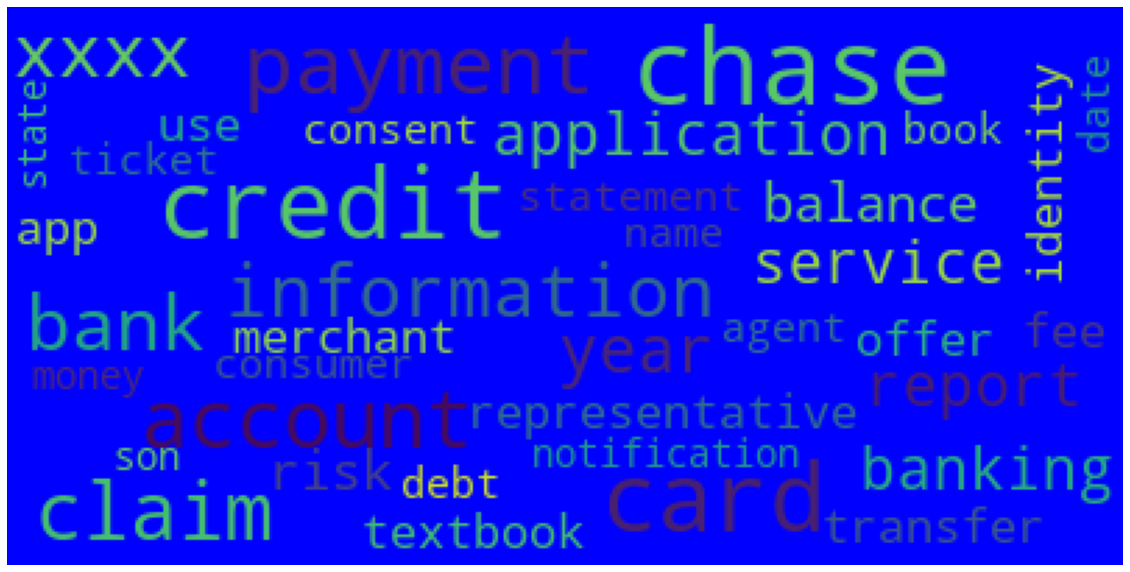

In [22]:

#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='blue',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [23]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [25]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['Complaint_clean'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

unigram  count
0    chase  48987
1  account  47916
2     xxxx  43154
3   credit  34302
4     card  29628
5     bank  28510
6  payment  21329
7     time  16304
8   charge  15141
9      day  13064

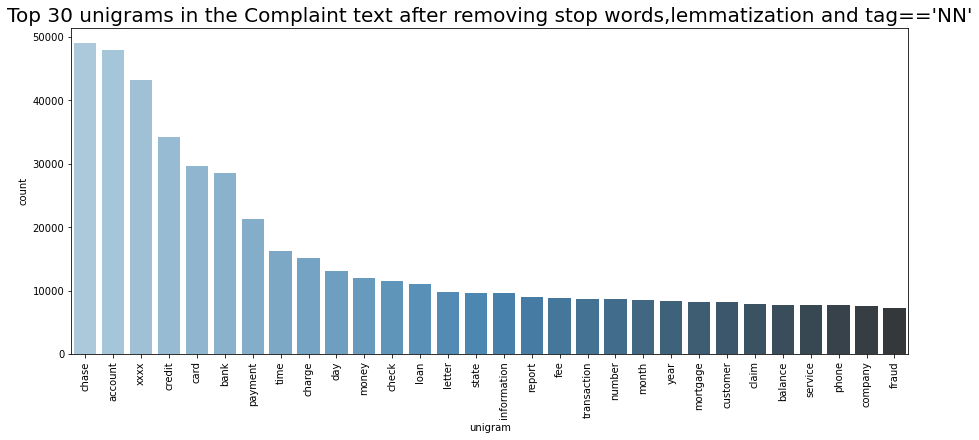

In [26]:
# Plot the top 30 unigrams 
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words,lemmatization and tag=='NN'", fontsize=20)
plt.show()

In [27]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [28]:

#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['Complaint_clean'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)



bigram  count
0       credit card  12880
1         xxxx xxxx   6200
2     credit report   3972
3  customer service   3082
4      chase credit   3059
5        chase bank   2898
6      bank account   2784
7     account chase   2737
8     chase account   2595
9   account account   2320

In [29]:
# Plot the top 30 bigrams 
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 Bigrams in the Complaint text after removing stop words,lemmatization and tag=='NN'", fontsize=20)
plt.show()

In [30]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [31]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['Complaint_clean'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

trigram  count
0      chase credit card   2136
1         xxxx xxxx xxxx   1064
2    credit card account   1057
3    credit card company    995
4      credit card chase    672
5     credit card credit    510
6  inquiry credit report    482
7     charge credit card    430
8    account credit card    414
9       card credit card    384

In [32]:
# Plot the top 30 trigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words,lemmatization and tag=='NN'", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [34]:
#All masked texts has been removed
df_clean.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')
tfidf

TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [38]:
#Load your nmf_model with the n_components i.e 5
num_topics =5 #write the value you want to test out
N_TOPICS = 10
#keep the random_state =40
nmf_model =NMF(n_components=10,random_state=40) #write your code here

In [39]:
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

In [40]:
# Top 10 words per topic
N_TOPICS = 10
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 15)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)


topic_words

Word 1 Word 2 Word 3 Word 4 Word 5 Word 6 Word 7 Word 8 Word 9  \
Topic 1     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 2     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 3     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 4     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 5     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 6     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 7     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 8     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 9     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Topic 10    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         Word 10 Word 11 Word 12 Word 13 Word 14 Word 15  
Topic 1      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 2      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 3      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 4      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 5      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 6      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 7      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 8      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 9      0.0     0.0     0.0     0.0     0.0     0.0  
Topic 10     0.0     0.0     0.0     0.0     0.0     0.0

In [41]:
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:15]
    print(ix)
    topic_words.iloc[i] = words[ix]


(topic_words)

[  49 1025 1043 5123   28  745 1780  826  523 2726 4303 7030   92 3302
 3148]
[5349 3336 1545 1234 5352 3302 1677  814 3148 3541 5657 6378 1643 3332
 1550]
[4563 4133  523 6053  463 1651 6439 1545 1643 4556 1025 4155 5349 2292
  886]
[1014 1981 3972 2679 6053 1234 5006  888 4133  635 6761 3498 5743 1643
 3087]
[3764 4155 4113 3052 1025 7030 4952 5086 2632 3092 5595 2027 6439 3688
 3235]
[ 888 1545 1025  523 3727 5657 7030 4741 5006 4351 4133  320 1234 2688
 6439]
[1038 2726 1780  915 1651  745 3047 1025  826  920 6328 3834 1613 3491
 6901]
[2498  523 4450 6531 6538 7030 1613 6439 4133 6053 2039 1651 1025 5743
 2726]
[1025 6531 1100 1981 3688 4303 3302 4651 2679 6052 1651 2185 6439 5743
 1768]
[ 536 4124 2726 6538 1674 6531  419 2039 4630 6955 1780 2989 1651  745
 1100]


Word 1       Word 2        Word 3       Word 4     Word 5  \
Topic 1   account        chase      checking       reason     access   
Topic 2    report      inquiry        credit      company  reporting   
Topic 3   payment        month       balance    statement       auto   
Topic 4    charge      dispute      merchant        fraud  statement   
Topic 5      loan     mortgage  modification         home      chase   
Topic 6      card       credit         chase      balance      limit   
Topic 7     check         fund       deposit         cash        day   
Topic 8       fee      balance     overdraft  transaction   transfer   
Topic 9     chase  transaction         claim      dispute     letter   
Topic 10     bank        money          fund     transfer      debit   

               Word 6       Word 7    Word 8       Word 9    Word 10  Word 11  \
Topic 1        branch      deposit  business      balance       fund   number   
Topic 2   information         debt   bureaus     identity      jpmcb    score   
Topic 3           day         time    credit         date        pay    chase   
Topic 4       company     purchase      card        month    billing   vendor   
Topic 5          year     property      rate  foreclosure      house     sale   
Topic 6         score         year     point     purchase      offer    month   
Topic 7        branch         hold     chase     business    cashier   teller   
Topic 8          year     customer      time        month  statement   dollar   
Topic 9        number  information     phone        fraud      state      day   
Topic 10  transaction          atm    dollar       person       wire  deposit   

              Word 12   Word 13      Word 14     Word 15  
Topic 1          year  activity  information    identity  
Topic 2         theft      date      inquire    creditor  
Topic 3      mortgage    report        error         car  
Topic 4          item   service         date       hotel  
Topic 5      document      time       letter      income  
Topic 6   application   company      freedom        time  
Topic 7          mail  customer        issue        week  
Topic 8           day     chase      service        fund  
Topic 9         email      time      service  department  
Topic 10         help       day       branch       claim

In [42]:
# Create a topic mapping

topic_mapping = {

  
  'Topic 1':'Bank account services',
  'Topic 2':'Theft/Dispute reporting',
  'Topic 3':'Mortgages/loans',
  'Topic 4':'Theft/Dispute reporting',
  'Topic 5':'Mortgages/loans',
  'Topic 6':'Credit card / Prepaid card',
  'Topic 7':'Others',
  'Topic 8':'Others',
  'Topic 9':'Theft/Dispute reporting',
  'Topic 10':'Others',

}

In [43]:
# Recall the document-topic matrix, W

W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(N_TOPICS)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)

W[pd.notnull(W['max_topic'])].head(10)

Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7  \
0  0.013191  0.012961  0.005940  0.003275  0.011540  0.002934  0.000000   
1  0.011374  0.000249  0.001715  0.000634  0.000809  0.014062  0.000000   
2  0.001781  0.017476  0.000000  0.000000  0.000000  0.033962  0.000000   
3  0.019814  0.045033  0.000356  0.000000  0.009658  0.026338  0.000000   
4  0.023231  0.000000  0.002159  0.000000  0.003449  0.001307  0.051651   
5  0.000000  0.139530  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.039853  0.000000  0.012310  0.000000  0.003177  0.005836  0.031547   
7  0.003198  0.000000  0.054225  0.000000  0.031791  0.001750  0.000059   
8  0.000000  0.007597  0.001308  0.000000  0.000000  0.000000  0.000000   
9  0.001002  0.076950  0.001540  0.001936  0.000523  0.064199  0.002278   

    Topic 8   Topic 9  Topic 10                   max_topic  
0  0.003529  0.016774  0.030081                      Others  
1  0.001344  0.015637  0.000000     Theft/Dispute reporting  
2  0.000000  0.003030  0.000000  Credit card / Prepaid card  
3  0.000000  0.026873  0.009674     Theft/Dispute reporting  
4  0.000000  0.021728  0.059780                      Others  
5  0.000000  0.000000  0.000000     Theft/Dispute reporting  
6  0.013733  0.021582  0.030941       Bank account services  
7  0.000000  0.028171  0.000000             Mortgages/loans  
8  0.007280  0.095142  0.024823     Theft/Dispute reporting  
9  0.000000  0.006758  0.000000     Theft/Dispute reporting

In [44]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7059

In [45]:
#Print the Top15 words for each of the topics

for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['identity', 'information', 'activity', 'year', 'number', 'fund', 'balance', 'business', 'deposit', 'branch', 'access', 'reason', 'checking', 'chase', 'account']


TOP 15 WORDS FOR TOPIC #1
['creditor', 'inquire', 'date', 'theft', 'score', 'jpmcb', 'identity', 'bureaus', 'debt', 'information', 'reporting', 'company', 'credit', 'inquiry', 'report']


TOP 15 WORDS FOR TOPIC #2
['car', 'error', 'report', 'mortgage', 'chase', 'pay', 'date', 'credit', 'time', 'day', 'auto', 'statement', 'balance', 'month', 'payment']


TOP 15 WORDS FOR TOPIC #3
['hotel', 'date', 'service', 'item', 'vendor', 'billing', 'month', 'card', 'purchase', 'company', 'statement', 'fraud', 'merchant', 'dispute', 'charge']


TOP 15 WORDS FOR TOPIC #4
['income', 'letter', 'time', 'document', 'sale', 'house', 'foreclosure', 'rate', 'property', 'year', 'chase', 'home', 'modification', 'mortgage', 'loan']


TOP 15 WORDS FOR TOPIC #5
['time', 'freedom', 'company', 'application', 'month', 'offer', '


# check code from here again

In [46]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([9, 8, 5, ..., 8, 2, 2])

In [47]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] =topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [48]:
df_clean.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [49]:
df_clean.shape

(21072, 5)

In [50]:
#Print the first 5 Complaint for each of the Topics

pd.set_option('display.width', 10)
pd.set_option('display.max_colwidth', 100)

df_temp=df_clean.groupby('Topic').head(5)
df_temp.sort_values('Topic')


complaint_what_happened  \
103  on xx/xx/xxxx i received an advertisement via email that new chase customers could get {$.} for ...   
17   with out notice j.p. morgan chase restricted my account by my debit card tuesday xx/xx/. on thur...   
35   i opened the saving account for the {$.} bonus. i was supposed to received the {$.} bonus after ...   
27   i opened an account with chase bank on xxxx and used a code for xxxx bonus. i called to follow u...   
24                                                   mishandling of this account by chase auto and xxxx.   
83   unknown inquire reported on my credit bureau such as xxxx   and xxxx date xx/xx/ of company chas...   
11   on xx/xx/, while trying to book a xxxx  xxxx  ticket, i came across an offer for {$.} to be appl...   
15                                                                         can you please remove inquiry   
23   i have a chase credit card which is incorrectly reporting data on my credit report. the company ...   
26   i have reached out to xxxx several times in attempt to have this fraudulent inquiry removed i wa...   
58   i made a purchase of {$.} on xx/xx/xxxx. i made payments of {$.} on xx/xx/xxxx and {$.} on xx/xx...   
82   i recently called to ask chase bank why they reported to the credit bureau that i was  days late...   
167  a double payment from my chase debt cart to chase credit card posted. they wont refund only put ...   
212  on saturday, xx/xx/xxxx and tuesday  xx/xx/ i used chase quick pay with xxxx to submit two diffe...   
20   during the summer months, i experience a decline income due to my employment. therefore, i reque...   
40   xxxx xxxx a sofa, love seat, table and chairs and was never delivered. debit card charged {$.}. ...   
138  on xx/xx/, i submitted a complaint to my bank jp morgan chase due to a charge of {$.} from my de...   
101  i purchase is an airline ticket on xx/xx/xxxx and it was xxxx dollar but the i realize it was th...   
45   i made a purchase with xxxx xxxx xxxx on xx/xx/ in the amount of {$.}. i was charged twice for t...   
157  xxxx  has taken or cleaned out all of my funds from my chase checking account since, xx/xx/. i d...   
73   i have wired through one of chase branches in xxxx xxxx, the exact reinstatement amount of {$.} ...   
57   i have been trying to do a loan modification with chase and all they do is give me the runaround...   
127  i am xxxx military member ( xxxx ) with the xxxx. chase auto finance is refusing to pay on the g...   
81   i bought a new xxxx xxxx on xx/xx/xxxx from xxxx xxxx xxxx in xxxx. \ni paid the loan in xx/xx/x...   
99   my name is xxxx xxxx. i have missed a payment in xx/xx/ and was  days past due but now current. ...   
10   chase card was reported on xx/xx/. however, fraudulent application have been submitted my identi...   
63   i tried to send almost {$.} at xxxx and the transaction was cancelled due to having no id. i was...   
64   chase is marketing credit cards to those of us with good credit like it's going out of style. be...   
32   my chase amazon card was declined for a catering order i had placed for my brothers funeral in t...   
50   i am a senior citizen that has been scammed by several companies from xxxx to xxxx. i have paid ...   
220  i wrote my husband a check which he deposited into chase bank atm machine. the check was cashed ...   
246  i closed my chase checking account online on xx/xx/ via chase 's secure messaging system, and re...   
154  on xx/xx/xxxx our firm issued a check in the amount of {$.} drawn on our chase checking account ...   
133  on xx/xx/ i made a deposit into my chase bank personal checking account in the amount of {$.} i ...   
176  i deposited a check that was endorsed to two parties, and was told i needed verification of the ...   
198  i overdrew my account due to errors related to my xxxx xxxx transactions for {$.} and {$.} on xx...   
177  .on xx/xx/ i noticed a suspicious charge on my account in the amounts of xxxx an

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [51]:
#Create the dictionary of Topic names and Topics
Topic_names = { 
0:'Bank account services',
1:'Theft/Dispute reporting',
2:'Mortgages/loans',
3:'Theft/Dispute reporting',
4:'Mortgages/loans',
5:'Credit card / Prepaid card',
6:'Others',
7:'Others',
8:'Theft/Dispute reporting',
9:'Others'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)




In [52]:

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df_clean.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [53]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
'Bank account services':0,
'Theft/Dispute reporting':1,
'Mortgages/loans':2,
'Credit card / Prepaid card':3,
'Others':4   
    
}
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [54]:
df_clean.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [55]:
df_clean['Topic'].value_counts()

1    6950
2    4985
4    4517
3    2759
0    1861
Name: Topic, dtype: int64

In [56]:
df_clean.shape

(21072, 5)

In [57]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [58]:
training_data.shape

(21072, 2)

In [59]:
training_data.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:

#Write your code to get the Vector count
import pickle
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

#SAVE WORD VECTOR
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

#TRANSFORM WORD VECTOR TO TF IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

# 1. Logistic Regression

In [61]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("logreg_model.pkl", "wb"))



In [62]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ['Bank account services',
'Theft/Dispute reporting',
'Mortgages/loans',
'Credit card / Prepaid card',
'Others' ]

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("logreg_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Mortgages/loans


In [63]:
#Printing the predicted vs actual
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Others  -  Others
Others  -  Others
Others  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Others  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute report

Credit card / Prepaid card  -  Credit card / Prepaid card
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Bank account services  -  Theft/Dispute reporting
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  

Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Others  - 

Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Others  -  Others
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepai

Others  -  Others
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Bank account services  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Bank account serv

Credit card / Prepaid card  -  Credit card / Prepaid card
Others  -  Others
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Bank account services  -  Bank account services
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Other

Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgage

Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute 

Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Others  -  Others

Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Bank account services  -  Bank account services
Mortgages/loans  -  Bank account services
Others  -  Others
Others  -  Others
Credit card / Prepaid ca

Credit card / Prepaid card  -  Credit card / Prepaid card
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prep

In [64]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted, target_names=target_names))

[[ 334   37   13    9   40]
 [  30 1592   41   39   62]
 [   1   60 1139   11   27]
 [   7  107    5  562   14]
 [  25   97   25   23  968]]
                            precision    recall  f1-score   support

     Bank account services       0.84      0.77      0.80       433
   Theft/Dispute reporting       0.84      0.90      0.87      1764
           Mortgages/loans       0.93      0.92      0.93      1238
Credit card / Prepaid card       0.87      0.81      0.84       695
                    Others       0.87      0.85      0.86      1138

                  accuracy                           0.87      5268
                 macro avg       0.87      0.85      0.86      5268
              weighted avg       0.87      0.87      0.87      5268



### This seems really good with an accuracy of 87% and decen f1-score lets see if we can improve this

# 2. Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("DT_model.pkl", "wb"))

In [66]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("DT_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Mortgages/loans


In [67]:
#Printing the predicted vs actual
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Others  -  Others
Credit card / Prepaid card  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Theft/Dispute reporting
Mortgages/loans  -  Others
Credit card / Prepaid card  -  Others
Others  -  Others
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Bank account services  -  Theft/Dispute reporting
Others  -  Others
Others  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute repor

Mortgages/loans  -  Mortgages/loans
Others  -  Others
Credit card / Prepaid card  -  Credit card / Prepaid card
Others  -  Others
Bank account services  -  Theft/Dispute reporting
Others  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Others
Others  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Bank account services  -  Bank account services
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Bank account services  -  Others
Mortgages/loans  -  Mortgages/loans
Others  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Theft/Dispute reporting
Mortgages/loans  -  Others
Theft/Dispute reporting  -  Theft/Dispute repo

Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Credit card / Prepaid card  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Bank account services  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Bank account services
Credit card / Prepaid card  -  Credit card / Prepaid card
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Bank account services  -  Theft/Dispute reporting
Mortgages/loans  -  Theft/Dispute reporting
Others  -  Others
Bank account services  -  Bank 

Credit card / Prepaid card  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Others
Mortgages/loans  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Bank account services  -  Bank account services
C

Mortgages/loans  -  Others
Credit card / Prepaid card  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Credit card / Prepaid card  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Others  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Others  -  Mortgages/loans
Theft/Dispute reporti

Theft/Dispute reporting  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Others
Bank account services  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Others
Credit card / Prepaid card  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Others
Credit card / Prepaid card  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Bank account services
Credit card / Prepaid card  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Others  -  Oth

Theft/Dispute reporting  -  Theft/Dispute reporting
Bank account services  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Others  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Others
Others  -  Others
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Others  -  Theft/

Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Bank account services
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Others  -  Theft/Dispute reporting
Bank acco

Mortgages/loans  -  Mortgages/loans
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Credit card / Prepaid card  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Others
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Others  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  - 

Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Credit card / Prepaid card
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Bank account services
Others  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Credit card / Prepaid card  -  Credit card / Prepaid card
Bank account services  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loan

Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Credit card / Prepaid card  -  Credit card / Prepaid card
Bank account services  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Mortgages/loans
Bank account services  -  Bank account services
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Bank account services  -  Bank account services
Others  -  Others
Mortgages/loans  -  Others
Bank account services  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Credit card / Prepaid card  -  Others
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Others
Bank account services  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans

In [68]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted, target_names=target_names))

[[ 270   62   21   15   65]
 [ 100 1268  118  129  149]
 [   8  128 1029   13   60]
 [  12  151   13  492   27]
 [  48  149   58   44  839]]
                            precision    recall  f1-score   support

     Bank account services       0.62      0.62      0.62       433
   Theft/Dispute reporting       0.72      0.72      0.72      1764
           Mortgages/loans       0.83      0.83      0.83      1238
Credit card / Prepaid card       0.71      0.71      0.71       695
                    Others       0.74      0.74      0.74      1138

                  accuracy                           0.74      5268
                 macro avg       0.72      0.72      0.72      5268
              weighted avg       0.74      0.74      0.74      5268



### There is no improvement looks like logistic regression is the best model till now

# 3. Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("RF_model.pkl", "wb"))

In [70]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("RF_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Theft/Dispute reporting


In [71]:
#Printing the predicted vs actual
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Mortgages/loans  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting

Theft/Dispute reporting  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  

Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reportin

Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dis

Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages

Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
T

Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mo

Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Th

Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
The

Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute re

Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Others
Others  -  Theft/Dispute reporting
Mortgages/loans  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Mortgages/loans 

In [72]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted, target_names=target_names))

[[   1  352   12    0   68]
 [   0 1721   23    0   20]
 [   0  407  824    0    7]
 [   0  674   18    2    1]
 [   0  777   48    0  313]]
                            precision    recall  f1-score   support

     Bank account services       1.00      0.00      0.00       433
   Theft/Dispute reporting       0.44      0.98      0.60      1764
           Mortgages/loans       0.89      0.67      0.76      1238
Credit card / Prepaid card       1.00      0.00      0.01       695
                    Others       0.77      0.28      0.40      1138

                  accuracy                           0.54      5268
                 macro avg       0.82      0.38      0.36      5268
              weighted avg       0.74      0.54      0.47      5268



### There is no improvement looks like logistic regression is the best model till now

# 4. Multinomial Naive Bayes

In [73]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = MultinomialNB().fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("nb_model.pkl", "wb"))

In [74]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("nb_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Mortgages/loans


In [75]:
#Printing the predicted vs actual
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Others  -  Others
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting

Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reportin

Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
T

Others  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispu

Theft/Dispute reporting  -  Bank account services
Others  -  Others
Theft/Dispute reporting  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Bank account services
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Th

Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Others  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Mort

Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  T

Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Others
Others  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/

Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Others  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Others
Theft/Dispute reporting  -  Credit card / Prepai

Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -

Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Credit card / Prepaid card  -  Credit card / Prepaid card
Others  -  Bank account services
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Bank account services
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute rep

Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Disp

Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Bank account services
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute r

Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/

Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Others  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reportin

Others  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Others
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Theft/Dispute reporting
Others  -  Others
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute repo

Others  -  Others
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Theft/Dispute reporting  -  Bank account services
Theft/Dispute reporting  -  Credit card / Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Others  -  Others
Credit card / Prepaid card  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Credit card / Prepaid card
Others  -  Credit card / Prepaid card
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Others
Theft/Dispute reporting  -  Mortgages/loans
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft/Dispute reporting
Theft/Dispute reporting  -  Theft

In [76]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
#target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

[[   0  330   15    0   88]
 [   1 1683   43    0   37]
 [   0  330  899    1    8]
 [   0  644   37   12    2]
 [   1  606   61    1  469]]
                            precision    recall  f1-score   support

     Bank account services       0.00      0.00      0.00       433
   Theft/Dispute reporting       0.47      0.95      0.63      1764
           Mortgages/loans       0.85      0.73      0.78      1238
Credit card / Prepaid card       0.86      0.02      0.03       695
                    Others       0.78      0.41      0.54      1138

                  accuracy                           0.58      5268
                 macro avg       0.59      0.42      0.40      5268
              weighted avg       0.64      0.58      0.52      5268



### There is no improvement looks like logistic regression is the best model till now

# Final Model 
## We choose logistic regression model 1 with an accuracy of 87% which is the highest we have achieved

### Now let us do some hyper parmater tuning on logstic regression to see if we can improve the accuracy

In [77]:
# Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [78]:
# Hyperparameter tuning for best result to see if it improves from 87%
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':[ 'lbfgs','newton-cg', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/anishreddy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anishreddy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/anishreddy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/anishreddy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

/Users/anishreddy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anishreddy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/anishreddy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/anishreddy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [79]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [84]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,y_pred_lr_tuned)
print(confusion_mat)
from sklearn.metrics import classification_report
#target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, y_pred_lr_tuned, target_names=target_names))

[[ 355   32   10    4   32]
 [  32 1588   41   40   63]
 [   0   58 1146    8   26]
 [   5   74    4  601   11]
 [  23   69   21   18 1007]]
                            precision    recall  f1-score   support

     Bank account services       0.86      0.82      0.84       433
   Theft/Dispute reporting       0.87      0.90      0.89      1764
           Mortgages/loans       0.94      0.93      0.93      1238
Credit card / Prepaid card       0.90      0.86      0.88       695
                    Others       0.88      0.88      0.88      1138

                  accuracy                           0.89      5268
                 macro avg       0.89      0.88      0.88      5268
              weighted avg       0.89      0.89      0.89      5268



### After doing hyper parameter tuning we were able to improve the accuracy to 89% from 87% which is the best we got